In [18]:
import pyarrow.parquet as pq
from pathlib import Path
import numpy as np
import pandas as pd

files = list(Path('Simulations/output').glob('*_simulation.parquet'))
n_players = len(files)

# Display-friendly base state names
BASE_STATE_DISPLAY = {
    0: "Bases Empty", 
    1: "Runner on 1st", 
    2: "Runner on 2nd", 
    3: "Runners on 1st & 2nd", 
    4: "Runner on 3rd", 
    5: "Runners on 1st & 3rd", 
    6: "Runners on 2nd & 3rd", 
    7: "Bases Loaded"
}

# Columns to group by
group_cols = ['base_state', 'outs', 'inning', 'inning_topbot', 'score_diff']

# Load first file to get grouping columns
first_df = pq.read_table(files[0], columns=group_cols + ['wp_diff_from_baseline']).to_pandas()
avg_wp_diff = first_df['wp_diff_from_baseline'].values / n_players

# Add remaining files
for f in files[1:]:
    wp_diff = pq.read_table(f, columns=['wp_diff_from_baseline']).to_pandas()['wp_diff_from_baseline'].values
    avg_wp_diff += wp_diff / n_players

# Create dataframe with grouping columns and averaged wp_diff
result_df = first_df[group_cols].copy()
result_df['avg_wp_diff'] = avg_wp_diff

# Group by game state and get mean
grouped = result_df.groupby(group_cols)['avg_wp_diff'].mean().reset_index()
grouped = grouped.sort_values('avg_wp_diff', ascending=False)

print(f"Number of players: {n_players}")
print(f"Number of unique game states: {len(grouped)}")
print(f"\nOverall mean WP change: {grouped['avg_wp_diff'].mean():.6f}")
grouped

Number of players: 27
Number of unique game states: 1008

Overall mean WP change: -0.000921


,base_state,outs,inning,inning_topbot,score_diff,avg_wp_diff
829,6,1,9,Bot,-1,0.010330
830,6,1,9,Bot,0,0.010278
837,6,1,9,Top,0,0.009023
578,4,1,9,Bot,0,0.008729
585,4,1,9,Top,0,0.008551
...,...,...,...,...,...,...
199,1,1,9,Bot,-1,-0.007729
492,3,2,9,Bot,-2,-0.008495
744,5,2,9,Bot,-2,-0.008503
241,1,2,9,Bot,-1,-0.008535


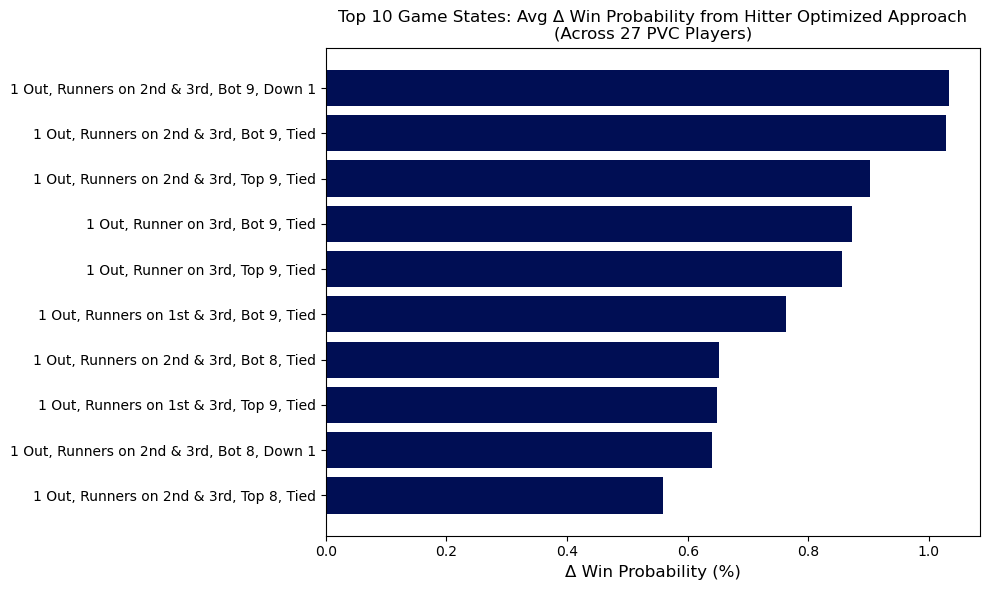

In [21]:
# Top 10 game states with highest Δ Win Probability from baseline
import matplotlib.pyplot as plt

top10 = grouped.head(10).copy()

# Format score diff as "Down X" / "Tied" / "Up X"
def format_score(sd):
    if sd < 0:
        return f"Down {abs(int(sd))}"
    elif sd > 0:
        return f"Up {int(sd)}"
    else:
        return "Tied"

# Create label for each game state (matching notebook style)
top10['state_label'] = top10.apply(
    lambda r: f"{int(r['outs'])} Out, {BASE_STATE_DISPLAY[int(r['base_state'])]}, "
              f"{r['inning_topbot']} {int(r['inning'])}, {format_score(r['score_diff'])}",
    axis=1
)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top10['state_label'][::-1], top10['avg_wp_diff'][::-1] * 100, color='#000E54')
ax.set_xlabel('Δ Win Probability (%)', fontsize=12)
ax.set_title('Top 10 Game States: Avg Δ Win Probability from Hitter Optimized Approach\n(Across 27 PVC Players)', fontsize=12)
ax.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

In [23]:
# Compute probability of exactly 1 run for each game state and adjustment
import pickle

# Load transition tables
with open("Simulations/transition_tables.pkl", "rb") as f:
    transition_tables = pickle.load(f)

def compute_prob_exactly_n_runs(outcome_probs, outs, base_state, trans_tables, n_runs=1):
    """
    Compute probability of scoring exactly n runs given outcome probabilities.
    
    outcome_probs: [prob_K, prob_BB_HBP, prob_field_out, prob_1B, prob_2B, prob_3B, prob_HR]
    """
    prob_n_runs = 0.0
    
    for outcome_idx, outcome_prob in enumerate(outcome_probs):
        # Get transitions for this outcome
        key = (outcome_idx, outs, base_state)
        transitions = trans_tables.get(key, [(base_state, min(outs + 1, 3), 0, 1.0)])
        
        for post_base, post_outs, runs_scored, trans_prob in transitions:
            if runs_scored == n_runs:
                prob_n_runs += outcome_prob * trans_prob
    
    return prob_n_runs

# Load simulation files and compute prob_exactly_1_run
files = list(Path('Simulations/output').glob('*_simulation.parquet'))
n_players = len(files)

# Columns needed
cols = ['base_state', 'outs', 'inning', 'inning_topbot', 'score_diff',
        'bat_speed_change_pct', 'swing_length_change_pct',
        'prob_K', 'prob_BB_HBP', 'prob_field_out', 'prob_1B', 'prob_2B', 'prob_3B', 'prob_HR',
        'wp_diff_from_baseline']

# Load first file
first_df = pq.read_table(files[0], columns=cols).to_pandas()

# Compute prob_exactly_1_run for first file
print("Computing prob_exactly_1_run for each row...")
outcome_cols = ['prob_K', 'prob_BB_HBP', 'prob_field_out', 'prob_1B', 'prob_2B', 'prob_3B', 'prob_HR']

first_df['prob_exactly_1_run'] = first_df.apply(
    lambda r: compute_prob_exactly_n_runs(
        r[outcome_cols].values, int(r['outs']), int(r['base_state']), transition_tables, n_runs=1
    ), axis=1
)

# Get baseline prob_1_run (where adjustments are 0)
baseline_mask = (first_df['bat_speed_change_pct'] == 0) & (first_df['swing_length_change_pct'] == 0)
baseline_p1r = first_df.loc[baseline_mask, ['base_state', 'outs', 'inning', 'inning_topbot', 'score_diff', 'prob_exactly_1_run']].copy()
baseline_p1r = baseline_p1r.rename(columns={'prob_exactly_1_run': 'baseline_prob_1_run'})

# Merge baseline back
first_df = first_df.merge(baseline_p1r, on=['base_state', 'outs', 'inning', 'inning_topbot', 'score_diff'], how='left')
first_df['prob_1_run_diff'] = first_df['prob_exactly_1_run'] - first_df['baseline_prob_1_run']

print(f"Sample prob_exactly_1_run values:")
print(first_df[['base_state', 'outs', 'prob_exactly_1_run', 'baseline_prob_1_run', 'prob_1_run_diff']].head(10))

Computing prob_exactly_1_run for each row...
Sample prob_exactly_1_run values:
   base_state  outs  prob_exactly_1_run  baseline_prob_1_run  prob_1_run_diff
0           0     0            0.038492             0.038492         0.000000
1           0     0            0.038492             0.030233         0.008259
2           0     0            0.038492             0.019703         0.018789
3           0     0            0.038492             0.040162        -0.001670
4           0     0            0.038492             0.032387         0.006105
5           0     0            0.038492             0.022191         0.016300
6           0     0            0.038492             0.036983         0.001509
7           0     0            0.038492             0.034493         0.003999
8           0     0            0.038492             0.024347         0.014144
9           0     0            0.038492             0.018118         0.020374


In [1]:
import sys
sys.path.insert(0, "Bayes Outcomes")

import numpy as np
import matplotlib.pyplot as plt
from update_stats import get_player_stats, update_stats

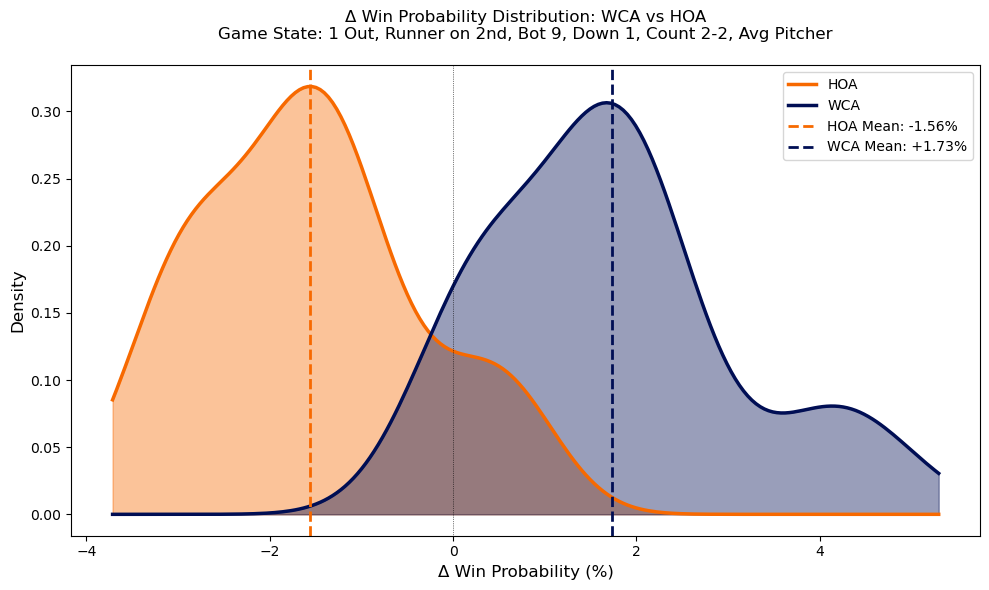

HOA: Mean=-1.56%, Std=1.16%
WCA: Mean=+1.73%, Std=1.32%
Avg Improvement (WCA - HOA): +3.290%


In [42]:
# Density Distribution of Δ WP from Pre-PA: WCA vs HOA for a Given Game State
# Change these parameters to explore different situations

INPUT_OUTS = 1
INPUT_BASE_STATE = 2  # 0=empty, 1=1B, 2=2B, 3=1B&2B, 4=3B, 5=1B&3B, 6=2B&3B, 7=loaded
INPUT_INNING = 9
INPUT_INNING_TOPBOT = "Bot"
INPUT_SCORE_DIFF = -1  # from batter's perspective
INPUT_COUNT = "2-2"  # balls-strikes

# Load all simulation files
SIM_OUTPUT_DIR = Path("Simulations/output")
sim_files = list(SIM_OUTPUT_DIR.glob("*_simulation.parquet"))

# Collect delta WP for each player at this game state
player_results = []

for sim_file in sim_files:
    sim_df = pq.read_table(sim_file).to_pandas()
    
    # Filter to the specified state
    state_filter = (
        (sim_df['outs'] == INPUT_OUTS) &
        (sim_df['base_state'] == INPUT_BASE_STATE) &
        (sim_df['inning'] == INPUT_INNING) &
        (sim_df['inning_topbot'] == INPUT_INNING_TOPBOT) &
        (sim_df['score_diff'] == INPUT_SCORE_DIFF) &
        (sim_df['count'] == INPUT_COUNT)
    )
    
    state_sims = sim_df[state_filter]
    
    if len(state_sims) == 0:
        continue
    
    player_name = state_sims['player_name'].iloc[0]
    
    # HOA = baseline (0% adjustment)
    baseline = state_sims[
        (state_sims['bat_speed_change_pct'] == 0) & 
        (state_sims['swing_length_change_pct'] == 0)
    ]
    if len(baseline) == 0:
        continue
    wp_before = baseline['wp_before_pa'].mean()
    hoa_delta = (baseline['adjusted_wp_after_pa'].mean() - wp_before) * 100
    
    # WCA = best feasible adjustment
    feasible = state_sims[state_sims['is_feasible'] == 1]
    if len(feasible) > 0:
        best_idx = feasible['adjusted_wp_after_pa'].idxmax()
        wca_delta = (feasible.loc[best_idx, 'adjusted_wp_after_pa'] - wp_before) * 100
    else:
        wca_delta = hoa_delta
    
    player_results.append({
        'player_name': player_name,
        'hoa_delta': hoa_delta,
        'wca_delta': wca_delta
    })

results_df = pd.DataFrame(player_results)

# Pitcher quality label
PITCHER_LABELS = {10: "Elite", 30: "Above Avg", 50: "Average", 70: "Below Avg", 90: "Poor"}

# Plot density distributions (KDE only)
fig, ax = plt.subplots(figsize=(10, 6))

from scipy.stats import gaussian_kde

x_range = np.linspace(
    min(results_df['hoa_delta'].min(), results_df['wca_delta'].min()) - 0.5,
    max(results_df['hoa_delta'].max(), results_df['wca_delta'].max()) + 0.5,
    200
)

# HOA density
kde_hoa = gaussian_kde(results_df['hoa_delta'])
ax.fill_between(x_range, kde_hoa(x_range), alpha=0.4, color='#F76900')
ax.plot(x_range, kde_hoa(x_range), color='#F76900', lw=2.5, label='HOA')

# WCA density
kde_wca = gaussian_kde(results_df['wca_delta'])
ax.fill_between(x_range, kde_wca(x_range), alpha=0.4, color='#000E54')
ax.plot(x_range, kde_wca(x_range), color='#000E54', lw=2.5, label='WCA')

# Mean lines
ax.axvline(results_df['hoa_delta'].mean(), color='#F76900', linestyle='--', lw=2, label=f"HOA Mean: {results_df['hoa_delta'].mean():+.2f}%")
ax.axvline(results_df['wca_delta'].mean(), color='#000E54', linestyle='--', lw=2, label=f"WCA Mean: {results_df['wca_delta'].mean():+.2f}%")

ax.axvline(0, color='black', linewidth=0.5, linestyle=':')

ax.set_xlabel('Δ Win Probability (%)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(
    f"Δ Win Probability Distribution: WCA vs HOA\n"
    f"Game State: {INPUT_OUTS} Out, {BASE_STATE_DISPLAY[INPUT_BASE_STATE]}, "
    f"{INPUT_INNING_TOPBOT} {INPUT_INNING}, {format_score(INPUT_SCORE_DIFF)}, "
    f"Count {INPUT_COUNT}, Avg Pitcher\n",
    fontsize=12
)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Summary
print(f"HOA: Mean={results_df['hoa_delta'].mean():+.2f}%, Std={results_df['hoa_delta'].std():.2f}%")
print(f"WCA: Mean={results_df['wca_delta'].mean():+.2f}%, Std={results_df['wca_delta'].std():.2f}%")
print(f"Avg Improvement (WCA - HOA): {(results_df['wca_delta'] - results_df['hoa_delta']).mean():+.3f}%")

Kyle Schwarber (2025): 77.2 mph, 7.50 ft, Z-Contact: 80.0%, xISO: 0.333


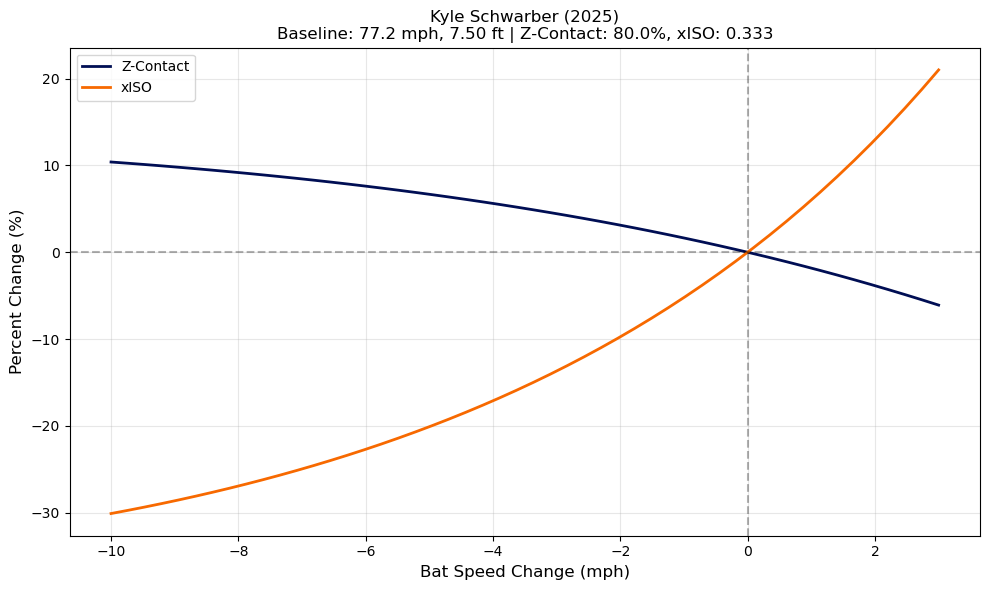

In [139]:
# Pct Change in Z-Contact and xISO by Bat Speed Change (Kyle Schwarber)
schwarber = get_player_stats("Kyle Schwarber")
print(f"{schwarber['player_name']} ({schwarber['season']}): {schwarber['bat_speed']:.1f} mph, {schwarber['swing_length']:.2f} ft, Z-Contact: {schwarber['z_contact']:.1%}, xISO: {schwarber['xiso']:.3f}")

bs_changes = np.linspace(-10, 3, 50)
zc_pct_changes = []
xiso_pct_changes = []

for bs_change in bs_changes:
    result = update_stats(
        current_bat_speed=schwarber['bat_speed'],
        current_swing_length=schwarber['swing_length'],
        current_z_contact=schwarber['z_contact'],
        current_xiso=schwarber['xiso'],
        bat_speed_change=bs_change,
        swing_length_change=0.0,
    )
    zc_pct_changes.append((result['z_contact_change'] / schwarber['z_contact']) * 100)
    xiso_pct_changes.append((result['xiso_change'] / schwarber['xiso']) * 100)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(bs_changes, zc_pct_changes, color='#000E54', linewidth=2, label='Z-Contact')
ax.plot(bs_changes, xiso_pct_changes, color='#F76900', linewidth=2, label='xISO')
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.axvline(0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Bat Speed Change (mph)', fontsize=12)
ax.set_ylabel('Percent Change (%)', fontsize=12)
ax.set_title(f"{schwarber['player_name']} ({schwarber['season']})\n"
             f"Baseline: {schwarber['bat_speed']:.1f} mph, {schwarber['swing_length']:.2f} ft | "
             f"Z-Contact: {schwarber['z_contact']:.1%}, xISO: {schwarber['xiso']:.3f}")
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Pre-State: Runners on 1st & 2nd, 1 out | Bot 8 | Down 1 | WP: 41.1%

Post-States (Conditional on Double):
  Runners on 2nd & 3rd 1out +1R | P=63.3% | WP=76.6%
  Runner on 2nd 1out +2R | P=30.9% | WP=87.9%
  Runner on 3rd 1out +2R | P=2.5% | WP=90.1%
  Runner on 2nd 2out +1R | P=1.8% | WP=57.8%

Expected WP After: 78.9% (+37.9%)


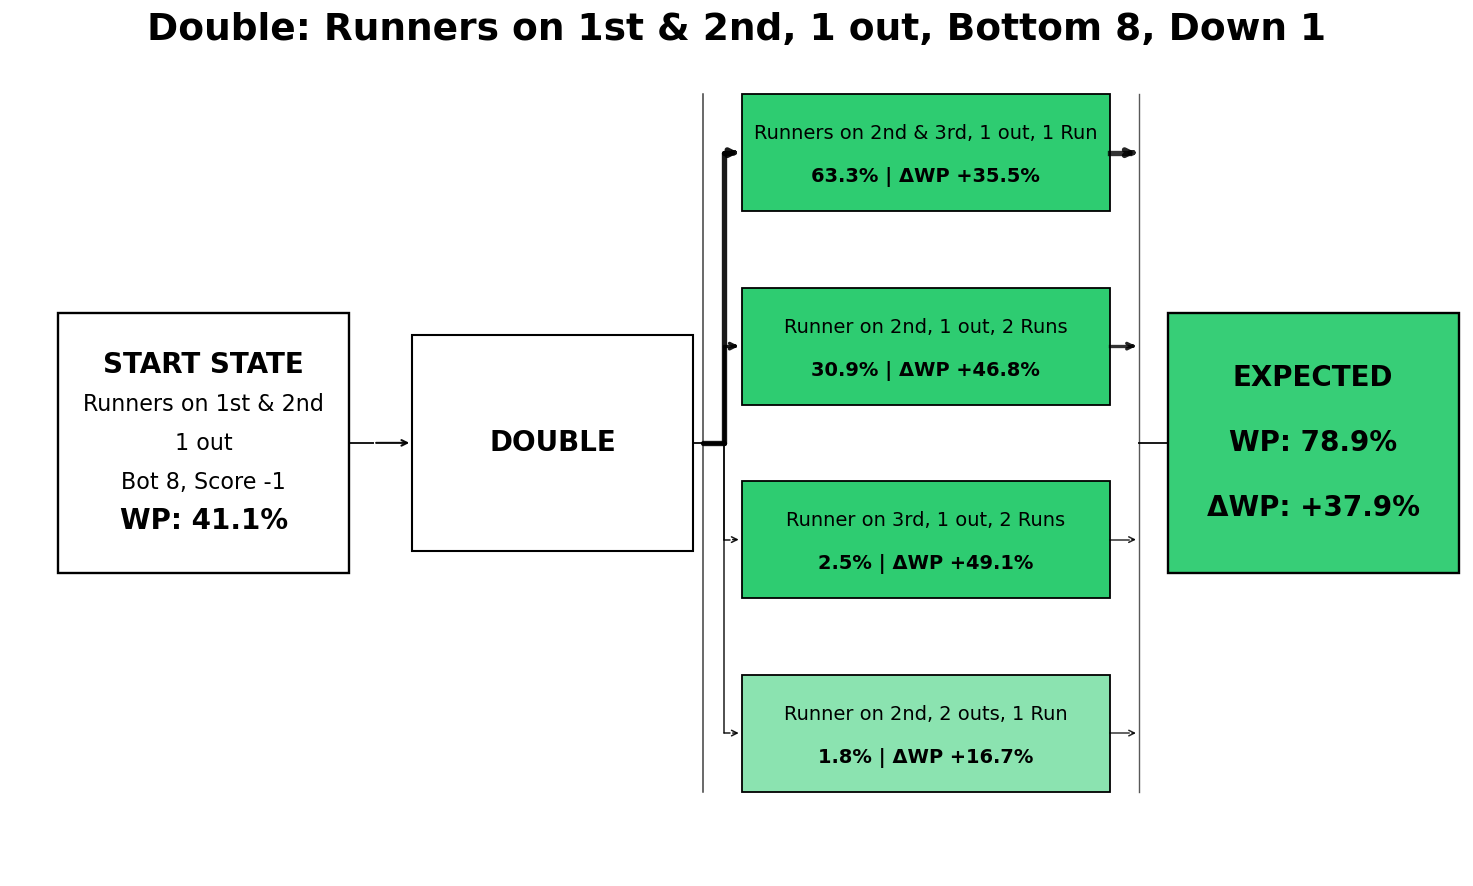

In [ ]:
# Transition State Flowmap: Field out with runner on 3rd, 1 out, Bot 9, tie game
import pickle
from pathlib import Path
import pandas as pd
from matplotlib.colors import to_rgb

DATA_DIR = Path("Data")
SIM_DIR = Path("Simulations")

with open(SIM_DIR / "transition_tables.pkl", "rb") as f:
    transition_tables = pickle.load(f)

def build_wp_lookup():
    """Build WP lookup using bat_win_exp from PBP data (pre-computed field)."""
    pbp_files = [DATA_DIR / f"pbp_{year}.parquet" for year in [2023, 2024, 2025]]
    pbp = pd.concat([pd.read_parquet(f) for f in pbp_files if f.exists()], ignore_index=True)
    pbp = pbp[pbp["bat_win_exp"].notna()].copy()
    def encode_base(row):
        state = 0
        if pd.notna(row["on_1b"]): state |= 1
        if pd.notna(row["on_2b"]): state |= 2
        if pd.notna(row["on_3b"]): state |= 4
        return state
    pbp["base_state"] = pbp.apply(encode_base, axis=1)
    pbp["inning_capped"] = pbp["inning"].clip(upper=9)
    pbp["score_diff_capped"] = pbp["bat_score_diff"].clip(lower=-5, upper=5)
    pbp["topbot_idx"] = (pbp["inning_topbot"] == "Bot").astype(int)
    grouped = pbp.groupby(["outs_when_up", "base_state", "inning_capped", "topbot_idx", "score_diff_capped"])["bat_win_exp"].mean()
    wp_table = np.full((3, 8, 9, 2, 11), 0.5, dtype=np.float32)
    for (outs, base_state, inning, topbot, score_diff), wp in grouped.items():
        outs_idx, base_idx, inning_idx = int(outs), int(base_state), int(inning) - 1
        topbot_idx, score_idx = int(topbot), int(score_diff) + 5
        if 0 <= outs_idx < 3 and 0 <= base_idx < 8 and 0 <= inning_idx < 9:
            wp_table[outs_idx, base_idx, inning_idx, topbot_idx, score_idx] = wp
    return wp_table

wp_table = build_wp_lookup()

def lookup_wp(outs, base_state, inning, topbot, score_diff):
    outs_idx = max(0, min(2, outs))
    base_idx = max(0, min(7, base_state))
    inning_idx = max(0, min(8, min(inning, 9) - 1))
    topbot_idx = 1 if topbot == "Bot" else 0
    score_idx = max(0, min(10, int(score_diff) + 5))
    return float(wp_table[outs_idx, base_idx, inning_idx, topbot_idx, score_idx])

def get_transitions(outcome_idx, outs, base_state):
    return transition_tables.get((outcome_idx, outs, base_state), [(base_state, min(outs+1, 3), 0, 1.0)])

def prob_to_color(prob):
    """Interpolate from white (prob=0) to green (prob=1)."""
    green = to_rgb('#2ecc71')
    white = (1.0, 1.0, 1.0)
    p = max(0.0, min(1.0, float(prob)))
    return tuple(w + p * (g - w) for w, g in zip(white, green))


def delta_wp_to_color(delta_wp, max_abs=0.40):
    """Interpolate white->green for positive ΔWP and white->red for negative ΔWP."""
    white = (1.0, 1.0, 1.0)
    target = to_rgb('#2ecc71') if delta_wp >= 0 else to_rgb('#e74c3c')
    x = min(abs(float(delta_wp)) / max_abs, 1.0)
    x = 0.15 + 0.85 * x  # keep visible tint even for small changes
    return tuple(w + x * (t - w) for w, t in zip(white, target))

def format_score_state(score_diff):
    if score_diff == 0:
        return "Tie game"
    return f"Ahead {score_diff}" if score_diff > 0 else f"Down {abs(score_diff)}"

BASE_STATE_LABELS = {
    0: "Bases Empty",
    1: "Runner on 1st",
    2: "Runner on 2nd",
    3: "Runners on 1st & 2nd",
    4: "Runner on 3rd",
    5: "Runners on 1st & 3rd",
    6: "Runners on 2nd & 3rd",
    7: "Bases Loaded",
}
BASE_STATE_BOX_LABELS = {
    0: "Bases Empty",
    1: "Runner on\n1st",
    2: "Runner on\n2nd",
    3: "Runners on\n1st & 2nd",
    4: "Runner on\n3rd",
    5: "Runners on\n1st & 3rd",
    6: "Runners on\n2nd & 3rd",
    7: "Bases Loaded",
}
OUTCOME_LABELS = {
    0: "Strikeout",
    1: "Walk/HBP",
    2: "Field Out",
    3: "Single",
    4: "Double",
    5: "Triple",
    6: "Home Run",
}

def plot_transition_state_flowmap(
    outcome_idx,
    pre_outs,
    pre_base_state,
    inning,
    inning_topbot,
    score_diff,
    min_prob=0.01,
):
    outcome_name = OUTCOME_LABELS.get(outcome_idx, f"Outcome {outcome_idx}")

    wp_before = lookup_wp(pre_outs, pre_base_state, inning, inning_topbot, score_diff)
    transitions = get_transitions(outcome_idx, pre_outs, pre_base_state)

    transition_data = []
    for post_base, post_outs, runs_scored, prob in transitions:
        if prob < min_prob:
            continue
        new_score_diff = score_diff + runs_scored

        # Bottom 9+ walk-off: any go-ahead run for batting team ends the game immediately.
        if inning_topbot == "Bot" and inning >= 9 and score_diff <= 0 and new_score_diff > 0:
            wp_after = 1.0
        elif post_outs >= 3:
            wp_after = 1 - lookup_wp(0, 0, inning + 1, "Top", -new_score_diff)
        else:
            wp_after = lookup_wp(post_outs, post_base, inning, inning_topbot, new_score_diff)

        transition_data.append({
            'post_base': post_base,
            'post_base_name': BASE_STATE_LABELS[post_base],
            'post_base_box': BASE_STATE_BOX_LABELS[post_base],
            'post_outs': post_outs,
            'runs_scored': runs_scored,
            'prob': prob,
            'wp_after': wp_after,
        })

    transition_data = sorted(transition_data, key=lambda x: -x['prob'])
    expected_wp_after = sum(t['prob'] * t['wp_after'] for t in transition_data)
    delta_wp = expected_wp_after - wp_before

    print(
        f"Pre-State: {BASE_STATE_LABELS[pre_base_state]}, {pre_outs} out | "
        f"{inning_topbot} {inning} | {format_score_state(score_diff)} | WP: {wp_before:.1%}\n"
    )
    print(f"Post-States (Conditional on {outcome_name}):")
    for t in transition_data:
        print(
            f"  {t['post_base_name']:8s} {t['post_outs']}out +{t['runs_scored']}R | "
            f"P={t['prob']:.1%} | WP={t['wp_after']:.1%}"
        )
    print(f"\nExpected WP After: {expected_wp_after:.1%} ({delta_wp:+.1%})")

    fig, ax = plt.subplots(figsize=(15, 9))
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 10)
    ax.axis('off')

    def draw_elbow(ax, x0, y0, x1, y1, x_elbow=None, color='black', alpha=0.9, lw=1.2, arrow_at_end=True):
        if x_elbow is None:
            x_elbow = (x0 + x1) / 2
        ax.plot([x0, x_elbow], [y0, y0], color=color, alpha=alpha, lw=lw, solid_capstyle='round')
        ax.plot([x_elbow, x_elbow], [y0, y1], color=color, alpha=alpha, lw=lw, solid_capstyle='round')
        if arrow_at_end:
            ax.plot([x_elbow, x1 - 0.12], [y1, y1], color=color, alpha=alpha, lw=lw, solid_capstyle='round')
            ax.annotate('', xy=(x1, y1), xytext=(x1 - 0.12, y1),
                        arrowprops=dict(arrowstyle='->', color=color, alpha=alpha, lw=max(0.9, lw)))
        else:
            ax.plot([x_elbow, x1], [y1, y1], color=color, alpha=alpha, lw=lw, solid_capstyle='round')

    # Layout anchors
    x_start, w_start = 0.5, 3.0
    x_out, w_out = 4.15, 2.9
    x_left_bus = 3.75
    x_post_bus = 7.15
    x_post, w_post = 7.55, 3.8
    x_right_bus = 11.65
    x_final, w_final = 11.95, 3.0
    y_mid = 5.0
    h_start, h_out, h_post, h_final = 3.0, 2.5, 1.35, 3.0

    y_positions = np.linspace(8.35, 1.65, len(transition_data)) if transition_data else np.array([5.0])
    y_top_extent = max(y_positions) + h_post / 2
    y_bot_extent = min(y_positions) - h_post / 2

    # Start-state box
    ax.add_patch(plt.Rectangle((x_start, y_mid - h_start/2), w_start, h_start,
                               facecolor='white', edgecolor='black', lw=1.7))
    ax.text(x_start + w_start/2, y_mid + 0.9, "START STATE", ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(x_start + w_start/2, y_mid + 0.45, BASE_STATE_LABELS[pre_base_state], ha='center', va='center', fontsize=16)
    ax.text(x_start + w_start/2, y_mid,
            f"{pre_outs} out" if pre_outs == 1 else f"{pre_outs} outs",
            ha='center', va='center', fontsize=16)
    ax.text(x_start + w_start/2, y_mid - 0.45, f"{inning_topbot} {inning}, Score {score_diff:+d}", ha='center', va='center', fontsize=16)
    ax.text(x_start + w_start/2, y_mid - .9, f"WP: {wp_before:.1%}", ha='center', va='center', fontsize=20, fontweight='bold')

    # Outcome box + backbone
    ax.add_patch(plt.Rectangle((x_out, y_mid - h_out/2), w_out, h_out,
                               facecolor='white', edgecolor='black', lw=1.5))
    ax.text(x_out + w_out/2, y_mid, outcome_name.upper(), ha='center', va='center', fontsize=20, fontweight='bold', color='black')
    ax.plot([x_start + w_start, x_left_bus], [y_mid, y_mid], color='black', alpha=0.9, lw=1.4)
    ax.annotate('', xy=(x_out, y_mid), xytext=(x_left_bus, y_mid),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5, alpha=0.95))
    ax.plot([x_out + w_out, x_post_bus], [y_mid, y_mid], color='black', alpha=0.9, lw=1.4)
    ax.plot([x_post_bus, x_post_bus], [y_bot_extent, y_top_extent], color='black', alpha=0.75, lw=1.1)
    ax.plot([x_right_bus, x_final], [y_mid, y_mid], color='black', alpha=0.9, lw=1.4)
    ax.plot([x_right_bus, x_right_bus], [y_bot_extent, y_top_extent], color='black', alpha=0.65, lw=1.0)

    # Post-state boxes + connectors
    for t, y in zip(transition_data, y_positions):
        post_delta = t['wp_after'] - wp_before
        fill = delta_wp_to_color(post_delta, max_abs=0.35)
        ax.add_patch(plt.Rectangle((x_post, y - h_post/2), w_post, h_post,
                                   facecolor=fill, edgecolor='black', lw=1.3))
        outs_txt = f"{t['post_outs']} out" if t['post_outs'] == 1 else f"{t['post_outs']} outs"
        runs_txt = f"{t['runs_scored']} Run" if t['runs_scored'] == 1 else f"{t['runs_scored']} Runs"
        label1 = f"{t['post_base_name']}, {outs_txt}, {runs_txt}"
        label2 = f"{t['prob']:.1%} | ΔWP {post_delta:+.1%}"
        ax.text(x_post + w_post/2, y + 0.22, label1, ha='center', va='center', fontsize=14)
        ax.text(x_post + w_post/2, y - 0.28, label2, ha='center', va='center', fontsize=14, fontweight='bold')

        lw_branch = 1.0 + 4.5 * t['prob']
        draw_elbow(ax, x_post_bus, y_mid, x_post, y, x_elbow=x_post_bus + 0.22,
                   color='black', alpha=0.9, lw=max(0.9, lw_branch), arrow_at_end=True)
        ax.plot([x_post + w_post, x_right_bus - 0.10], [y, y], color='black', alpha=0.8, lw=max(0.9, lw_branch))
        ax.annotate('', xy=(x_right_bus, y), xytext=(x_right_bus - 0.10, y),
                    arrowprops=dict(arrowstyle='->', color='black', lw=max(0.9, lw_branch), alpha=0.85))

    # Final expected-WP box
    exp_color = delta_wp_to_color(delta_wp)
    ax.add_patch(plt.Rectangle((x_final, y_mid - h_final/2), w_final, h_final,
                               facecolor=exp_color, edgecolor='black', lw=1.7))
    ax.text(x_final + w_final/2, y_mid + 0.75, "EXPECTED", ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(x_final + w_final/2, y_mid, f"WP: {expected_wp_after:.1%}", ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(x_final + w_final/2, y_mid - 0.75, f"ΔWP: {delta_wp:+.1%}", ha='center', va='center', fontsize=20, fontweight='bold')

    ax.text(
        7.5,
        9.65,
        f"{outcome_name}: {BASE_STATE_LABELS[pre_base_state]}, {pre_outs} out, "
        f"{'Bottom' if inning_topbot == 'Bot' else 'Top'} {inning}, {format_score_state(score_diff)}",
        fontsize=27,
        ha='center',
        fontweight='bold',
    )

    plt.tight_layout()
    plt.show()

    return {
        "wp_before": wp_before,
        "expected_wp_after": expected_wp_after,
        "delta_wp": delta_wp,
        "transition_data": transition_data,
    }

# Example call (original scenario)
flowmap_result = plot_transition_state_flowmap(
    outcome_idx=4,      # Double
    pre_outs=1,
    pre_base_state=3,   # Runners on 1st & 2nd
    inning=8,
    inning_topbot="Bot",
    score_diff=-1,
)


Oneil Cruz (2025)
  BS: 78.6 mph, SL: 7.80 ft
  Z-Contact: 77.6%, xISO: 0.207
  O-Swing: 30.0%
  Scenario: Count 0-2 vs elite pitcher (xFIP 3.23)

Hitter-Optimized (Count 0-2, elite pitcher): Z-Contact=77.6%, xISO=0.207
  K: 64.5%
  BB/HBP: 3.3%
  Field Out: 21.9%
  1B: 6.7%
  2B: 2.0%
  3B: 0.1%
  HR: 1.4%

Contact (-6%) (Count 0-2, elite pitcher): Z-Contact=84.0%, xISO=0.122
  K: 54.3%
  BB/HBP: 3.2%
  Field Out: 29.8%
  1B: 9.4%
  2B: 2.2%
  3B: 0.2%
  HR: 0.9%

Max Contact (-12%) (Count 0-2, elite pitcher): Z-Contact=89.1%, xISO=0.065
  K: 45.8%
  BB/HBP: 3.0%
  Field Out: 36.3%
  1B: 11.7%
  2B: 2.4%
  3B: 0.2%
  HR: 0.7%

Power (+6%) (Count 0-2, elite pitcher): Z-Contact=69.8%, xISO=0.333
  K: 74.1%
  BB/HBP: 3.3%
  Field Out: 13.9%
  1B: 4.1%
  2B: 1.7%
  3B: 0.1%
  HR: 2.8%


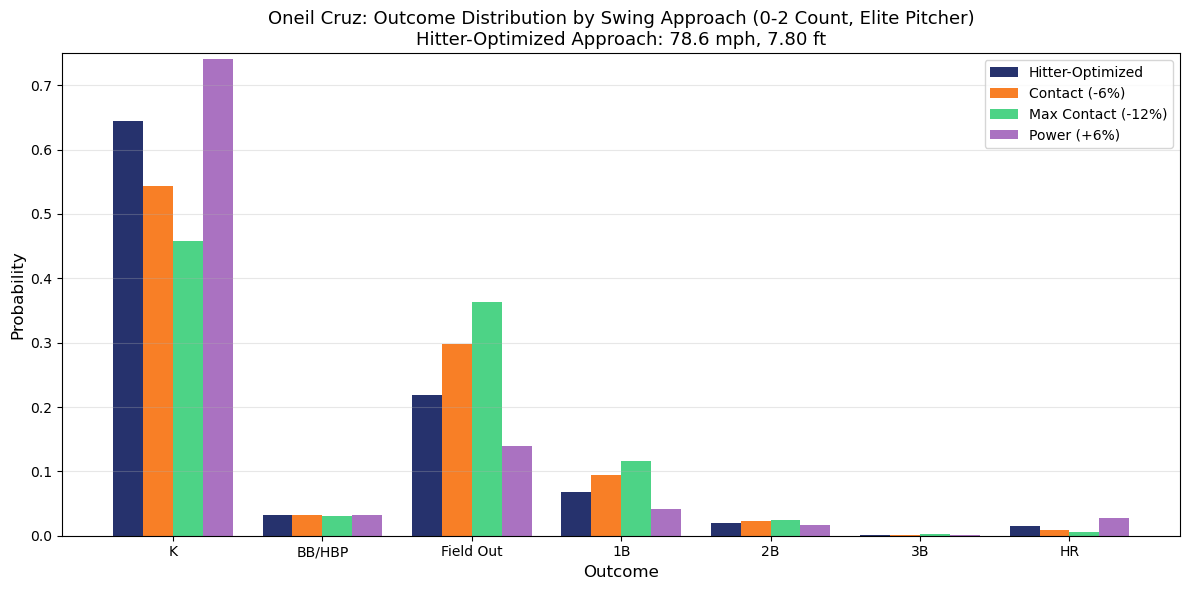

In [4]:
# Outcome Distribution Changes with Bat Speed / Swing Length Adjustments
import json
import arviz as az
from pathlib import Path

BAYES_DIR = Path("Bayes Outcomes")
DATA_DIR = Path("Data")

# Load Bayesian model and scalers
idata = az.from_netcdf(BAYES_DIR / "bayes_outcome_model.nc")
with open(BAYES_DIR / "scalers.json") as f:
    scalers = json.load(f)

# Get player baseline
player = get_player_stats("ONeil Cruz")
print(f"{player['player_name']} ({player['season']})")
print(f"  BS: {player['bat_speed']:.1f} mph, SL: {player['swing_length']:.2f} ft")
print(f"  Z-Contact: {player['z_contact']:.1%}, xISO: {player['xiso']:.3f}")

# Load batter stats for o_swing
batter_stats = pd.read_parquet(DATA_DIR / "batter_stats.parquet")
player_row = batter_stats[(batter_stats["PlayerName"] == player['player_name']) & 
                          (batter_stats["Season"] == player['season'])].iloc[0]
o_swing = player_row["O-Swing_pct"]
print(f"  O-Swing: {o_swing:.1%}")

# Plot settings: elite pitcher, 0-2 count
pitcher_stats = pd.read_parquet(DATA_DIR / "pitcher_stats.parquet")
balls_plot, strikes_plot = 0, 2
xfip_plot = np.nanpercentile(pitcher_stats["xFIP"].dropna(), 10)  # elite pitcher
print(f"  Scenario: Count {balls_plot}-{strikes_plot} vs elite pitcher (xFIP {xfip_plot:.2f})")

# Count dummies order (reference = 0-0)
ALL_COUNT_COLS = [f"count_{b}-{s}" for b in range(4) for s in range(3) if not (b == 0 and s == 0)]

# Define scenarios: (bs_change, sl_change, label)
scenarios = [
    (0, 0, "Hitter-Optimized"),
    (-4.6, -0.45, "Contact (-6%)"),
    (-9.2, -0.9, "Max Contact (-12%)"),
    (+4.6, +0.45, "Power (+6%)"),
]

OUTCOMES = ["K", "BB/HBP", "Field Out", "1B", "2B", "3B", "HR"]

def predict_probs(o_swing, z_contact, xiso, balls=0, strikes=0, xfip=4.0):
    """Predict outcome probs using posterior mean coefficients."""
    post = idata.posterior
    def get_mean(name):
        return post[name].values.mean(axis=(0, 1))
    
    alpha = get_mean("alpha")
    beta_count = get_mean("beta_count")
    beta_o_swing = get_mean("beta_o_swing")
    beta_zc = get_mean("beta_z_contact")
    beta_xi = get_mean("beta_xiso")
    beta_xf = get_mean("beta_xfip")
    
    # Standardize inputs
    o_swing_s = (o_swing - scalers["O-Swing_pct"]["mean"]) / scalers["O-Swing_pct"]["std"]
    zc_s = (z_contact - scalers["Z-Contact_pct"]["mean"]) / scalers["Z-Contact_pct"]["std"]
    xiso_s = (xiso - scalers["xISO"]["mean"]) / scalers["xISO"]["std"]
    xfip_s = (xfip - scalers["xFIP"]["mean"]) / scalers["xFIP"]["std"]
    
    # Build count dummy vector (reference count = 0-0)
    count_str = f"count_{balls}-{strikes}"
    count_X = np.array([1.0 if col == count_str else 0.0 for col in ALL_COUNT_COLS])
    
    logit_mat = alpha + count_X @ beta_count + o_swing_s * beta_o_swing + zc_s * beta_zc + xiso_s * beta_xi + xfip_s * beta_xf
    logit_full = np.concatenate([logit_mat[0:2], [0], logit_mat[2:6]])
    logit_full -= logit_full.max()
    exp_l = np.exp(logit_full)
    return exp_l / exp_l.sum()

# Compute outcome probs for each scenario
results = []
for bs_change, sl_change, label in scenarios:
    if bs_change == 0 and sl_change == 0:
        zc, xiso_val = player['z_contact'], player['xiso']
    else:
        upd = update_stats(player['bat_speed'], player['swing_length'], player['z_contact'], player['xiso'], bs_change, sl_change)
        zc, xiso_val = upd['new_z_contact'], upd['new_xiso']
    
    probs = predict_probs(o_swing, zc, xiso_val, balls_plot, strikes_plot, xfip_plot)
    results.append({'label': label, 'bs_change': bs_change, 'sl_change': sl_change, 
                    'z_contact': zc, 'xiso': xiso_val, 'probs': probs})
    print(f"\n{label} (Count {balls_plot}-{strikes_plot}, elite pitcher): Z-Contact={zc:.1%}, xISO={xiso_val:.3f}")
    for i, outcome in enumerate(OUTCOMES):
        print(f"  {outcome}: {probs[i]:.1%}")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(OUTCOMES))
width = 0.2
colors = ['#000E54', '#F76900', '#2ecc71', '#9b59b6']

for i, (r, color) in enumerate(zip(results, colors)):
    ax.bar(x + i*width - 1.5*width, r['probs'], width, label=r['label'], color=color, alpha=0.85)

ax.set_ylabel('Probability', fontsize=12)
ax.set_xlabel('Outcome', fontsize=12)
ax.set_title(f"{player['player_name']}: Outcome Distribution by Swing Approach (0-2 Count, Elite Pitcher)\n"
             f"Hitter-Optimized Approach: {player['bat_speed']:.1f} mph, {player['swing_length']:.2f} ft", fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(OUTCOMES)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 0.75)

plt.tight_layout()
plt.show()

Outcome Probabilities by Count (League Average Hitter vs League Average Pitcher)

Count   K         BB/HBP    Field Out 1B        2B        3B        HR        
------------------------------------------------------------------------------
0-0     22.0%     9.5%     46.5%     14.5%     4.3%     0.3%     2.9%     
1-0     18.3%     16.1%     44.4%     13.6%     4.3%     0.3%     3.0%     
2-0     14.1%     31.2%     36.6%     11.2%     3.8%     0.3%     2.8%     
3-0     8.4%     64.3%     17.9%     5.9%     2.0%     0.1%     1.4%     
0-1     29.9%     6.1%     43.6%     13.8%     3.9%     0.3%     2.4%     
0-2     44.6%     4.1%     35.2%     11.1%     3.1%     0.2%     1.7%     
1-1     26.9%     10.2%     42.9%     13.3%     3.8%     0.3%     2.5%     
2-2     37.5%     12.9%     33.9%     10.4%     3.0%     0.3%     2.0%     
3-2     27.6%     31.5%     27.6%     8.3%     2.6%     0.2%     2.1%     


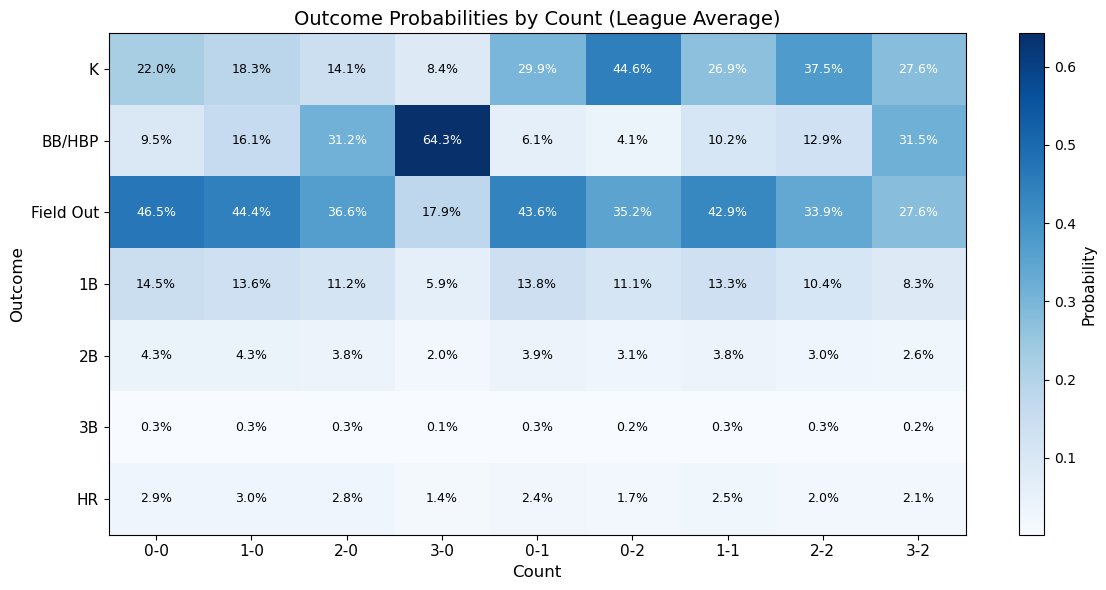

In [5]:
# Outcome Probabilities by Count (League Average)
OUTCOMES = ["K", "BB/HBP", "Field Out", "1B", "2B", "3B", "HR"]

# Count dummies order (reference = 0-0)
ALL_COUNT_COLS = [f"count_{b}-{s}" for b in range(4) for s in range(3) if not (b == 0 and s == 0)]

def predict_probs_by_count(balls, strikes, o_swing, z_contact, xiso, xfip=4.0):
    """Predict outcome probs for a specific count."""
    post = idata.posterior
    def get_mean(name):
        return post[name].values.mean(axis=(0, 1))
    
    alpha = get_mean("alpha")
    beta_count = get_mean("beta_count")
    beta_o_swing = get_mean("beta_o_swing")
    beta_zc = get_mean("beta_z_contact")
    beta_xi = get_mean("beta_xiso")
    beta_xf = get_mean("beta_xfip")
    
    # Standardize inputs
    o_swing_s = (o_swing - scalers["O-Swing_pct"]["mean"]) / scalers["O-Swing_pct"]["std"]
    zc_s = (z_contact - scalers["Z-Contact_pct"]["mean"]) / scalers["Z-Contact_pct"]["std"]
    xiso_s = (xiso - scalers["xISO"]["mean"]) / scalers["xISO"]["std"]
    xfip_s = (xfip - scalers["xFIP"]["mean"]) / scalers["xFIP"]["std"]
    
    # Build count dummy vector
    count_str = f"count_{balls}-{strikes}"
    count_X = np.array([1.0 if col == count_str else 0.0 for col in ALL_COUNT_COLS])
    
    logit_mat = alpha + count_X @ beta_count + o_swing_s * beta_o_swing + zc_s * beta_zc + xiso_s * beta_xi + xfip_s * beta_xf
    logit_full = np.concatenate([logit_mat[0:2], [0], logit_mat[2:6]])
    logit_full -= logit_full.max()
    exp_l = np.exp(logit_full)
    return exp_l / exp_l.sum()

# Use league average stats
avg_o_swing = scalers["O-Swing_pct"]["mean"]
avg_zc = scalers["Z-Contact_pct"]["mean"]
avg_xiso = scalers["xISO"]["mean"]
avg_xfip = scalers["xFIP"]["mean"]

# Define counts to show
counts = [
    (0, 0, "0-0"),
    (1, 0, "1-0"),
    (2, 0, "2-0"),
    (3, 0, "3-0"),
    (0, 1, "0-1"),
    (0, 2, "0-2"),
    (1, 1, "1-1"),
    (2, 2, "2-2"),
    (3, 2, "3-2"),
]

# Compute probs for each count
results = []
for balls, strikes, label in counts:
    probs = predict_probs_by_count(balls, strikes, avg_o_swing, avg_zc, avg_xiso, avg_xfip)
    results.append({'label': label, 'balls': balls, 'strikes': strikes, 'probs': probs})

print("Outcome Probabilities by Count (League Average Hitter vs League Average Pitcher)\n")
print(f"{'Count':<8}" + "".join(f"{o:<10}" for o in OUTCOMES))
print("-" * 78)
for r in results:
    print(f"{r['label']:<8}" + "".join(f"{r['probs'][i]:.1%}     " for i in range(7)))

# Plot - heatmap style
fig, ax = plt.subplots(figsize=(12, 6))

prob_matrix = np.array([r['probs'] for r in results])
count_labels = [r['label'] for r in results]

im = ax.imshow(prob_matrix.T, aspect='auto', cmap='Blues')

ax.set_xticks(range(len(count_labels)))
ax.set_xticklabels(count_labels, fontsize=11)
ax.set_yticks(range(len(OUTCOMES)))
ax.set_yticklabels(OUTCOMES, fontsize=11)

# Add text annotations
for i in range(len(OUTCOMES)):
    for j in range(len(count_labels)):
        val = prob_matrix[j, i]
        color = 'white' if val > 0.25 else 'black'
        ax.text(j, i, f"{val:.1%}", ha='center', va='center', color=color, fontsize=9)

ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Outcome', fontsize=12)
ax.set_title('Outcome Probabilities by Count (League Average)', fontsize=14)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Probability', fontsize=11)

plt.tight_layout()
plt.show()

Oneil Cruz (2025)
  BS: 78.6 mph, SL: 7.80 ft
  Z-Contact: 77.6%, xISO: 0.207
  O-Swing: 30.0%

Contact Approach (-12% BS, -12% SL):
  BS: 69.2 mph, SL: 6.86 ft
  Z-Contact: 89.3%, xISO: 0.062

Pre-State: 2nd & 3rd, 2 out | Bot 8 | Down 1 | WP: 19.5%
Average pitcher xFIP (league mean): 4.18

Count   Baseline WP   Contact WP    Δ WP      
----------------------------------------------
0-0     19.1%        18.9%        -0.24%
1-0     20.1%        19.4%        -0.64%
2-0     21.2%        20.3%        -0.89%
3-0     22.1%        21.7%        -0.45%
0-1     17.2%        17.8%        +0.57%
1-1     18.0%        18.2%        +0.25%
2-1     19.2%        19.0%        -0.22%
3-1     21.2%        20.6%        -0.61%
0-2     14.5%        15.9%        +1.40%
1-2     15.1%        16.3%        +1.20%
2-2     16.1%        16.9%        +0.86%
3-2     18.4%        18.6%        +0.19%


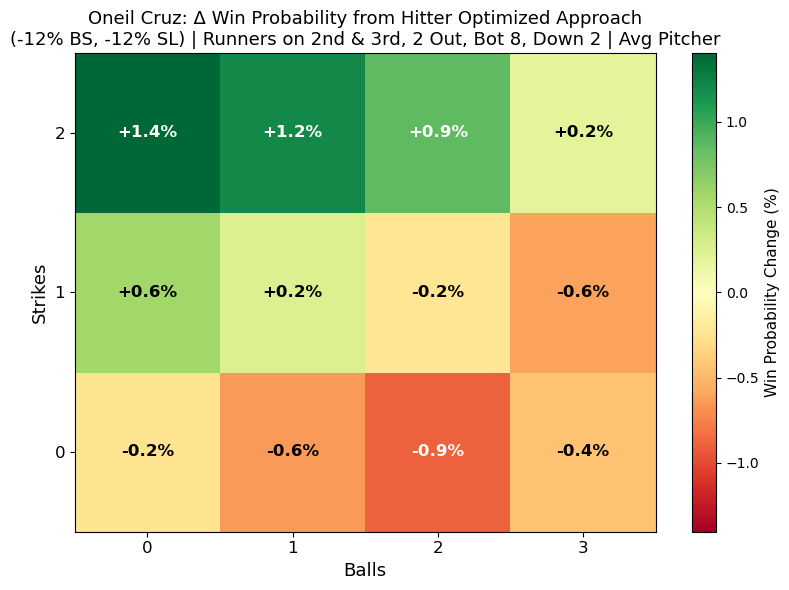

In [140]:
# Matt Olson: Win Probability Change by Count with Contact Approach
# Scenario: 2B-3B, Bot 9, Down 1, 1 Out, -12% BS & SL, Average Pitcher (league xFIP)
import pickle

# Load transition tables
with open(SIM_DIR / "transition_tables.pkl", "rb") as f:
    transition_tables = pickle.load(f)

# Get Matt Olson's stats
olson = get_player_stats("ONeil Cruz")
print(f"{olson['player_name']} ({olson['season']})")
print(f"  BS: {olson['bat_speed']:.1f} mph, SL: {olson['swing_length']:.2f} ft")
print(f"  Z-Contact: {olson['z_contact']:.1%}, xISO: {olson['xiso']:.3f}")

# Get o_swing from batter stats
olson_row = batter_stats[(batter_stats["PlayerName"] == olson['player_name']) & 
                         (batter_stats["Season"] == olson['season'])].iloc[0]
olson_o_swing = olson_row["O-Swing_pct"]
print(f"  O-Swing: {olson_o_swing:.1%}")

# Calculate -12% BS and SL changes
bs_pct_change = -.12
sl_pct_change = -.12
bs_change = olson['bat_speed'] * bs_pct_change
sl_change = olson['swing_length'] * sl_pct_change

# Get updated stats with contact approach
upd = update_stats(olson['bat_speed'], olson['swing_length'], olson['z_contact'], olson['xiso'], bs_change, sl_change)
contact_zc = upd['new_z_contact']
contact_xiso = upd['new_xiso']

print(f"\nContact Approach (-12% BS, -12% SL):")
print(f"  BS: {olson['bat_speed'] + bs_change:.1f} mph, SL: {olson['swing_length'] + sl_change:.2f} ft")
print(f"  Z-Contact: {contact_zc:.1%}, xISO: {contact_xiso:.3f}")

# Scenario parameters
pre_outs = 2
pre_base_state = 6 # 2B-3B
inning = 8
inning_topbot = "Bot"
score_diff = -2  # Down 2

wp_before = lookup_wp(pre_outs, pre_base_state, inning, inning_topbot, score_diff)
print(f"\nPre-State: {BASE_STATE_NAMES[pre_base_state]}, {pre_outs} out | Bot {inning} | Down 1 | WP: {wp_before:.1%}")

# Outcome indices: 0=K, 1=BB/HBP, 2=Field Out, 3=1B, 4=2B, 5=3B, 6=HR
OUTCOME_INDICES = [0, 1, 2, 3, 4, 5, 6]

def compute_expected_wp(outcome_probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff):
    """Compute expected WP after PA given outcome probabilities."""
    total_wp = 0.0
    for outcome_idx, prob in enumerate(outcome_probs):
        if prob < 1e-6:
            continue
        transitions = transition_tables.get((outcome_idx, pre_outs, pre_base_state), 
                                            [(pre_base_state, min(pre_outs+1, 3), 0, 1.0)])
        for post_base, post_outs, runs_scored, trans_prob in transitions:
            new_score_diff = score_diff + runs_scored
            if post_outs >= 3:
                wp_after = 1 - lookup_wp(0, 0, inning + 1, "Top", -new_score_diff)
            else:
                wp_after = lookup_wp(post_outs, post_base, inning, inning_topbot, new_score_diff)
            total_wp += prob * trans_prob * wp_after
    return total_wp

# Define counts to analyze
counts = [
    (0, 0), (1, 0), (2, 0), (3, 0),
    (0, 1), (1, 1), (2, 1), (3, 1),
    (0, 2), (1, 2), (2, 2), (3, 2),
]


# Use league-average pitcher explicitly for this scenario
scenario_xfip = scalers["xFIP"]["mean"]
print(f"Average pitcher xFIP (league mean): {scenario_xfip:.2f}")

# Compute WP for baseline and contact approach by count
results = []
for balls, strikes in counts:
    # Baseline outcome probs
    baseline_probs = predict_probs_by_count(balls, strikes, olson_o_swing, olson['z_contact'], olson['xiso'], scenario_xfip)
    baseline_wp = compute_expected_wp(baseline_probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff)
    
    # Contact approach outcome probs
    contact_probs = predict_probs_by_count(balls, strikes, olson_o_swing, contact_zc, contact_xiso, scenario_xfip)
    contact_wp = compute_expected_wp(contact_probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff)
    
    wp_diff = contact_wp - baseline_wp
    
    results.append({
        'balls': balls, 'strikes': strikes, 'label': f"{balls}-{strikes}",
        'baseline_wp': baseline_wp, 'contact_wp': contact_wp, 'wp_diff': wp_diff,
        'baseline_probs': baseline_probs, 'contact_probs': contact_probs,
    })

# Print results table
print(f"\n{'Count':<8}{'Baseline WP':<14}{'Contact WP':<14}{'Δ WP':<10}")
print("-" * 46)
for r in results:
    print(f"{r['label']:<8}{r['baseline_wp']:.1%}        {r['contact_wp']:.1%}        {r['wp_diff']:+.2%}")

# Create grid for heatmap (4 balls x 3 strikes)
wp_diff_grid = np.full((3, 4), np.nan)  # strikes x balls
for r in results:
    wp_diff_grid[r['strikes'], r['balls']] = r['wp_diff'] * 100  # Convert to percentage points

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 6))

# Create diverging colormap centered at 0
vmax = np.nanmax(np.abs(wp_diff_grid))
im = ax.imshow(wp_diff_grid, cmap='RdYlGn', vmin=-vmax, vmax=vmax, aspect='auto', origin='lower')

# Labels
ax.set_xticks(range(4))
ax.set_xticklabels(['0', '1', '2', '3'], fontsize=12)
ax.set_yticks(range(3))
ax.set_yticklabels(['0', '1', '2'], fontsize=12)
ax.set_xlabel('Balls', fontsize=13)
ax.set_ylabel('Strikes', fontsize=13)

# Add text annotations
for i in range(3):
    for j in range(4):
        val = wp_diff_grid[i, j]
        if not np.isnan(val):
            color = 'white' if abs(val) > vmax * 0.5 else 'black'
            ax.text(j, i, f"{val:+.1f}%", ha='center', va='center', color=color, fontsize=12, fontweight='bold')

ax.set_title(f"{olson['player_name']}: Δ Win Probability from Hitter Optimized Approach\n"
             f"(-12% BS, -12% SL) | Runners on 2nd & 3rd, 2 Out, Bot 8, Down 2 | Avg Pitcher", fontsize=13)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Win Probability Change (%)', fontsize=11)

plt.tight_layout()
plt.show()

Fixed Count: 1-1

xFIP    Baseline WP   Contact WP    Δ WP      
----------------------------------------------
2.5     15.4%        16.5%        +1.09%
3.0     16.2%        17.0%        +0.87%
3.5     16.9%        17.5%        +0.63%
4.0     17.7%        18.0%        +0.35%
4.5     18.5%        18.5%        +0.06%
5.0     19.2%        19.0%        -0.26%
5.5     20.0%        19.4%        -0.59%
6.0     20.8%        19.9%        -0.93%


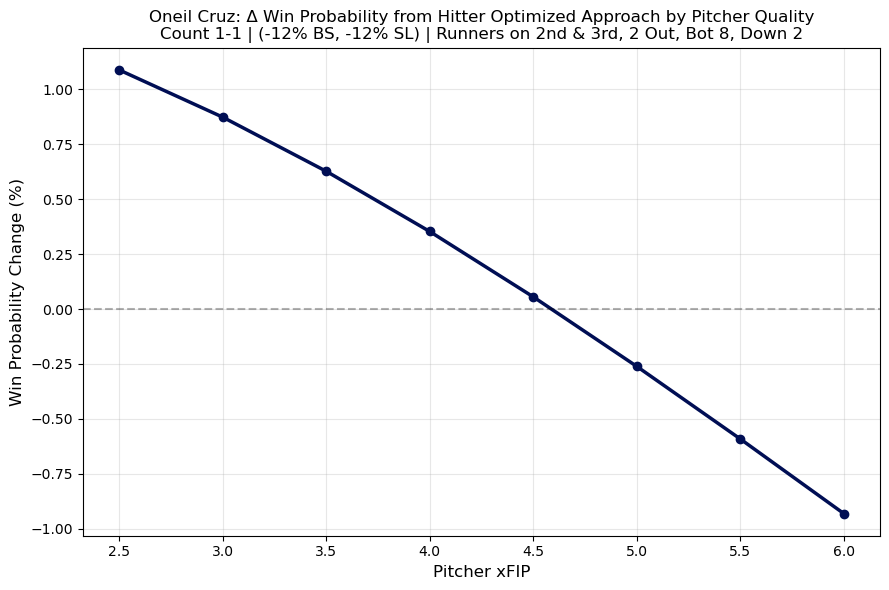

In [141]:
# Matt Olson: Win Probability Change by Pitcher Quality with Contact Approach
# Same scenario/contact approach as above, but sweep pitcher quality (xFIP) at a fixed count
balls = 1
strikes = 1
xfip_values = np.arange(2.5, 6.5, 0.5)

pitcher_quality_results = []
for xfip in xfip_values:
    baseline_probs = predict_probs_by_count(
        balls, strikes, olson_o_swing, olson['z_contact'], olson['xiso'], xfip=xfip
    )
    baseline_wp = compute_expected_wp(baseline_probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff)

    contact_probs = predict_probs_by_count(
        balls, strikes, olson_o_swing, contact_zc, contact_xiso, xfip=xfip
    )
    contact_wp = compute_expected_wp(contact_probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff)

    pitcher_quality_results.append({
        'xfip': float(xfip),
        'baseline_wp': float(baseline_wp),
        'contact_wp': float(contact_wp),
        'wp_diff': float(contact_wp - baseline_wp),
    })

print(f"Fixed Count: {balls}-{strikes}\n")
print(f"{'xFIP':<8}{'Baseline WP':<14}{'Contact WP':<14}{'Δ WP':<10}")
print('-' * 46)
for r in pitcher_quality_results:
    print(f"{r['xfip']:<8.1f}{r['baseline_wp']:.1%}        {r['contact_wp']:.1%}        {r['wp_diff']:+.2%}")

x = [r['xfip'] for r in pitcher_quality_results]
baseline_wp_pp = [r['baseline_wp'] * 100 for r in pitcher_quality_results]
contact_wp_pp = [r['contact_wp'] * 100 for r in pitcher_quality_results]
wp_diff_pp = [r['wp_diff'] * 100 for r in pitcher_quality_results]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x, wp_diff_pp, color='#000E54', linewidth=2.5, marker='o')
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Pitcher xFIP', fontsize=12)
ax.set_ylabel('Win Probability Change (%)', fontsize=12)
ax.set_title(
    f"{olson['player_name']}: Δ Win Probability from Hitter Optimized Approach by Pitcher Quality\n"
    f"Count {balls}-{strikes} | (-12% BS, -12% SL) | Runners on 2nd & 3rd, 2 Out, Bot 8, Down 2"
)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [142]:
# Build flow_outcomes data structure for the detailed flowmap
# Uses the Matt Olson scenario from previous cells

OUTCOME_NAMES = ["Strikeout", "Walk", "Field Out", "Single", "Double", "Triple", "Home Run"]

# Display-friendly base state names
BASE_STATE_DISPLAY = {
    0: "Bases Empty", 
    1: "Runner on 1st", 
    2: "Runner on 2nd", 
    3: "Runners on 1st & 2nd", 
    4: "Runner on 3rd", 
    5: "Runners on 1st & 3rd", 
    6: "Runners on 2nd & 3rd", 
    7: "Bases Loaded"
}

# Configuration
use_contact_approach = True  # True = contact approach, False = baseline
min_post_trans_prob = 0.01   # Only show post-states with >= 1% conditional probability
xfip = 4.0                   # Pitcher quality

# Get outcome probabilities based on approach
if use_contact_approach:
    outcome_probs = predict_probs_by_count(balls, strikes, olson_o_swing, contact_zc, contact_xiso, xfip=xfip)
else:
    outcome_probs = predict_probs_by_count(balls, strikes, olson_o_swing, olson['z_contact'], olson['xiso'], xfip=xfip)

# Build flow_outcomes structure
flow_outcomes = []
all_post_delta_vals = []

for outcome_idx, (outcome_name, outcome_prob) in enumerate(zip(OUTCOME_NAMES, outcome_probs)):
    # Get transitions for this outcome
    transitions = transition_tables.get(
        (outcome_idx, pre_outs, pre_base_state),
        [(pre_base_state, min(pre_outs + 1, 3), 0, 1.0)]
    )
    
    post_rows = []
    cond_exp_delta = 0.0
    
    for post_base, post_outs, runs_scored, trans_prob in transitions:
        new_score_diff = score_diff + runs_scored
        
        # Calculate WP after this transition
        if post_outs >= 3:
            wp_after = 1 - lookup_wp(0, 0, inning + 1, "Top", -new_score_diff)
        else:
            wp_after = lookup_wp(post_outs, post_base, inning, inning_topbot, new_score_diff)
        
        delta_wp = wp_after - wp_before
        joint_prob = outcome_prob * trans_prob
        
        post_rows.append({
            'post_base': post_base,
            'post_outs': post_outs,
            'runs_scored': runs_scored,
            'trans_prob': trans_prob,
            'joint_prob': joint_prob,
            'wp_after': wp_after,
            'delta_wp': delta_wp,
        })
        
        cond_exp_delta += trans_prob * delta_wp
        all_post_delta_vals.append(delta_wp)
    
    # Filter to show only transitions above threshold
    post_rows_display = [p for p in post_rows if p['trans_prob'] >= min_post_trans_prob]
    
    flow_outcomes.append({
        'outcome_idx': outcome_idx,
        'outcome_name': outcome_name,
        'outcome_prob': outcome_prob,
        'cond_exp_delta': cond_exp_delta,
        'post_rows': post_rows,
        'post_rows_display': post_rows_display,
    })

# Calculate expected values
expected_wp_after = sum(
    out['outcome_prob'] * sum(p['trans_prob'] * p['wp_after'] for p in out['post_rows'])
    for out in flow_outcomes
)
expected_delta_wp = expected_wp_after - wp_before

print(f"Scenario: {BASE_STATE_DISPLAY[pre_base_state]}, {pre_outs} out | {inning_topbot} {inning} | Score diff: {score_diff:+d}")
print(f"Approach: {'Contact' if use_contact_approach else 'Baseline'}")
print(f"Count: {balls}-{strikes} | xFIP: {xfip}")
print(f"\nWP Before: {wp_before:.1%}")
print(f"Expected WP After: {expected_wp_after:.1%}")
print(f"Expected Delta WP: {expected_delta_wp:+.2%}")
print(f"\nOutcome breakdown:")
for out in flow_outcomes:
    print(f"  {out['outcome_name']}: {out['outcome_prob']:.1%} | E[ΔWP|outcome]: {out['cond_exp_delta']:+.2%}")

Scenario: Runners on 2nd & 3rd, 2 out | Bot 8 | Score diff: -2
Approach: Contact
Count: 1-1 | xFIP: 4.0

WP Before: 19.5%
Expected WP After: 18.0%
Expected Delta WP: -1.49%

Outcome breakdown:
  Strikeout: 23.8% | E[ΔWP|outcome]: -11.67%
  Walk: 8.8% | E[ΔWP|outcome]: +3.65%
  Field Out: 47.5% | E[ΔWP|outcome]: -11.66%
  Single: 15.1% | E[ΔWP|outcome]: +28.86%
  Double: 3.4% | E[ΔWP|outcome]: +38.23%
  Triple: 0.3% | E[ΔWP|outcome]: +39.43%
  Home Run: 1.1% | E[ΔWP|outcome]: +64.75%


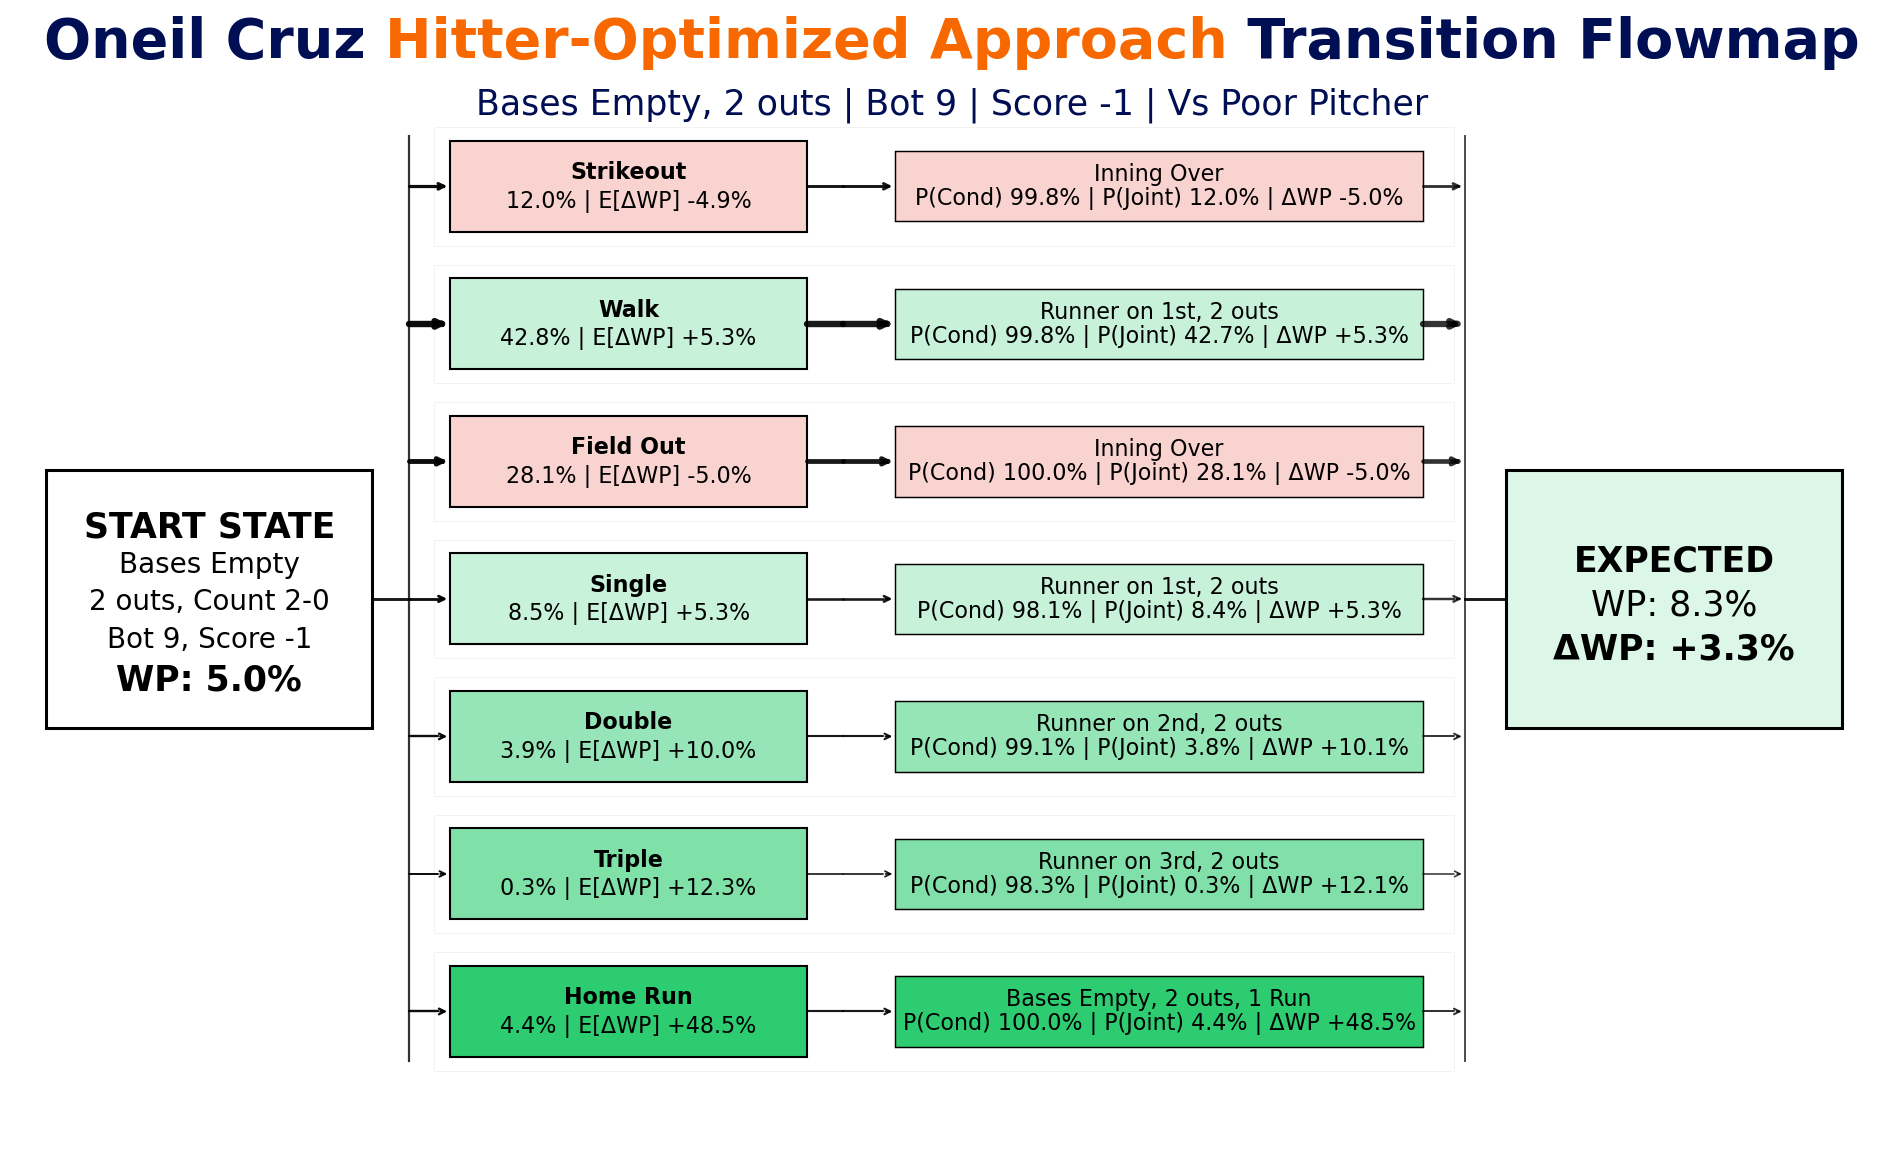

{'wp_before': 0.049526069313287735,
 'expected_wp_after': np.float64(0.08254297949111006),
 'expected_delta_wp': np.float64(0.03301691017782232),
 'flow_outcomes': [{'outcome_idx': 0,
   'outcome_name': 'Strikeout',
   'outcome_prob': np.float64(0.1202105516340787),
   'cond_exp_delta': -0.04931771705731685,
   'post_rows': [{'post_base': 0,
     'post_outs': 3,
     'runs_scored': 0,
     'trans_prob': 0.9979683267347365,
     'joint_prob': np.float64(0.11996632307012116),
     'wp_after': 0.0,
     'delta_wp': -0.049526069313287735},
    {'post_base': 1,
     'post_outs': 2,
     'runs_scored': 0,
     'trans_prob': 0.0020316732652635966,
     'joint_prob': np.float64(0.0002442285639575469),
     'wp_after': 0.10255204886198044,
     'delta_wp': 0.0530259795486927}],
   'post_rows_display': [{'post_base': 0,
     'post_outs': 3,
     'runs_scored': 0,
     'trans_prob': 0.9979683267347365,
     'joint_prob': np.float64(0.11996632307012116),
     'wp_after': 0.0,
     'delta_wp': -0.0

In [ ]:
# --- FLOWMAP FUNCTION ---

from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgb
from matplotlib.offsetbox import TextArea, HPacker, AnnotationBbox


def compute_wp_after(post_outs, post_base, runs_scored, inning, inning_topbot, score_diff):
    """
    Compute win probability after a transition, handling walk-offs and game-ending scenarios.
    
    Parameters
    ----------
    post_outs : int
        Outs after the play
    post_base : int
        Base state after the play
    runs_scored : int
        Runs scored on the play
    inning : int
        Current inning
    inning_topbot : str
        "Top" or "Bot"
    score_diff : int
        Score differential BEFORE runs scored (from batting team's perspective)
    
    Returns
    -------
    float
        Win probability after the transition
    """
    new_score_diff = score_diff + runs_scored
    
    if post_outs >= 3:
        # Inning is over - check for game-ending conditions
        if inning_topbot == "Bot" and inning >= 9:
            # End of bottom 9th or later
            if new_score_diff > 0:
                # Home team ahead - they win
                return 1.0
            elif new_score_diff < 0:
                # Home team behind - they lose
                return 0.0
            else:
                # Tied - extra innings
                return 1 - lookup_wp(0, 0, min(inning + 1, 9), "Top", -new_score_diff)
        elif inning_topbot == "Top":
            # End of top half - bottom half coming up
            return 1 - lookup_wp(0, 0, inning, "Bot", -new_score_diff)
        else:
            # End of bottom half (innings 1-8) - top of next inning
            return 1 - lookup_wp(0, 0, inning + 1, "Top", -new_score_diff)
    else:
        # Same half-inning continues
        # Check for walk-off: bottom 9+ and home team takes the lead
        if inning >= 9 and inning_topbot == "Bot" and score_diff <= 0 and new_score_diff > 0:
            # Walk-off! Home team wins immediately
            return 1.0
        else:
            return lookup_wp(post_outs, post_base, inning, inning_topbot, new_score_diff)


def plot_transition_flowmap(
    player_name,
    pre_outs,
    pre_base_state,
    inning,
    inning_topbot,
    score_diff,
    balls,
    strikes,
    use_contact_approach=True,
    xfip=4.0,
    min_post_trans_prob=0.01
):
    """
    Plot a transition flowmap showing outcome probabilities and win probability changes.
    
    Parameters
    ----------
    player_name : str
        Name of the player (e.g., "Matt Olson")
    pre_outs : int
        Number of outs before the PA (0, 1, or 2)
    pre_base_state : int
        Base state encoding (0=empty, 1=1B, 2=2B, 3=1B-2B, 4=3B, 5=1B-3B, 6=2B-3B, 7=loaded)
    inning : int
        Inning number
    inning_topbot : str
        "Top" or "Bot"
    score_diff : int
        Score differential from batting team perspective (negative = losing)
    balls : int
        Ball count (0-3)
    strikes : int
        Strike count (0-2)
    use_contact_approach : bool
        If True, use contact approach stats; if False, use baseline stats
    xfip : float
        Pitcher xFIP (default 4.0 = league average)
    min_post_trans_prob : float
        Minimum transition probability to display (default 0.01 = 1%)
    """
    
    # Load transition tables
    with open(SIM_DIR / "transition_tables.pkl", "rb") as f:
        transition_tables = pickle.load(f)
    
    # Get player stats
    player = get_player_stats(player_name)
    player_row = batter_stats[(batter_stats["PlayerName"] == player['player_name']) & 
                              (batter_stats["Season"] == player['season'])].iloc[0]
    player_o_swing = player_row["O-Swing_pct"]
    
    # Calculate contact approach stats if needed
    if use_contact_approach:
        bs_pct_change = -0.12
        sl_pct_change = -0.12
        bs_change = player['bat_speed'] * bs_pct_change
        sl_change = player['swing_length'] * sl_pct_change
        upd = update_stats(player['bat_speed'], player['swing_length'], player['z_contact'], player['xiso'], bs_change, sl_change)
        player_zc = upd['new_z_contact']
        player_xiso = upd['new_xiso']
    else:
        player_zc = player['z_contact']
        player_xiso = player['xiso']
    
    # Get outcome probabilities
    outcome_probs = predict_probs_by_count(balls, strikes, player_o_swing, player_zc, player_xiso, xfip=xfip)
    
    # Outcome and base state names
    OUTCOME_NAMES = ["Strikeout", "Walk", "Field Out", "Single", "Double", "Triple", "Home Run"]
    BASE_STATE_DISPLAY = {
        0: "Bases Empty", 1: "Runner on 1st", 2: "Runner on 2nd", 3: "Runners on 1st & 2nd",
        4: "Runner on 3rd", 5: "Runners on 1st & 3rd", 6: "Runners on 2nd & 3rd", 7: "Bases Loaded"
    }
    
    # Helper functions
    def _delta_fill_color(delta_wp):
        fixed_scale = 0.20
        delta_clipped = max(-fixed_scale, min(fixed_scale, delta_wp))
        normalized = delta_clipped / fixed_scale
        red = to_rgb('#e74c3c')
        white = (1.0, 1.0, 1.0)
        green = to_rgb('#2ecc71')
        if normalized >= 0:
            return tuple(w + normalized * (g - w) for w, g in zip(white, green))
        else:
            t = abs(normalized)
            return tuple(w + t * (r - w) for w, r in zip(white, red))
    
    def outs_text(n):
        if n >= 3:
            return "Inning Over"
        return f"{n} out" if n == 1 else f"{n} outs"
    
    def runs_text(n):
        if n == 0:
            return ""
        return f"{n} Run" if n == 1 else f"{n} Runs"
    
    def draw_elbow(ax, x0, y0, x1, y1, x_elbow=None, color='black', alpha=0.9, lw=1.3, arrow_at_end=True):
        if x_elbow is None:
            x_elbow = (x0 + x1) / 2
        ax.plot([x0, x_elbow], [y0, y0], color=color, alpha=alpha, lw=lw, solid_capstyle='round')
        ax.plot([x_elbow, x_elbow], [y0, y1], color=color, alpha=alpha, lw=lw, solid_capstyle='round')
        if arrow_at_end:
            ax.plot([x_elbow, x1 - 0.12], [y1, y1], color=color, alpha=alpha, lw=lw, solid_capstyle='round')
            ax.annotate('', xy=(x1, y1), xytext=(x1 - 0.12, y1),
                        arrowprops=dict(arrowstyle='->', color=color, alpha=alpha, lw=max(1.1, lw)))
        else:
            ax.plot([x_elbow, x1], [y1, y1], color=color, alpha=alpha, lw=lw, solid_capstyle='round')
    
    # Get WP before
    wp_before = lookup_wp(pre_outs, pre_base_state, inning, inning_topbot, score_diff)
    
    # Build flow_outcomes structure
    flow_outcomes = []
    all_post_delta_vals = []
    
    for outcome_idx, (outcome_name, outcome_prob) in enumerate(zip(OUTCOME_NAMES, outcome_probs)):
        transitions = transition_tables.get(
            (outcome_idx, pre_outs, pre_base_state),
            [(pre_base_state, min(pre_outs + 1, 3), 0, 1.0)]
        )
        
        post_rows = []
        cond_exp_delta = 0.0
        
        for post_base, post_outs, runs_scored, trans_prob in transitions:
            # Use the new walk-off aware function
            wp_after = compute_wp_after(
                post_outs, post_base, runs_scored, 
                inning, inning_topbot, score_diff
            )
            
            delta_wp = wp_after - wp_before
            joint_prob = outcome_prob * trans_prob
            
            post_rows.append({
                'post_base': post_base, 'post_outs': post_outs, 'runs_scored': runs_scored,
                'trans_prob': trans_prob, 'joint_prob': joint_prob, 'wp_after': wp_after, 'delta_wp': delta_wp,
            })
            cond_exp_delta += trans_prob * delta_wp
            all_post_delta_vals.append(delta_wp)
        
        post_rows_display = [p for p in post_rows if p['trans_prob'] >= min_post_trans_prob]
        flow_outcomes.append({
            'outcome_idx': outcome_idx, 'outcome_name': outcome_name, 'outcome_prob': outcome_prob,
            'cond_exp_delta': cond_exp_delta, 'post_rows': post_rows, 'post_rows_display': post_rows_display,
        })
    
    # Calculate expected values
    expected_wp_after = sum(
        out['outcome_prob'] * sum(p['trans_prob'] * p['wp_after'] for p in out['post_rows'])
        for out in flow_outcomes
    )
    expected_delta_wp = expected_wp_after - wp_before
    
    # ===== Layout =====
    band_gap = 0.30
    inner_pad = 0.22
    post_gap = 0.18
    outcome_box_h = 1.45
    post_box_h = 1.12
    min_band_h = 1.85
    top_margin = 1.35
    bottom_margin = 1.15
    
    band_heights = []
    for out in flow_outcomes:
        n_posts = max(1, len(out['post_rows_display']))
        post_stack_h = n_posts * post_box_h + (n_posts - 1) * post_gap
        content_h = max(outcome_box_h, post_stack_h)
        band_h = max(min_band_h, content_h + 2 * inner_pad)
        band_heights.append(band_h)
    
    y_max = top_margin + bottom_margin + sum(band_heights) + band_gap * (len(band_heights) - 1)
    
    y_centers = []
    cursor = y_max - top_margin
    for i, bh in enumerate(band_heights):
        y_centers.append(cursor - bh / 2)
        cursor -= bh
        if i < len(band_heights) - 1:
            cursor -= band_gap
    
    y_mid = float(np.mean(y_centers))
    
    fig_h = max(11.5, 0.62 * y_max)
    fig, ax = plt.subplots(figsize=(21, fig_h))
    ax.set_xlim(0, 18.2)
    ax.set_ylim(0, y_max)
    ax.axis('off')
    
    # Positions
    x_start, w_start, h_start = 0.35, 3.15, 4.10
    x_left_bus = 3.85
    x_out, w_out, h_out = 4.25, 3.45, outcome_box_h
    x_mid_bus = 8.05
    x_post, w_post, h_post = 8.55, 5.10, post_box_h
    x_right_bus = 14.05
    x_final, w_final, h_final = 14.45, 3.25, 4.10
    
    fs_title, fs_subtitle = 35, 25
    fs_start_hdr, fs_start, fs_start_bold = 25, 20, 25
    fs_final_hdr, fs_final, fs_final_bold = 25, 25, 25
    fs_outcome_name, fs_outcome_meta, fs_post = 16, 16, 16
    
    # ===== Start node =====
    ax.add_patch(Rectangle((x_start, y_mid - h_start/2), w_start, h_start,
                           facecolor='white', edgecolor='black', lw=2.2))
    ax.text(x_start + w_start/2, y_mid + 1.15, 'START STATE', ha='center', va='center',
            fontsize=fs_start_hdr, fontweight='bold')
    ax.text(x_start + w_start/2, y_mid + 0.55,
            f"{BASE_STATE_DISPLAY[pre_base_state]}", ha='center', va='center', fontsize=fs_start)
    ax.text(x_start + w_start/2, y_mid - 0.05,
            f"{outs_text(pre_outs)}, Count {balls}-{strikes}", ha='center', va='center', fontsize=fs_start)
    ax.text(x_start + w_start/2, y_mid - 0.65,
            f"{inning_topbot} {inning}, Score {score_diff:+d}", ha='center', va='center', fontsize=fs_start)
    ax.text(x_start + w_start/2, y_mid - 1.30,
            f"WP: {wp_before:.1%}", ha='center', va='center', fontsize=fs_start_bold, fontweight='bold')
    
    # ===== Final node =====
    final_fill = _delta_fill_color(expected_delta_wp)
    ax.add_patch(Rectangle((x_final, y_mid - h_final/2), w_final, h_final,
                           facecolor=final_fill, edgecolor='black', lw=2.2))
    ax.text(x_final + w_final/2, y_mid + 0.6, 'EXPECTED', ha='center', va='center',
            fontsize=fs_final_hdr, fontweight='bold', color='black')
    ax.text(x_final + w_final/2, y_mid - 0.1,
            f"WP: {expected_wp_after:.1%}", ha='center', va='center', fontsize=fs_final, color='black')
    ax.text(x_final + w_final/2, y_mid - 0.8,
            f"ΔWP: {expected_delta_wp:+.1%}", ha='center', va='center',
            fontsize=fs_final_bold, fontweight='bold', color='black')
    
    # ===== Trunk connectors =====
    y_top_extent = max(y_centers[i] + band_heights[i]/2 for i in range(len(y_centers)))
    y_bot_extent = min(y_centers[i] - band_heights[i]/2 for i in range(len(y_centers)))
    
    ax.plot([x_start + w_start, x_left_bus], [y_mid, y_mid], color='black', alpha=0.9, lw=2.1)
    ax.plot([x_left_bus, x_left_bus], [y_bot_extent + 0.15, y_top_extent - 0.15], color='black', alpha=0.8, lw=1.6)
    ax.plot([x_right_bus, x_final], [y_mid, y_mid], color='black', alpha=0.9, lw=2.1)
    ax.plot([x_right_bus, x_right_bus], [y_bot_extent + 0.15, y_top_extent - 0.15], color='black', alpha=0.7, lw=1.4)
    
    # ===== Draw outcomes and post-states =====
    for y0, band_h, out_row in zip(y_centers, band_heights, flow_outcomes):
        p_out = out_row['outcome_prob']
        outcome_fill = _delta_fill_color(out_row['cond_exp_delta'])
        
        ax.add_patch(Rectangle((4.10, y0 - band_h/2), 9.85, band_h,
                               facecolor=(0, 0, 0, 0), edgecolor=(0.85, 0.85, 0.85, 0.35), lw=0.7))
        
        lw_start_to_out = 1.4 + 7.5 * p_out
        ax.plot([x_left_bus, x_out - 0.12], [y0, y0], color='black', alpha=0.95, lw=lw_start_to_out, solid_capstyle='round')
        ax.annotate('', xy=(x_out, y0), xytext=(x_out - 0.12, y0),
                    arrowprops=dict(arrowstyle='->', color='black', alpha=0.95, lw=max(1.2, lw_start_to_out)))
        
        ax.add_patch(Rectangle((x_out, y0 - h_out/2), w_out, h_out,
                               facecolor=outcome_fill, edgecolor='black', lw=1.5))
        ax.text(x_out + w_out/2, y0 + 0.22, out_row['outcome_name'],
                ha='center', va='center', fontsize=fs_outcome_name, fontweight='bold')
        ax.text(x_out + w_out/2, y0 - 0.23,
                f"{p_out:.1%} | E[ΔWP] {out_row['cond_exp_delta']:+.1%}",
                ha='center', va='center', fontsize=fs_outcome_meta)
        
        posts = out_row['post_rows_display']
        if len(posts) == 0:
            continue
        
        n_posts = len(posts)
        if n_posts == 1:
            post_ys = [y0]
        else:
            usable_h = band_h - 2 * inner_pad
            top_y = y0 + usable_h / 2 - h_post / 2
            bot_y = y0 - usable_h / 2 + h_post / 2
            post_ys = np.linspace(top_y, bot_y, n_posts)
        
        x_local_elbow = x_mid_bus
        
        for yp, post in zip(post_ys, posts):
            if post['post_outs'] >= 3:
                state_text = "Inning Over"
            else:
                state_text = f"{BASE_STATE_DISPLAY[post['post_base']]}, {outs_text(post['post_outs'])}"
            if post['runs_scored'] > 0:
                state_text += f", {runs_text(post['runs_scored'])}"
            
            # Mark walk-offs
            is_walkoff = (inning >= 9 and inning_topbot == "Bot" and 
                         score_diff <= 0 and (score_diff + post['runs_scored']) > 0)
            if is_walkoff:
                state_text += " WALK-OFF!"
            
            meta_text = f"P(Cond) {post['trans_prob']:.1%} | P(Joint) {post['joint_prob']:.1%} | ΔWP {post['delta_wp']:+.1%}"
            
            post_fill = _delta_fill_color(post['delta_wp'])
            ax.add_patch(Rectangle((x_post, yp - h_post/2), w_post, h_post,
                                   facecolor=post_fill, edgecolor='black', lw=1.05))
            ax.text(x_post + w_post/2, yp, f"{state_text}\n{meta_text}",
                    ha='center', va='center', fontsize=fs_post, linespacing=1.05)
            
            lw_op = 1.2 + 8.0 * post['joint_prob']
            draw_elbow(ax, x_out + w_out, y0, x_post, yp, x_elbow=x_local_elbow,
                       color='black', alpha=0.9, lw=lw_op, arrow_at_end=True)
            
            lw_pf = 1.1 + 8.0 * post['joint_prob']
            ax.plot([x_post + w_post, x_right_bus - 0.10], [yp, yp],
                    color='black', alpha=0.8, lw=lw_pf, solid_capstyle='round')
            ax.annotate('', xy=(x_right_bus, yp), xytext=(x_right_bus - 0.10, yp),
                        arrowprops=dict(arrowstyle='->', color='black', alpha=0.8, lw=max(1.1, lw_pf)))
    
    # ===== Titles =====
    title_suffix = 'Win-Creation Approach' if use_contact_approach else 'Hitter-Optimized Approach'

    title_blue = "#000E54"
    title_orange = "#F76900"

    left_txt = TextArea(
        f"{player['player_name']} ",
        textprops=dict(color=title_blue, fontsize=40, fontweight="bold")
    )

    mid_txt = TextArea(
        f"{title_suffix}",
        textprops=dict(color=title_orange, fontsize=40, fontweight="bold")
    )

    right_txt = TextArea(
        " Transition Flowmap",
        textprops=dict(color=title_blue, fontsize=40, fontweight="bold")
    )

    packed_title = HPacker(
        children=[left_txt, mid_txt, right_txt],
        align="center",
        pad=0,
        sep=0
    )

    ab = AnnotationBbox(
        packed_title,
        (9.1, y_max),         
        xycoords="data",
        frameon=False,
        box_alignment=(0.5, 0.5)
    )

    ax.add_artist(ab)
    ax.text(9.1, y_max - 1.00,
            f"{BASE_STATE_DISPLAY[pre_base_state]}, {outs_text(pre_outs)} | {inning_topbot} {inning} | Score {score_diff:+d} | Vs Poor Pitcher",
            ha='center', va='center', fontsize=25, color=title_blue)
    
    plt.tight_layout(pad=0.6)
    plt.show()
    
    return {
        'wp_before': wp_before,
        'expected_wp_after': expected_wp_after,
        'expected_delta_wp': expected_delta_wp,
        'flow_outcomes': flow_outcomes,
    }


# Example usage:
plot_transition_flowmap(
    player_name="Oneil Cruz",
    pre_outs=2,
    pre_base_state=0,  
    inning=9,
    inning_topbot="Bot",
    score_diff=-1,
    balls=2,
    strikes=0,
    use_contact_approach=False,
    xfip=6
)

Oneil Cruz (2025)
  Baseline BS: 78.6 mph, SL: 7.80 ft
  Baseline Z-Contact: 77.6%, xISO: 0.207


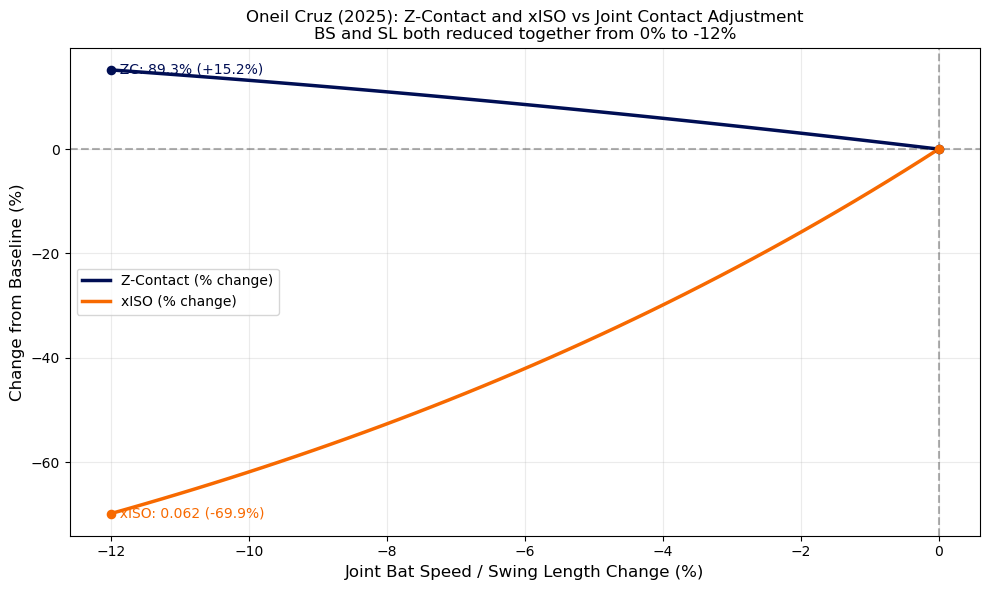

In [12]:
# ONeil Cruz: Z-Contact and xISO vs Joint BS/SL Reduction
cruz = get_player_stats("ONeil Cruz")
print(f"{cruz['player_name']} ({cruz['season']})")
print(f"  Baseline BS: {cruz['bat_speed']:.1f} mph, SL: {cruz['swing_length']:.2f} ft")
print(f"  Baseline Z-Contact: {cruz['z_contact']:.1%}, xISO: {cruz['xiso']:.3f}")

joint_pct_changes = np.linspace(0.0, -0.12, 50)  # 0% to -12% applied to both BS and SL
x_vals = joint_pct_changes * 100
zc_pct_changes = []
xiso_pct_changes = []
zc_levels = []
xiso_levels = []

for pct in joint_pct_changes:
    bs_change = cruz['bat_speed'] * pct
    sl_change = cruz['swing_length'] * pct
    result = update_stats(
        current_bat_speed=cruz['bat_speed'],
        current_swing_length=cruz['swing_length'],
        current_z_contact=cruz['z_contact'],
        current_xiso=cruz['xiso'],
        bat_speed_change=bs_change,
        swing_length_change=sl_change,
    )
    zc_levels.append(result['new_z_contact'])
    xiso_levels.append(result['new_xiso'])
    zc_pct_changes.append((result['new_z_contact'] / cruz['z_contact'] - 1) * 100)
    xiso_pct_changes.append((result['new_xiso'] / cruz['xiso'] - 1) * 100)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_vals, zc_pct_changes, color='#000E54', linewidth=2.5, label='Z-Contact (% change)')
ax.plot(x_vals, xiso_pct_changes, color='#F76900', linewidth=2.5, label='xISO (% change)')
ax.scatter([x_vals[0], x_vals[-1]], [zc_pct_changes[0], zc_pct_changes[-1]], color='#000E54', s=35, zorder=3)
ax.scatter([x_vals[0], x_vals[-1]], [xiso_pct_changes[0], xiso_pct_changes[-1]], color='#F76900', s=35, zorder=3)
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.axvline(0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Joint Bat Speed / Swing Length Change (%)', fontsize=12)
ax.set_ylabel('Change from Baseline (%)', fontsize=12)
ax.set_title(
    f"{cruz['player_name']} ({cruz['season']}): Z-Contact and xISO vs Joint Contact Adjustment\n"
    f"BS and SL both reduced together from 0% to -12%"
)
ax.grid(True, alpha=0.25)
ax.legend(loc='best')

# Endpoint annotation at -12%
ax.text(
    x_vals[-1], zc_pct_changes[-1],
    f"  ZC: {zc_levels[-1]:.1%} ({zc_pct_changes[-1]:+.1f}%)",
    color='#000E54', va='center', fontsize=10
)
ax.text(
    x_vals[-1], xiso_pct_changes[-1],
    f"  xISO: {xiso_levels[-1]:.3f} ({xiso_pct_changes[-1]:+.1f}%)",
    color='#F76900', va='center', fontsize=10
)

plt.tight_layout()
plt.show()


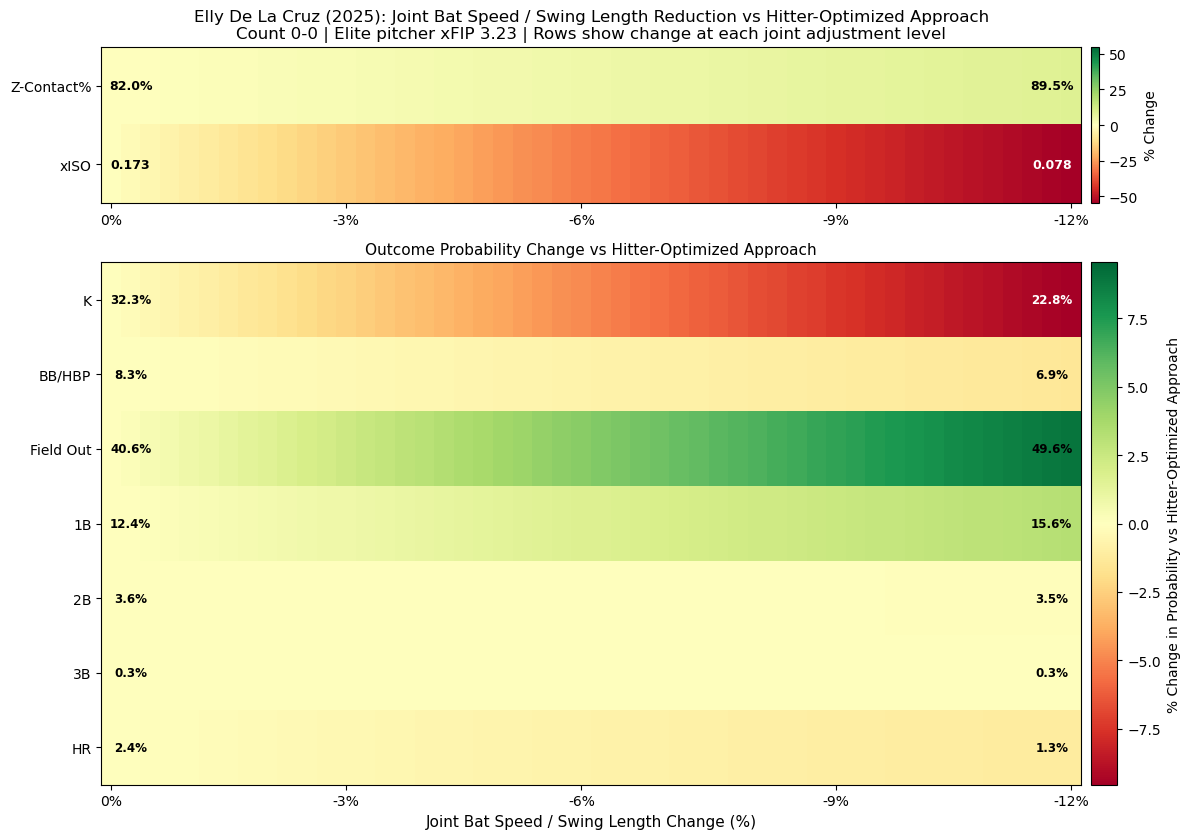

Baseline vs -12% joint Bat Speed / Swing Length (Count 0-0, elite pitcher)
  Z-Contact: +9.06% vs baseline
  xISO:      -54.99% vs baseline

Outcome probability deltas at -12% (percentage points):
  K          -9.55 pp
  BB/HBP     -1.42 pp
  Field Out  +9.00 pp
  1B         +3.21 pp
  2B         -0.10 pp
  3B         +0.04 pp
  HR         -1.19 pp


In [151]:
# ONeil Cruz: Joint BS/SL Reduction Outcome Heatmap vs Baseline
# Compares Z-Contact/xISO and outcome probabilities to baseline along the same joint BS/SL path (0% to -12%).

# Settings (change these if you want a different count)
balls_hm, strikes_hm = 0, 0
xfip_hm = None  # set after loading pitcher stats
OUTCOMES_HM = ["K", "BB/HBP", "Field Out", "1B", "2B", "3B", "HR"]

# Dependencies from prior cells
if "predict_probs_by_count" not in globals():
    raise RuntimeError("Run the count-probability cell first so `predict_probs_by_count` is defined.")

cruz = get_player_stats("Elly De La Cruz")

if "joint_pct_changes" not in globals():
    joint_pct_changes = np.linspace(0.0, -0.12, 50)

if "batter_stats" not in globals():
    batter_stats = pd.read_parquet(DATA_DIR / "batter_stats.parquet")


if "pitcher_stats" not in globals():
    pitcher_stats = pd.read_parquet(DATA_DIR / "pitcher_stats.parquet")
xfip_hm = np.nanpercentile(pitcher_stats["xFIP"].dropna(), 10)  # elite pitcher (10th pct xFIP)

cruz_row = batter_stats[(batter_stats["PlayerName"] == cruz["player_name"]) &
                      (batter_stats["Season"] == cruz["season"])].iloc[0]
cruz_o_swing = cruz_row["O-Swing_pct"]

x_vals = joint_pct_changes * 100  # shown as percent changes (0 to -12)
zc_pct_changes_hm = []
xiso_pct_changes_hm = []
zc_levels_hm = []
xiso_levels_hm = []
prob_path = []

for pct in joint_pct_changes:
    bs_change = cruz["bat_speed"] * pct
    sl_change = cruz["swing_length"] * pct
    upd = update_stats(
        current_bat_speed=cruz["bat_speed"],
        current_swing_length=cruz["swing_length"],
        current_z_contact=cruz["z_contact"],
        current_xiso=cruz["xiso"],
        bat_speed_change=bs_change,
        swing_length_change=sl_change,
    )

    zc_levels_hm.append(upd["new_z_contact"])
    zc_pct_changes_hm.append((upd["new_z_contact"] / cruz["z_contact"] - 1) * 100)
    xiso_levels_hm.append(upd["new_xiso"])
    xiso_pct_changes_hm.append((upd["new_xiso"] / cruz["xiso"] - 1) * 100)

    probs = predict_probs_by_count(
        balls_hm, strikes_hm, cruz_o_swing, upd["new_z_contact"], upd["new_xiso"], xfip_hm
    )
    prob_path.append(probs)

prob_path = np.array(prob_path)  # shape: (n_steps, 7)
baseline_probs = prob_path[0]
metric_baseline_labels = [f"{cruz['z_contact']:.1%}", f"{cruz['xiso']:.3f}"]
outcome_baseline_labels = [f"{p:.1%}" for p in baseline_probs]
metric_endpoint_labels = [f"{zc_levels_hm[-1]:.1%}", f"{xiso_levels_hm[-1]:.3f}"]
outcome_endpoint_labels = [f"{p:.1%}" for p in prob_path[-1]]
delta_prob_pp = (prob_path - baseline_probs) * 100  # percentage-point change vs baseline

# Top heatmap: metric changes (% vs baseline)
metric_heat = np.vstack([zc_pct_changes_hm, xiso_pct_changes_hm])
metric_labels = ["Z-Contact%", "xISO"]

# Bottom heatmap: outcome probability changes (pp vs baseline)
outcome_heat = delta_prob_pp.T

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8.5), gridspec_kw={"height_ratios": [1.2, 4]})

# Metric heatmap
vmax_m = np.nanmax(np.abs(metric_heat)) if np.isfinite(metric_heat).any() else 1
vmax_m = max(vmax_m, 0.1)
im1 = ax1.imshow(metric_heat, aspect="auto", cmap="RdYlGn", vmin=-vmax_m, vmax=vmax_m)
ax1.set_yticks(range(len(metric_labels)))
ax1.set_yticklabels(metric_labels, fontsize=10)
tick_idx = np.linspace(0, len(x_vals)-1, 5).round().astype(int)
ax1.set_xticks(tick_idx)
ax1.set_xticklabels([f"{x_vals[i]:.0f}%" for i in tick_idx], fontsize=10)
ax1.set_title(
    f"{cruz['player_name']} ({cruz['season']}): Joint Bat Speed / Swing Length Reduction vs Hitter-Optimized Approach\n"
    f"Count {balls_hm}-{strikes_hm} | Elite pitcher xFIP {xfip_hm:.2f} | Rows show change at each joint adjustment level",
    fontsize=12
)
for r in range(metric_heat.shape[0]):
    for c in [0, len(x_vals)-1]:
        val = metric_heat[r, c]
        x_text = c + (1 if c == 0 else -1)
        label = metric_baseline_labels[r] if c == 0 else metric_endpoint_labels[r]
        ax1.text(x_text, r, label, ha="center", va="center", fontsize=9,
                 color="white" if val < -0.6 * vmax_m else "black", fontweight="bold")
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.03, pad=0.01)
cbar1.set_label("% Change", fontsize=10)

# Outcome heatmap
vmax_o = np.nanmax(np.abs(outcome_heat)) if np.isfinite(outcome_heat).any() else 1
vmax_o = max(vmax_o, 0.05)
im2 = ax2.imshow(outcome_heat, aspect="auto", cmap="RdYlGn", vmin=-vmax_o, vmax=vmax_o)
ax2.set_yticks(range(len(OUTCOMES_HM)))
ax2.set_yticklabels(OUTCOMES_HM, fontsize=10)
ax2.set_xticks(tick_idx)
ax2.set_xticklabels([f"{x_vals[i]:.0f}%" for i in tick_idx], fontsize=10)
ax2.set_xlabel("Joint Bat Speed / Swing Length Change (%)", fontsize=11)
ax2.set_title("Outcome Probability Change vs Hitter-Optimized Approach", fontsize=11)

# Annotate baseline and endpoint columns for readability
for r in range(outcome_heat.shape[0]):
    for c in [0, len(x_vals)-1]:
        val = outcome_heat[r, c]
        x_text = c + (1 if c == 0 else -1)
        label = outcome_baseline_labels[r] if c == 0 else outcome_endpoint_labels[r]
        ax2.text(x_text, r, label, ha="center", va="center", fontsize=8.5,
                 color="white" if val < -0.6 * vmax_o else "black", fontweight="bold")

cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.03, pad=0.01)
cbar2.set_label("% Change in Probability vs Hitter-Optimized Approach", fontsize=10)

plt.tight_layout()
plt.show()

# Print endpoint summary at -12%
print(f"Baseline vs -12% joint Bat Speed / Swing Length (Count {balls_hm}-{strikes_hm}, elite pitcher)")
print(f"  Z-Contact: {zc_pct_changes_hm[-1]:+.2f}% vs baseline")
print(f"  xISO:      {xiso_pct_changes_hm[-1]:+.2f}% vs baseline")
print("\nOutcome probability deltas at -12% (percentage points):")
for outcome, dpp in zip(OUTCOMES_HM, delta_prob_pp[-1]):
    print(f"  {outcome:<10} {dpp:+.2f} pp")


PVC Hitters: 27 players
Filtered to simulation situations: innings [7, 8, 9], score diff -4 to 2
PAs matching simulation situations: 35453


Processing PVC hitters: 100%|██████████| 27/27 [01:53<00:00,  4.20s/it]



Processed 27 PVC hitters with >= 50 PAs

Top 10 PVC hitters with most WP gain from WCA:
      player_name  n_pas  avg_wp_diff_pp  z_contact   xiso
  Lawrence Butler    112        0.161511     0.8089 0.1642
    Rafael Devers    133        0.130016     0.7370 0.2423
       Oneil Cruz    109        0.124524     0.7756 0.2073
  Randy Arozarena    135        0.114574     0.7772 0.1896
  Elly De La Cruz    132        0.114359     0.8203 0.1732
     Brent Rooker    109        0.104827     0.8283 0.2284
       James Wood    116        0.092044     0.8097 0.2334
Teoscar Hernández     96        0.087059     0.8122 0.2062
     Ryan McMahon    115        0.080373     0.7845 0.2004
    Adolis García    101        0.077414     0.8079 0.1946


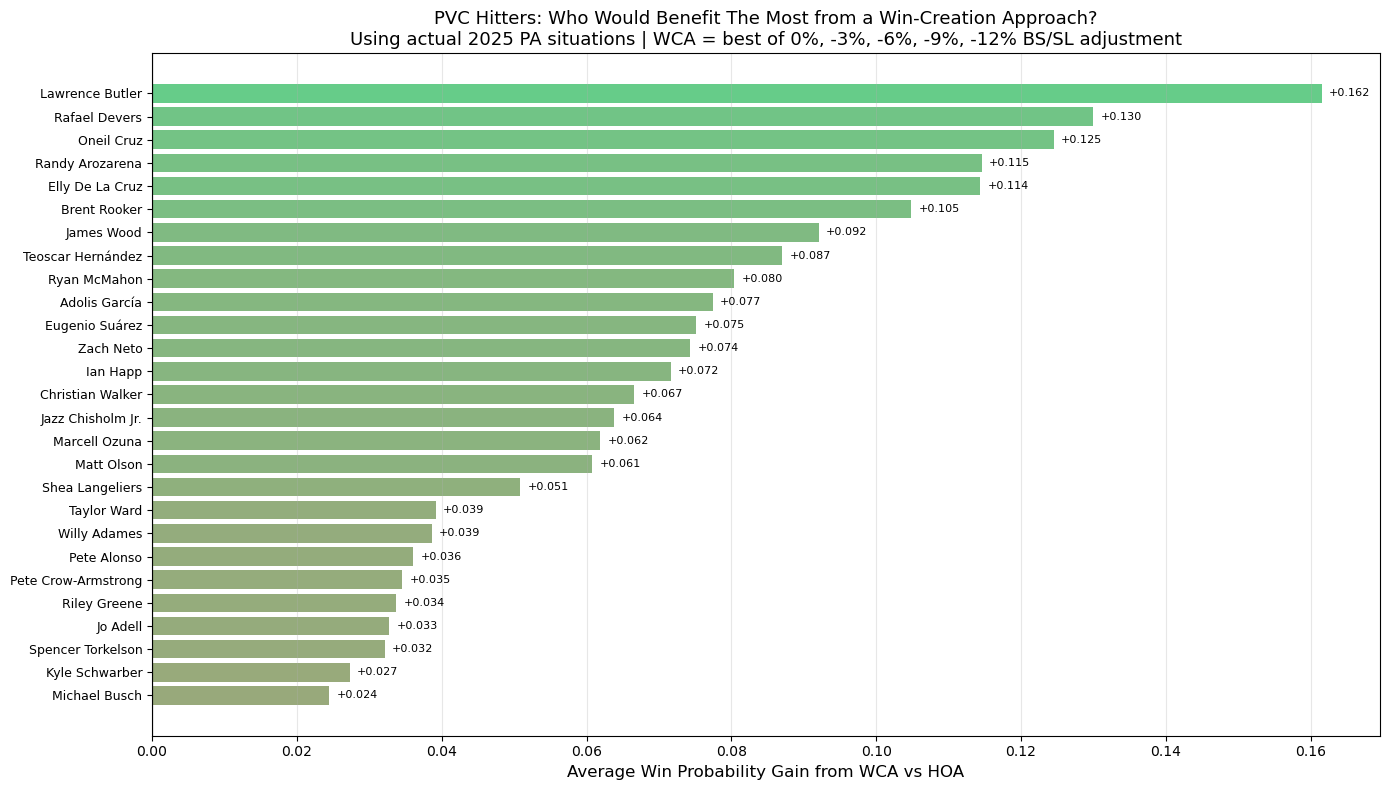


Summary:
  Mean WP gain across all PVC hitters: +0.0708%
  Max WP gain: +0.1615% (Lawrence Butler)
  Hitters with positive WP gain: 27 / 27


In [ ]:
# PVC Hitters: WCA vs HOA Win Probability Analysis
# For each PVC hitter, use their actual 2025 PA situations to compute avg WP diff between:
# - WCA (Win-Contribution Approach): choose swing adjustment that maximizes WP for each situation
# - HOA (Hitter-Optimized Approach): baseline stats, no adjustment

from tqdm import tqdm

# Define the 27 PVC batters

PVC_BATTERS = {
    "Oneil Cruz",
    "James Wood",
    "Ryan McMahon",
    "Riley Greene",
    "Eugenio Suárez",
    "Elly De La Cruz",
    "Kyle Schwarber",
    "Jo Adell",
    "Teoscar Hernández",
    "Spencer Torkelson",
    "Lawrence Butler",
    "Randy Arozarena",
    "Adolis García",
    "Jazz Chisholm Jr.",
    "Christian Walker",
    "Michael Busch",
    "Willy Adames",
    "Taylor Ward",
    "Rafael Devers",
    "Brent Rooker",
    "Zach Neto",
    "Matt Olson",
    "Marcell Ozuna",
    "Ian Happ",
    "Pete Crow-Armstrong",
    "Pete Alonso",
    "Shea Langeliers"
}
print(f"PVC Hitters: {len(PVC_BATTERS)} players")

# Load 2025 PBP data
pbp_2025 = pd.read_parquet(DATA_DIR / "pbp_2025.parquet")

# Filter to plate appearances with valid outcomes (events that end PA)
PA_EVENTS = [
    'strikeout', 'strikeout_double_play', 'walk', 'hit_by_pitch', 'intent_walk',
    'field_out', 'force_out', 'grounded_into_double_play', 'double_play', 
    'fielders_choice', 'fielders_choice_out', 'sac_fly', 'sac_bunt', 'sac_fly_double_play',
    'single', 'double', 'triple', 'home_run'
]

# Filter PBP to PA-ending events
pbp_pas = pbp_2025[pbp_2025["events"].isin(PA_EVENTS)].copy()

# Filter to situations covered by simulations (from config.py):
# - Innings 7-9 (late game)
# - Score diff -4 to +2
SIM_INNINGS = [7, 8, 9]
SIM_SCORE_RANGE = (-4, 2)

pbp_pas = pbp_pas[pbp_pas["inning"].isin(SIM_INNINGS)].copy()
pbp_pas = pbp_pas[
    (pbp_pas["bat_score_diff"] >= SIM_SCORE_RANGE[0]) & 
    (pbp_pas["bat_score_diff"] <= SIM_SCORE_RANGE[1])
].copy()

print(f"Filtered to simulation situations: innings {SIM_INNINGS}, score diff {SIM_SCORE_RANGE[0]} to {SIM_SCORE_RANGE[1]}")
print(f"PAs matching simulation situations: {len(pbp_pas)}")

# Encode base state
def encode_base(row):
    state = 0
    if pd.notna(row["on_1b"]): state |= 1
    if pd.notna(row["on_2b"]): state |= 2
    if pd.notna(row["on_3b"]): state |= 4
    return state

pbp_pas["base_state"] = pbp_pas.apply(encode_base, axis=1)

# Define swing adjustment levels to test (% reduction in BS and SL)
ADJUSTMENT_LEVELS = [0.0, -0.03, -0.06, -0.09, -0.12]  # 0%, -3%, -6%, -9%, -12%

def compute_expected_wp_for_probs(outcome_probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff):
    """Compute expected WP after PA given outcome probabilities."""
    total_wp = 0.0
    for outcome_idx, prob in enumerate(outcome_probs):
        if prob < 1e-6:
            continue
        transitions = transition_tables.get((outcome_idx, pre_outs, pre_base_state), 
                                            [(pre_base_state, min(pre_outs+1, 3), 0, 1.0)])
        for post_base, post_outs, runs_scored, trans_prob in transitions:
            new_score_diff = score_diff + runs_scored
            if post_outs >= 3:
                if inning_topbot == "Bot" and inning >= 9:
                    if new_score_diff > 0:
                        wp_after = 1.0
                    elif new_score_diff < 0:
                        wp_after = 0.0
                    else:
                        wp_after = 1 - lookup_wp(0, 0, min(inning + 1, 9), "Top", -new_score_diff)
                elif inning_topbot == "Top":
                    wp_after = 1 - lookup_wp(0, 0, inning, "Bot", -new_score_diff)
                else:
                    wp_after = 1 - lookup_wp(0, 0, min(inning + 1, 9), "Top", -new_score_diff)
            else:
                if inning >= 9 and inning_topbot == "Bot" and score_diff <= 0 and new_score_diff > 0:
                    wp_after = 1.0
                else:
                    wp_after = lookup_wp(post_outs, post_base, inning, inning_topbot, new_score_diff)
            total_wp += prob * trans_prob * wp_after
    return total_wp

# Process each PVC hitter
results = []
min_pas = 50  # Minimum PAs to include hitter

for player_name in tqdm(PVC_BATTERS, desc="Processing PVC hitters"):
    # Get player stats
    try:
        player_stats = get_player_stats(player_name)
    except (ValueError, IndexError):
        print(f"  Skipping {player_name}: could not get stats")
        continue
    
    player_id = player_stats['mlbam_id']
    
    # Get player's PAs
    player_pas = pbp_pas[pbp_pas["batter"] == player_id]
    
    if len(player_pas) < min_pas:
        print(f"  Skipping {player_name}: only {len(player_pas)} PAs")
        continue
    
    # Get o_swing from batter stats
    player_row = batter_stats[(batter_stats["xMLBAMID"] == player_id) & 
                              (batter_stats["Season"] == 2025)]
    if len(player_row) == 0:
        print(f"  Skipping {player_name}: no 2025 batter stats")
        continue
    player_o_swing = player_row.iloc[0]["O-Swing_pct"]
    
    # Pre-compute adjusted stats for each level
    adjusted_stats = {}
    for adj_pct in ADJUSTMENT_LEVELS:
        if adj_pct == 0.0:
            adjusted_stats[adj_pct] = (player_stats['z_contact'], player_stats['xiso'])
        else:
            bs_change = player_stats['bat_speed'] * adj_pct
            sl_change = player_stats['swing_length'] * adj_pct
            upd = update_stats(
                player_stats['bat_speed'], player_stats['swing_length'],
                player_stats['z_contact'], player_stats['xiso'],
                bs_change, sl_change
            )
            adjusted_stats[adj_pct] = (upd['new_z_contact'], upd['new_xiso'])
    
    # Process each PA
    wp_diffs = []
    
    for _, pa in player_pas.iterrows():
        # Extract situation
        pre_outs = int(pa["outs_when_up"])
        pre_base_state = int(pa["base_state"])
        inning = int(pa["inning"])
        inning_topbot = pa["inning_topbot"]
        balls = int(pa["balls"]) if pd.notna(pa["balls"]) else 0
        strikes = int(pa["strikes"]) if pd.notna(pa["strikes"]) else 0
        
        # Get score diff (clamp to reasonable range)
        score_diff = int(pa["bat_score_diff"]) if pd.notna(pa["bat_score_diff"]) else 0
        score_diff = max(-5, min(5, score_diff))
        
        # Use average pitcher for simplicity
        xfip = scalers["xFIP"]["mean"]
        
        # Compute WP for each adjustment level
        wps_by_adj = {}
        for adj_pct in ADJUSTMENT_LEVELS:
            zc, xiso = adjusted_stats[adj_pct]
            probs = predict_probs_by_count(balls, strikes, player_o_swing, zc, xiso, xfip)
            wp = compute_expected_wp_for_probs(probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff)
            wps_by_adj[adj_pct] = wp
        
        # HOA = baseline (0% adjustment)
        hoa_wp = wps_by_adj[0.0]
        
        # WCA = whichever adjustment gives highest WP
        wca_wp = max(wps_by_adj.values())
        
        # WP diff (WCA - HOA)
        wp_diff = wca_wp - hoa_wp
        wp_diffs.append(wp_diff)
    
    # Compute average WP diff for this hitter
    avg_wp_diff = np.mean(wp_diffs) * 100  # Convert to percentage points
    
    results.append({
        'player_name': player_name,
        'player_id': player_id,
        'n_pas': len(player_pas),
        'avg_wp_diff_pp': avg_wp_diff,
        'bat_speed': player_stats['bat_speed'],
        'swing_length': player_stats['swing_length'],
        'z_contact': player_stats['z_contact'],
        'xiso': player_stats['xiso'],
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('avg_wp_diff_pp', ascending=False)

print(f"\nProcessed {len(results_df)} PVC hitters with >= {min_pas} PAs")
print(f"\nTop 10 PVC hitters with most WP gain from WCA:")
print(results_df.head(10)[['player_name', 'n_pas', 'avg_wp_diff_pp', 'z_contact', 'xiso']].to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Sort by WP diff
results_df_sorted = results_df.sort_values('avg_wp_diff_pp', ascending=True)

# Color scale: red (-0.2) to green (+0.2)
def wp_to_color(val):
    from matplotlib.colors import to_rgb
    val_clipped = max(-0.2, min(0.2, val))
    normalized = (val_clipped + 0.2) / 0.4  # 0 to 1
    red = to_rgb('#e74c3c')
    green = to_rgb('#2ecc71')
    return tuple(r + normalized * (g - r) for r, g in zip(red, green))

colors = [wp_to_color(x) for x in results_df_sorted['avg_wp_diff_pp']]

bars = ax.barh(range(len(results_df_sorted)), results_df_sorted['avg_wp_diff_pp'], color=colors, alpha=0.8)

ax.set_yticks(range(len(results_df_sorted)))
ax.set_yticklabels(results_df_sorted['player_name'], fontsize=9)
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Average Win Probability Gain from WCA vs HOA', fontsize=12)
ax.set_title('PVC Hitters: Who Would Benefit The Most from a Win-Creation Approach?\n'
             'Using actual 2025 PA situations | WCA = best of 0%, -3%, -6%, -9%, -12% BS/SL adjustment', 
             fontsize=13)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(results_df_sorted.iterrows()):
    val = row['avg_wp_diff_pp']
    ax.text(val + 0.001 if val >= 0 else val - 0.001, i, f"{val:+.3f}", 
            va='center', ha='left' if val >= 0 else 'right', fontsize=8)

plt.tight_layout()
plt.show()

# Summary stats
print(f"\nSummary:")
print(f"  Mean WP gain across all PVC hitters: {results_df['avg_wp_diff_pp'].mean():+.4f}%")
print(f"  Max WP gain: {results_df['avg_wp_diff_pp'].max():+.4f}% ({results_df.iloc[0]['player_name']})")
print(f"  Hitters with positive WP gain: {(results_df['avg_wp_diff_pp'] > 0).sum()} / {len(results_df)}")

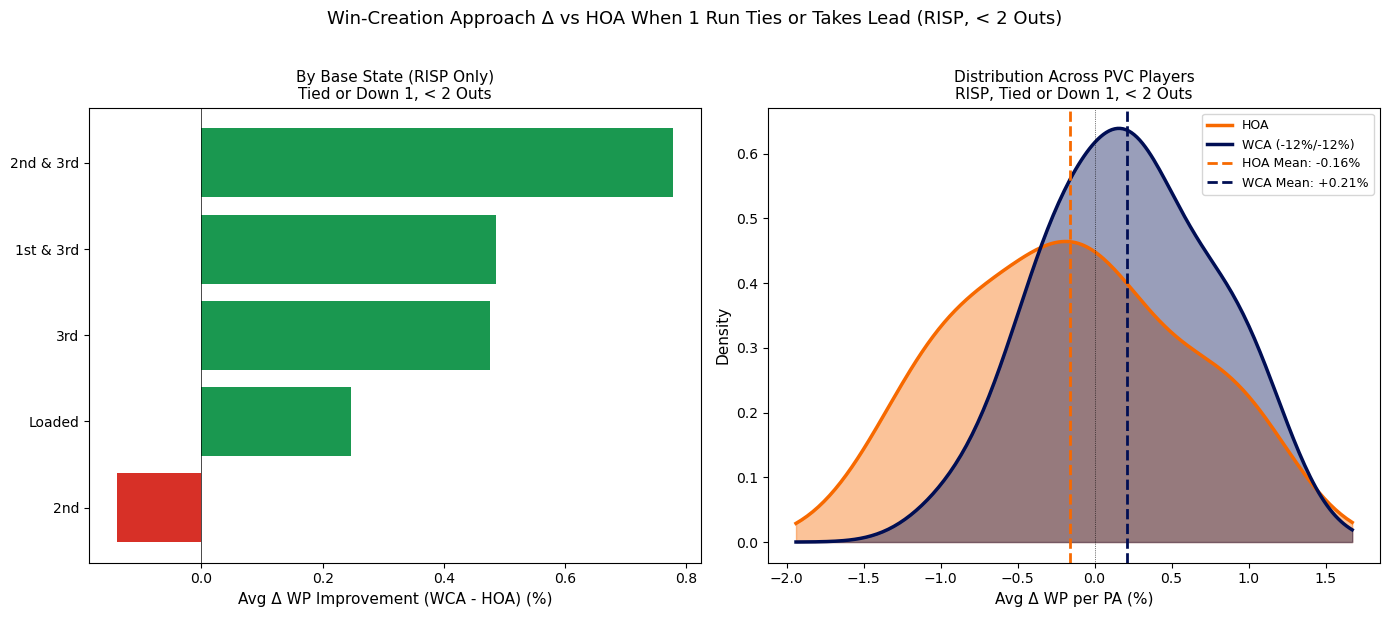


RISP + Clutch Score (Tied or Down 1) + < 2 Outs: WCA vs HOA
Players: 27
Total observations: 23,328,000

Overall avg WCA improvement: +0.3696%

By situation:
  2nd, Down 1: -0.2790% (n=2332800)
  2nd, Tied: -0.0005% (n=2332800)
  3rd, Down 1: +0.2552% (n=2332800)
  3rd, Tied: +0.6974% (n=2332800)
  1st & 3rd, Down 1: +0.2999% (n=2332800)
  1st & 3rd, Tied: +0.6728% (n=2332800)
  2nd & 3rd, Down 1: +0.7060% (n=2332800)
  2nd & 3rd, Tied: +0.8500% (n=2332800)
  Loaded, Down 1: +0.1350% (n=2332800)
  Loaded, Tied: +0.3595% (n=2332800)


In [ ]:
# When One Run Ties or Takes the Lead: WCA vs HOA with RISP, < 2 Outs
# Score diff -1 (down 1) or 0 (tied) + Runners in Scoring Position + Less than 2 outs

# Load all simulation files
SIM_OUTPUT_DIR = Path("Simulations/output")
sim_files = list(SIM_OUTPUT_DIR.glob("*_simulation.parquet"))
n_players = len(sim_files)

# Target adjustment
TARGET_BS_CHANGE = -0.12
TARGET_SL_CHANGE = -0.12

# RISP base states: 2 (2nd), 4 (3rd), 5 (1st & 3rd), 6 (2nd & 3rd), 7 (loaded)
RISP_STATES = [2, 4, 5, 6, 7]
RISP_NAMES = {2: "2nd", 4: "3rd", 5: "1st & 3rd", 6: "2nd & 3rd", 7: "Loaded"}

# Score diffs where 1 run ties or takes lead
CLUTCH_SCORES = [-1, 0]  # Down 1 or Tied

# Less than 2 outs
OUTS_FILTER = [0, 1]

# Collect results
results = []

for sim_file in sim_files:
    sim_df = pq.read_table(sim_file).to_pandas()
    player_name = sim_df['player_name'].iloc[0]
    
    # Filter to RISP, clutch score, and < 2 outs
    state_filter = (
        (sim_df['base_state'].isin(RISP_STATES)) &
        (sim_df['score_diff'].isin(CLUTCH_SCORES)) &
        (sim_df['outs'].isin(OUTS_FILTER))
    )
    sim_df = sim_df[state_filter]
    
    # Get baseline rows (HOA: 0% adjustment)
    baseline = sim_df[
        (sim_df['bat_speed_change_pct'] == 0) & 
        (sim_df['swing_length_change_pct'] == 0)
    ][['base_state', 'score_diff', 'inning', 'outs', 'wp_before_pa', 'adjusted_wp_after_pa']].copy()
    baseline = baseline.rename(columns={'adjusted_wp_after_pa': 'hoa_wp_after'})
    
    # Get -12%/-12% adjustment rows
    adjusted = sim_df[
        (np.isclose(sim_df['bat_speed_change_pct'], TARGET_BS_CHANGE, atol=0.001)) & 
        (np.isclose(sim_df['swing_length_change_pct'], TARGET_SL_CHANGE, atol=0.001))
    ][['base_state', 'score_diff', 'inning', 'outs', 'adjusted_wp_after_pa']].copy()
    adjusted = adjusted.rename(columns={'adjusted_wp_after_pa': 'wca_wp_after'})
    
    # Merge
    merged = baseline.merge(adjusted, on=['base_state', 'score_diff', 'inning', 'outs'])
    merged['hoa_delta'] = (merged['hoa_wp_after'] - merged['wp_before_pa']) * 100
    merged['wca_delta'] = (merged['wca_wp_after'] - merged['wp_before_pa']) * 100
    merged['wca_minus_hoa'] = merged['wca_delta'] - merged['hoa_delta']
    merged['player_name'] = player_name
    
    results.append(merged)

all_results = pd.concat(results, ignore_index=True)

# Summary by base state and score diff
summary = all_results.groupby(['base_state', 'score_diff']).agg({
    'wca_minus_hoa': ['mean', 'std', 'count'],
    'hoa_delta': 'mean',
    'wca_delta': 'mean'
}).reset_index()
summary.columns = ['base_state', 'score_diff', 'avg_improvement', 'std', 'n', 'avg_hoa', 'avg_wca']

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Bar chart by base state
ax1 = axes[0]
base_state_summary = all_results.groupby('base_state')['wca_minus_hoa'].mean().reset_index()
base_state_summary['base_name'] = base_state_summary['base_state'].map(RISP_NAMES)
base_state_summary = base_state_summary.sort_values('wca_minus_hoa', ascending=True)

colors = ['#1a9850' if x > 0 else '#d73027' for x in base_state_summary['wca_minus_hoa']]
bars = ax1.barh(base_state_summary['base_name'], base_state_summary['wca_minus_hoa'], color=colors)
ax1.axvline(0, color='black', linewidth=0.5)
ax1.set_xlabel('Avg Δ WP Improvement (WCA - HOA) (%)', fontsize=11)
ax1.set_title('By Base State (RISP Only)\nTied or Down 1, < 2 Outs', fontsize=11)

# Right plot: Density comparison for all RISP clutch situations
ax2 = axes[1]
from scipy.stats import gaussian_kde

# Get player-level averages
player_avgs = all_results.groupby('player_name').agg({
    'hoa_delta': 'mean',
    'wca_delta': 'mean'
}).reset_index()

x_range = np.linspace(
    min(player_avgs['hoa_delta'].min(), player_avgs['wca_delta'].min()) - 0.5,
    max(player_avgs['hoa_delta'].max(), player_avgs['wca_delta'].max()) + 0.5,
    200
)

# HOA density
kde_hoa = gaussian_kde(player_avgs['hoa_delta'])
ax2.fill_between(x_range, kde_hoa(x_range), alpha=0.4, color='#F76900')
ax2.plot(x_range, kde_hoa(x_range), color='#F76900', lw=2.5, label='HOA')

# WCA density
kde_wca = gaussian_kde(player_avgs['wca_delta'])
ax2.fill_between(x_range, kde_wca(x_range), alpha=0.4, color='#000E54')
ax2.plot(x_range, kde_wca(x_range), color='#000E54', lw=2.5, label='WCA (-12%/-12%)')

# Mean lines
ax2.axvline(player_avgs['hoa_delta'].mean(), color='#F76900', linestyle='--', lw=2,
            label=f"HOA Mean: {player_avgs['hoa_delta'].mean():+.2f}%")
ax2.axvline(player_avgs['wca_delta'].mean(), color='#000E54', linestyle='--', lw=2,
            label=f"WCA Mean: {player_avgs['wca_delta'].mean():+.2f}%")

ax2.axvline(0, color='black', linewidth=0.5, linestyle=':')
ax2.set_xlabel('Avg Δ WP per PA (%)', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('Distribution Across PVC Players\nRISP, Tied or Down 1, < 2 Outs', fontsize=11)
ax2.legend(loc='upper right', fontsize=9)

plt.suptitle('Win-Creation Approach Δ vs HOA When 1 Run Ties or Takes Lead (RISP, < 2 Outs)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*60}")
print(f"RISP + Clutch Score (Tied or Down 1) + < 2 Outs: WCA vs HOA")
print(f"{'='*60}")
print(f"Players: {n_players}")
print(f"Total observations: {len(all_results):,}")
print(f"\nOverall avg WCA improvement: {all_results['wca_minus_hoa'].mean():+.4f}%")
print(f"\nBy situation:")
for _, row in summary.iterrows():
    score_label = "Tied" if row['score_diff'] == 0 else "Down 1"
    print(f"  {RISP_NAMES[row['base_state']]}, {score_label}: {row['avg_improvement']:+.4f}% (n={int(row['n'])})")

Total player-state combinations: 1,632,960
Max BS (-12%) but not max SL: 35,331 (2.2%)

Swing Length adjustments when BS = -12%:
  SL -9%: 34,350 (97.2%)
  SL -6%: 435 (1.2%)
  SL -3%: 254 (0.7%)
  SL -0%: 292 (0.8%)

Game States Most Frequently Requiring Nuanced Approach:
(Max BS reduction but partial SL reduction)
  Runners on 2nd & 3rd, 1 out, Tied: 684 instances
  Runner on 3rd, 1 out, Tied: 642 instances
  Runners on 2nd & 3rd, 1 out, Up 1: 626 instances
  Runners on 2nd & 3rd, 1 out, Up 2: 611 instances
  Runners on 2nd & 3rd, 0 out, Tied: 570 instances
  Runners on 1st & 3rd, 1 out, Tied: 563 instances
  Runners on 2nd & 3rd, 1 out, Down 1: 554 instances
  Runners on 1st & 3rd, 0 out, Tied: 549 instances
  Runners on 1st & 3rd, 1 out, Up 1: 521 instances
  Runners on 1st & 3rd, 1 out, Up 2: 509 instances
  Runner on 3rd, 1 out, Up 2: 505 instances
  Runner on 3rd, 0 out, Tied: 499 instances
  Runner on 3rd, 1 out, Up 1: 498 instances
  Bases Loaded, 0 out, Tied: 463 instances
  

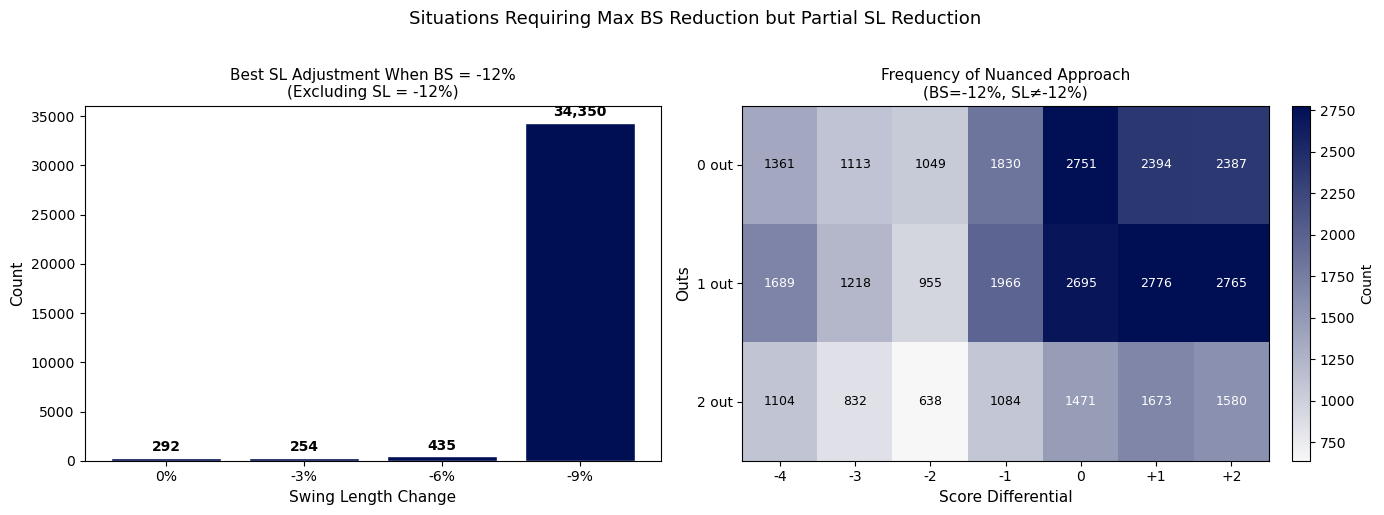

In [ ]:
# Find Situations Where Best WCA = Max BS Reduction (-12%) but NOT Max SL Reduction
# These are situations where a nuanced approach is optimal

# Load all simulation files
SIM_OUTPUT_DIR = Path("Simulations/output")
sim_files = list(SIM_OUTPUT_DIR.glob("*_simulation.parquet"))
n_players = len(sim_files)

MAX_BS_CHANGE = -0.12
MAX_SL_CHANGE = -0.12

# Collect best adjustments for each player/state
best_adjustments = []

for sim_file in sim_files:
    sim_df = pq.read_table(sim_file).to_pandas()
    player_name = sim_df['player_name'].iloc[0]
    
    # Only consider feasible adjustments
    feasible = sim_df[sim_df['is_feasible'] == 1].copy()
    
    # Group by game state and find best adjustment
    state_cols = ['base_state', 'outs', 'inning', 'inning_topbot', 'score_diff', 'count', 'pitcher_xfip_percentile']
    
    for state, group in feasible.groupby(state_cols):
        best_idx = group['adjusted_wp_after_pa'].idxmax()
        best_row = group.loc[best_idx]
        
        best_adjustments.append({
            'player_name': player_name,
            'base_state': state[0],
            'outs': state[1],
            'inning': state[2],
            'inning_topbot': state[3],
            'score_diff': state[4],
            'count': state[5],
            'pitcher_xfip_percentile': state[6],
            'best_bs_change': best_row['bat_speed_change_pct'],
            'best_sl_change': best_row['swing_length_change_pct'],
            'wp_diff': best_row['wp_diff_from_baseline'] * 100
        })

adj_df = pd.DataFrame(best_adjustments)

# Filter to: max BS reduction (-12%) but NOT max SL reduction
nuanced = adj_df[
    (np.isclose(adj_df['best_bs_change'], MAX_BS_CHANGE, atol=0.001)) &
    (~np.isclose(adj_df['best_sl_change'], MAX_SL_CHANGE, atol=0.001))
].copy()

print(f"Total player-state combinations: {len(adj_df):,}")
print(f"Max BS (-12%) but not max SL: {len(nuanced):,} ({len(nuanced)/len(adj_df)*100:.1f}%)")

# Analyze which SL adjustments are chosen
sl_dist = nuanced['best_sl_change'].value_counts().sort_index()
print(f"\nSwing Length adjustments when BS = -12%:")
for sl, count in sl_dist.items():
    print(f"  SL {sl*100:+.0f}%: {count:,} ({count/len(nuanced)*100:.1f}%)")

# Which game states most often have this nuanced approach?
print(f"\n{'='*60}")
print("Game States Most Frequently Requiring Nuanced Approach:")
print("(Max BS reduction but partial SL reduction)")
print(f"{'='*60}")

# Group by state features
state_analysis = nuanced.groupby(['base_state', 'outs', 'score_diff']).size().reset_index(name='count')
state_analysis = state_analysis.sort_values('count', ascending=False).head(15)

for _, row in state_analysis.iterrows():
    print(f"  {BASE_STATE_DISPLAY[row['base_state']]}, {int(row['outs'])} out, {format_score(row['score_diff'])}: {row['count']} instances")

# Plot: Distribution of SL changes when BS = -12%
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar chart of SL adjustments
ax1 = axes[0]
sl_pcts = [0, -0.03, -0.06, -0.09]  # Excluding -0.12
sl_counts = [len(nuanced[np.isclose(nuanced['best_sl_change'], sl, atol=0.001)]) for sl in sl_pcts]
sl_labels = ['0%', '-3%', '-6%', '-9%']
colors = ['#000E54'] * 4
ax1.bar(sl_labels, sl_counts, color=colors, edgecolor='white')
ax1.set_xlabel('Swing Length Change', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Best SL Adjustment When BS = -12%\n(Excluding SL = -12%)', fontsize=11)

for i, (sl, count) in enumerate(zip(sl_labels, sl_counts)):
    ax1.text(i, count + max(sl_counts)*0.02, f'{count:,}', ha='center', fontsize=10, fontweight='bold')

# Right: Heatmap by outs and score diff
ax2 = axes[1]
heatmap_data = nuanced.groupby(['outs', 'score_diff']).size().reset_index(name='count')
heatmap_pivot = heatmap_data.pivot(index='outs', columns='score_diff', values='count').fillna(0)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('blue_cmap', ['#f7f7f7', '#000E54'])
im = ax2.imshow(heatmap_pivot.values, cmap=cmap, aspect='auto')

ax2.set_xticks(range(len(heatmap_pivot.columns)))
ax2.set_xticklabels([f"{int(x):+d}" if x != 0 else "0" for x in heatmap_pivot.columns])
ax2.set_yticks(range(len(heatmap_pivot.index)))
ax2.set_yticklabels([f"{int(y)} out" for y in heatmap_pivot.index])
ax2.set_xlabel('Score Differential', fontsize=11)
ax2.set_ylabel('Outs', fontsize=11)
ax2.set_title('Frequency of Nuanced Approach\n(BS=-12%, SL≠-12%)', fontsize=11)

cbar = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Count', fontsize=10)

for i in range(len(heatmap_pivot.index)):
    for j in range(len(heatmap_pivot.columns)):
        val = heatmap_pivot.values[i, j]
        if val > 0:
            text_color = 'white' if val > heatmap_pivot.values.max() * 0.5 else 'black'
            ax2.text(j, i, f'{int(val)}', ha='center', va='center', fontsize=9, color=text_color)

plt.suptitle('Situations Requiring Max BS Reduction but Partial SL Reduction', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

Willy Adames: 136 PAs in late-game situations (Inn 7-9, Score -4 to +2)


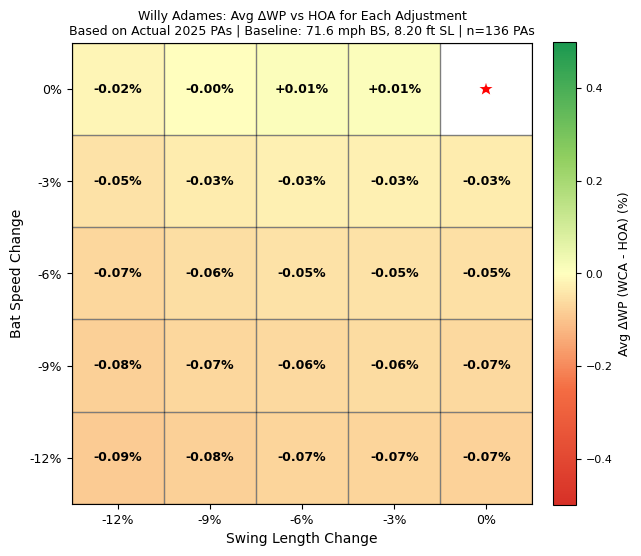


Willy Adames: Avg WCA - HOA for each adjustment (based on actual 2025 PAs)
BS Change    SL Change    Avg Δ WP     N PAs       
------------------------------------------------
+0%         -3%         +0.009%      136
+0%         -6%         +0.008%      136
+0%         -9%         -0.001%      136
+0%         -12%         -0.017%      136
-3%         +0%         -0.032%      136
-3%         -3%         -0.025%      136
-3%         -6%         -0.026%      136
-3%         -9%         -0.034%      136
-3%         -12%         -0.047%      136
-6%         +0%         -0.052%      136
-6%         -3%         -0.048%      136
-6%         -6%         -0.049%      136
-6%         -9%         -0.055%      136
-6%         -12%         -0.067%      136
-9%         +0%         -0.066%      136
-9%         -3%         -0.062%      136
-9%         -6%         -0.063%      136
-9%         -9%         -0.070%      136
-9%         -12%         -0.080%      136
-12%         +0%         -0.074%      13

In [106]:
# Heatmap: Avg WCA - HOA for Each Adjustment (Single Player, Actual 2025 PAs)
# Uses real game situations from 2025 PBP data

from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Rectangle

# Select player
PLAYER_NAME = "Willy Adames"  # Change this to any PVC player

# Load player's simulation file
SIM_OUTPUT_DIR = Path("Simulations/output")
DATA_DIR = Path("Data")
safe_name = PLAYER_NAME.replace(" ", "_").replace(".", "")
sim_file = SIM_OUTPUT_DIR / f"{safe_name}_simulation.parquet"

if not sim_file.exists():
    raise FileNotFoundError(f"Simulation file not found for {PLAYER_NAME}")

sim_df = pq.read_table(sim_file).to_pandas()
player_id = sim_df['batter_id'].iloc[0]

# Load 2025 PBP data
pbp = pd.read_parquet(DATA_DIR / "pbp_2025.parquet")

# Filter to this player's PAs
PA_EVENTS = [
    'strikeout', 'strikeout_double_play', 'walk', 'hit_by_pitch', 'intent_walk',
    'field_out', 'force_out', 'grounded_into_double_play', 'double_play', 
    'fielders_choice', 'fielders_choice_out', 'sac_fly', 'sac_bunt', 'sac_fly_double_play',
    'single', 'double', 'triple', 'home_run'
]
player_pbp = pbp[(pbp['batter'] == player_id) & (pbp['events'].isin(PA_EVENTS))].copy()

# Filter to simulation coverage (innings 7-9, score diff -4 to +2)
player_pbp = player_pbp[player_pbp['inning'].isin([7, 8, 9])].copy()
player_pbp = player_pbp[(player_pbp['bat_score_diff'] >= -4) & (player_pbp['bat_score_diff'] <= 2)].copy()

# Encode base state
def encode_base_state(row):
    state = 0
    if pd.notna(row['on_1b']): state |= 1
    if pd.notna(row['on_2b']): state |= 2
    if pd.notna(row['on_3b']): state |= 4
    return state

player_pbp['base_state'] = player_pbp.apply(encode_base_state, axis=1)
player_pbp['score_diff'] = player_pbp['bat_score_diff'].astype(int)
player_pbp['count'] = player_pbp['balls'].astype(int).astype(str) + '-' + player_pbp['strikes'].astype(int).astype(str)
player_pbp['pitcher_xfip_percentile'] = 50
player_pbp = player_pbp.rename(columns={'outs_when_up': 'outs'})

print(f"{PLAYER_NAME}: {len(player_pbp)} PAs in late-game situations (Inn 7-9, Score -4 to +2)")

# Adjustment grid
bs_pcts = [0, -0.03, -0.06, -0.09, -0.12]
sl_pcts = [0, -0.03, -0.06, -0.09, -0.12]

# Get baseline (HOA) from sim
state_cols = ['base_state', 'outs', 'inning', 'inning_topbot', 'score_diff', 'count', 'pitcher_xfip_percentile']
sim_baseline = sim_df[
    (sim_df['bat_speed_change_pct'] == 0) & 
    (sim_df['swing_length_change_pct'] == 0)
][state_cols + ['adjusted_wp_after_pa']].copy()
sim_baseline = sim_baseline.rename(columns={'adjusted_wp_after_pa': 'hoa_wp'})

# Calculate avg WCA - HOA for each adjustment
adjustment_results = []

for bs_pct in bs_pcts:
    for sl_pct in sl_pcts:
        # Get adjusted WP from sim
        adjusted = sim_df[
            (np.isclose(sim_df['bat_speed_change_pct'], bs_pct, atol=0.001)) & 
            (np.isclose(sim_df['swing_length_change_pct'], sl_pct, atol=0.001))
        ][state_cols + ['adjusted_wp_after_pa']].copy()
        adjusted = adjusted.rename(columns={'adjusted_wp_after_pa': 'adj_wp'})
        
        # Merge sim data with actual PAs
        merged = player_pbp[state_cols].merge(
            sim_baseline, on=state_cols, how='inner'
        ).merge(
            adjusted, on=state_cols, how='inner'
        )
        
        # Calculate avg difference (WCA - HOA) in percentage points
        if len(merged) > 0:
            avg_diff = (merged['adj_wp'] - merged['hoa_wp']).mean() * 100
        else:
            avg_diff = 0
        
        adjustment_results.append({
            'bat_speed_change_pct': bs_pct,
            'swing_length_change_pct': sl_pct,
            'avg_wca_minus_hoa': avg_diff,
            'n_total': len(merged)
        })

pct_grid = pd.DataFrame(adjustment_results)

# Get grid coordinates from player's baseline
baseline_bs = sim_df['baseline_bat_speed'].iloc[0]
baseline_sl = sim_df['baseline_swing_length'].iloc[0]

pct_grid['new_bat_speed'] = baseline_bs * (1 + pct_grid['bat_speed_change_pct'])
pct_grid['new_swing_length'] = baseline_sl * (1 + pct_grid['swing_length_change_pct'])

sl_values = sorted(pct_grid['new_swing_length'].unique())
bs_values = sorted(pct_grid['new_bat_speed'].unique())
sl_step = (max(sl_values) - min(sl_values)) / 4
bs_step = (max(bs_values) - min(bs_values)) / 4

# Plot
fig, ax = plt.subplots(figsize=(7, 7))

cmap = LinearSegmentedColormap.from_list(
    "wp_cmap",
    [
        (0.0, "#d73027"),
        (0.25, "#f46d43"),
        (0.5, "#ffffbf"),
        (0.75, "#91cf60"),
        (1.0, "#1a9850"),
    ],
)
norm = Normalize(vmin=-0.5, vmax=0.5)

for _, row in pct_grid.iterrows():
    bs_pct = row['bat_speed_change_pct']
    sl_pct = row['swing_length_change_pct']
    val = row['avg_wca_minus_hoa']
    
    # Baseline cell - white with no label
    if bs_pct == 0 and sl_pct == 0:
        color = "white"
        ax.add_patch(
            Rectangle(
                (row['new_swing_length'] - sl_step / 2, row['new_bat_speed'] - bs_step / 2),
                sl_step,
                bs_step,
                facecolor=color,
                edgecolor="white",
                linewidth=0.6,
            )
        )
    else:
        color = cmap(norm(np.clip(val, -0.5, 0.5)))
        
        ax.add_patch(
            Rectangle(
                (row['new_swing_length'] - sl_step / 2, row['new_bat_speed'] - bs_step / 2),
                sl_step,
                bs_step,
                facecolor=color,
                edgecolor="white",
                linewidth=0.6,
            )
        )
        
        text_color = 'white' if abs(val) > 0.25 else 'black'
        ax.text(
            row['new_swing_length'],
            row['new_bat_speed'],
            f"{val:+.2f}%",
            ha="center",
            va="center",
            fontsize=9,
            fontweight="bold",
            color=text_color,
        )

# Baseline marker (star on white square)
ax.plot(
    max(sl_values),
    max(bs_values),
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    zorder=10,
)

scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
scalar_mappable.set_array([])
cbar = fig.colorbar(scalar_mappable, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Avg ΔWP (WCA - HOA) (%)", fontsize=9)
cbar.ax.tick_params(labelsize=8)

ax.set_xlabel("Swing Length Change", fontsize=10)
ax.set_ylabel("Bat Speed Change", fontsize=10)
ax.set_title(
    f"{PLAYER_NAME}: Avg ΔWP vs HOA for Each Adjustment\n"
    f"Based on Actual 2025 PAs | Baseline: {baseline_bs:.1f} mph BS, {baseline_sl:.2f} ft SL | n={len(player_pbp)} PAs",
    fontsize=9
)

# Labels
pct_labels = ["-12%", "-9%", "-6%", "-3%", "0%"]
ax.set_xticks(sl_values)
ax.set_xticklabels(pct_labels)
ax.set_yticks(bs_values)
ax.set_yticklabels(pct_labels)
ax.tick_params(axis="both", labelsize=9)

ax.set_xlim(min(sl_values) - sl_step / 2, max(sl_values) + sl_step / 2)
ax.set_ylim(min(bs_values) - bs_step / 2, max(bs_values) + bs_step / 2)
ax.set_aspect("auto")
ax.set_box_aspect(1)
ax.grid(False)

# Grid borders
for sl in sl_values:
    ax.axvline(sl - sl_step / 2, color="black", linestyle="-", alpha=0.5, linewidth=1, zorder=5)
ax.axvline(max(sl_values) + sl_step / 2, color="black", linestyle="-", alpha=0.5, linewidth=1, zorder=5)
for bs in bs_values:
    ax.axhline(bs - bs_step / 2, color="black", linestyle="-", alpha=0.5, linewidth=1, zorder=5)
ax.axhline(max(bs_values) + bs_step / 2, color="black", linestyle="-", alpha=0.5, linewidth=1, zorder=5)

fig.patch.set_facecolor("white")
ax.set_facecolor("white")
fig.subplots_adjust(left=0.14, right=0.86, bottom=0.16, top=0.90)

plt.show()

# Print summary
print(f"\n{PLAYER_NAME}: Avg WCA - HOA for each adjustment (based on actual 2025 PAs)")
print(f"{'BS Change':<12} {'SL Change':<12} {'Avg Δ WP':<12} {'N PAs':<12}")
print("-" * 48)
for _, row in pct_grid.sort_values(['bat_speed_change_pct', 'swing_length_change_pct'], ascending=[False, False]).iterrows():
    if row['bat_speed_change_pct'] == 0 and row['swing_length_change_pct'] == 0:
        continue
    print(f"{row['bat_speed_change_pct']*100:+.0f}%{'':<8} {row['swing_length_change_pct']*100:+.0f}%{'':<8} {row['avg_wca_minus_hoa']:+.3f}%{'':<5} {int(row['n_total']):,}")

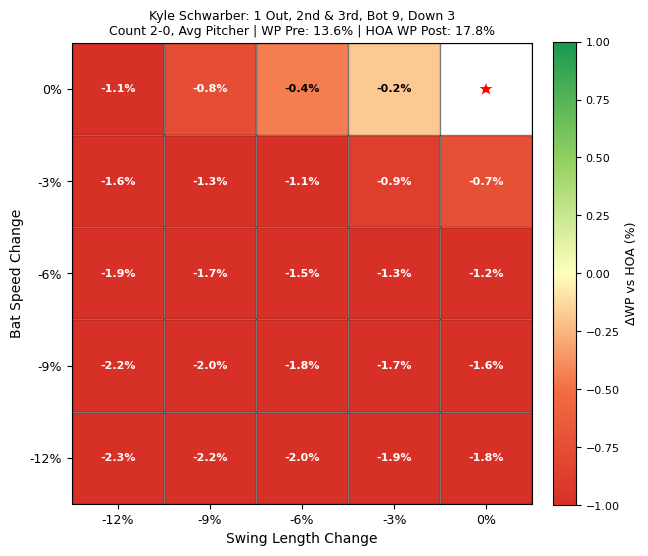

In [110]:
# WP Difference Heatmap Function for a Single Player in a Specific Game State
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Rectangle

# Constants
BASE_STATE_NAMES = ["Empty", "1st", "2nd", "1st & 2nd", "3rd", "1st & 3rd", "2nd & 3rd", "Loaded"]
XFIP_QUALITY = {10: "Elite", 30: "Above Avg", 50: "Avg", 70: "Below Avg", 90: "Poor"}

def plot_wp_diff_heatmap(
    player_name,
    p_count,
    p_outs,
    p_base_state,
    p_inning,
    p_inning_topbot,
    p_score_diff,
    p_pitcher_xfip_percentile,
):
    """Generate WP difference heatmap for a player in a specific game state."""
    
    # Load player simulation data
    SIM_OUTPUT_DIR = Path("Simulations/output")
    safe_name = player_name.replace(" ", "_").replace(".", "")
    file_path = SIM_OUTPUT_DIR / f"{safe_name}_simulation.parquet"

    if not file_path.exists():
        raise FileNotFoundError(f"Simulation file not found: {file_path}")

    df = pd.read_parquet(file_path)

    # Filter to specific game state
    state_df = df[
        (df["count"] == p_count) &
        (df["outs"] == p_outs) &
        (df["base_state"] == p_base_state) &
        (df["inning"] == p_inning) &
        (df["inning_topbot"] == p_inning_topbot) &
        (df["score_diff"] == p_score_diff) &
        (df["pitcher_xfip_percentile"] == p_pitcher_xfip_percentile)
    ]

    if len(state_df) == 0:
        raise ValueError(f"No data found for specified state")

    # Get baseline values
    baseline_row = state_df[
        (state_df["bat_speed_change_pct"] == 0) &
        (state_df["swing_length_change_pct"] == 0)
    ].iloc[0]

    baseline_bs = baseline_row["baseline_bat_speed"]
    baseline_sl = baseline_row["baseline_swing_length"]
    wp_before = baseline_row["wp_before_pa"]
    baseline_wp_after = baseline_row["baseline_wp_after_pa"]

    bs_pcts = [0, -0.03, -0.06, -0.09, -0.12]
    sl_pcts = [0, -0.03, -0.06, -0.09, -0.12]

    full_grid = pd.DataFrame(
        [(bs_pct, sl_pct) for bs_pct in bs_pcts for sl_pct in sl_pcts],
        columns=["bat_speed_change_pct", "swing_length_change_pct"],
    )
    full_grid["new_bat_speed"] = baseline_bs * (1 + full_grid["bat_speed_change_pct"])
    full_grid["new_swing_length"] = baseline_sl * (1 + full_grid["swing_length_change_pct"])

    state_subset = state_df[
        ["bat_speed_change_pct", "swing_length_change_pct", "wp_diff_from_baseline", "is_feasible"]
    ].copy()
    state_subset["wp_diff_pct"] = state_subset["wp_diff_from_baseline"] * 100

    full_grid = full_grid.merge(
        state_subset[["bat_speed_change_pct", "swing_length_change_pct", "wp_diff_pct", "is_feasible"]],
        on=["bat_speed_change_pct", "swing_length_change_pct"],
        how="left",
    )

    sl_values = sorted(full_grid["new_swing_length"].unique())
    bs_values = sorted(full_grid["new_bat_speed"].unique())
    sl_step = (max(sl_values) - min(sl_values)) / 4
    bs_step = (max(bs_values) - min(bs_values)) / 4

    # Plot
    fig, ax = plt.subplots(figsize=(7, 7))

    cmap = LinearSegmentedColormap.from_list(
        "wp_cmap",
        [
            (0.0, "#d73027"),
            (0.25, "#f46d43"),
            (0.5, "#ffffbf"),
            (0.75, "#91cf60"),
            (1.0, "#1a9850"),
        ],
    )
    norm = Normalize(vmin=-1, vmax=1)

    for _, row in full_grid.iterrows():
        val = row["wp_diff_pct"]
        bs_pct = row["bat_speed_change_pct"]
        sl_pct = row["swing_length_change_pct"]
        
        # Baseline cell - white
        if bs_pct == 0 and sl_pct == 0:
            color = "white"
        else:
            color = cmap(norm(np.clip(float(val), -1, 1)))

        ax.add_patch(
            Rectangle(
                (float(row["new_swing_length"]) - sl_step / 2, float(row["new_bat_speed"]) - bs_step / 2),
                sl_step,
                bs_step,
                facecolor=color,
                edgecolor="white",
                linewidth=0.6,
            )
        )

        # Add text label for non-baseline cells
        if bs_pct != 0 or sl_pct != 0:
            text_color = 'white' if abs(float(val)) > 0.5 else 'black'
            ax.text(
                float(row["new_swing_length"]),
                float(row["new_bat_speed"]),
                f"{float(val):+.1f}%",
                ha="center",
                va="center",
                fontsize=8,
                fontweight="bold",
                color=text_color,
            )

    # Baseline marker (star on white square)
    ax.plot(
        max(sl_values),
        max(bs_values),
        "r*",
        markersize=15,
        markeredgecolor="white",
        markeredgewidth=1.5,
        zorder=10,
    )

    scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    scalar_mappable.set_array([])
    cbar = fig.colorbar(scalar_mappable, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("ΔWP vs HOA (%)", fontsize=9)
    cbar.ax.tick_params(labelsize=8)

    ax.set_xlabel("Swing Length Change", fontsize=10)
    ax.set_ylabel("Bat Speed Change", fontsize=10)

    # Build title
    base_name = BASE_STATE_NAMES[p_base_state]
    if p_score_diff < 0:
        score_label = f"Down {abs(p_score_diff)}"
    elif p_score_diff > 0:
        score_label = f"Up {p_score_diff}"
    else:
        score_label = "Tied"

    quality_label = XFIP_QUALITY[p_pitcher_xfip_percentile]

    title = (
        f"{player_name}: {p_outs} Out, {base_name}, {p_inning_topbot} {p_inning}, {score_label}\n"
        f"Count {p_count}, {quality_label} Pitcher | "
        f"WP Pre: {wp_before*100:.1f}% | HOA WP Post: {baseline_wp_after*100:.1f}%"
    )
    ax.set_title(title, fontsize=9)

    # Axis labels
    pct_labels = ["-12%", "-9%", "-6%", "-3%", "0%"]
    ax.set_xticks(sl_values)
    ax.set_xticklabels(pct_labels)
    ax.set_yticks(bs_values)
    ax.set_yticklabels(pct_labels)
    ax.tick_params(axis="both", labelsize=9)

    ax.set_xlim(min(sl_values) - sl_step / 2, max(sl_values) + sl_step / 2)
    ax.set_ylim(min(bs_values) - bs_step / 2, max(bs_values) + bs_step / 2)
    ax.set_aspect("auto")
    ax.set_box_aspect(1)
    ax.grid(False)

    # Grid borders
    for sl in sl_values:
        ax.axvline(sl - sl_step / 2, color="black", linestyle="-", alpha=0.5, linewidth=1, zorder=5)
    ax.axvline(max(sl_values) + sl_step / 2, color="black", linestyle="-", alpha=0.5, linewidth=1, zorder=5)
    for bs in bs_values:
        ax.axhline(bs - bs_step / 2, color="black", linestyle="-", alpha=0.5, linewidth=1, zorder=5)
    ax.axhline(max(bs_values) + bs_step / 2, color="black", linestyle="-", alpha=0.5, linewidth=1, zorder=5)

    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    fig.subplots_adjust(left=0.14, right=0.86, bottom=0.16, top=0.90)

    return fig

# Example usage
plot_wp_diff_heatmap(
    player_name="Kyle Schwarber",
    p_count="2-0",
    p_outs=1,
    p_base_state=6,
    p_inning=9,
    p_inning_topbot="Bot",
    p_score_diff=-3,
    p_pitcher_xfip_percentile=50,
)
plt.show()

Analyzed 27 players with 3123 total late-game PAs

Correlations with Avg WP Gain (WCA - HOA):
  hoa_xiso            : r² = 0.390
  hoa_zc              : r² = 0.370
  bs_std              : r² = 0.058
  sl_std              : r² = 0.013
  bs_sl_corr          : r² = 0.011
  hoa_oswing          : r² = 0.004
  hoa_bs              : r² = 0.004
  hoa_sl              : r² = 0.002


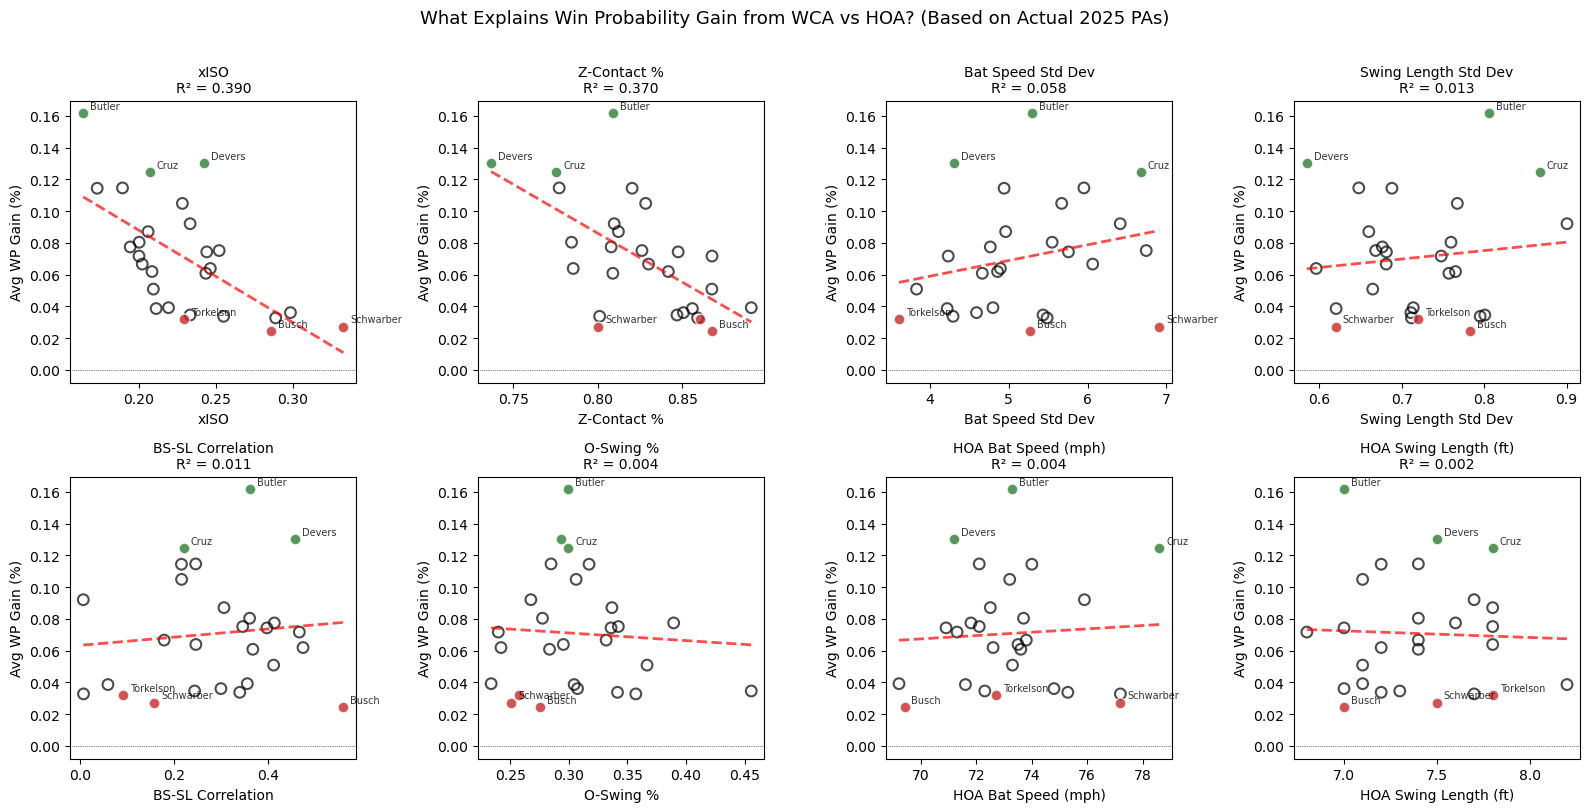


Top 5 Beneficiaries from WCA (Actual 2025 Situations):
  Lawrence Butler     : +0.1615% | BS=73.3, SL=7.00, xISO=0.164, O-Sw=29.9%, n=112 PAs
  Rafael Devers       : +0.1300% | BS=71.2, SL=7.50, xISO=0.242, O-Sw=29.3%, n=133 PAs
  Oneil Cruz          : +0.1245% | BS=78.6, SL=7.80, xISO=0.207, O-Sw=30.0%, n=109 PAs
  Randy Arozarena     : +0.1146% | BS=72.1, SL=7.40, xISO=0.190, O-Sw=28.5%, n=135 PAs
  Elly De La Cruz     : +0.1144% | BS=74.0, SL=7.20, xISO=0.173, O-Sw=31.7%, n=132 PAs

Bottom 5 (Least Benefit):
  Michael Busch       : +0.0244% | BS=69.4, SL=7.00, xISO=0.286, O-Sw=27.6%, n=97 PAs
  Kyle Schwarber      : +0.0273% | BS=77.2, SL=7.50, xISO=0.333, O-Sw=25.1%, n=125 PAs
  Spencer Torkelson   : +0.0321% | BS=72.7, SL=7.80, xISO=0.230, O-Sw=25.8%, n=107 PAs
  Jo Adell            : +0.0327% | BS=77.2, SL=7.70, xISO=0.289, O-Sw=35.7%, n=123 PAs
  Riley Greene        : +0.0337% | BS=75.3, SL=7.20, xISO=0.255, O-Sw=34.2%, n=114 PAs


In [127]:
# Why Do Some Hitters Benefit More from WCA vs HOA? (Using Actual 2025 PAs)
# Explore correlations between player characteristics and WP gain

SIM_OUTPUT_DIR = Path("Simulations/output")
DATA_DIR = Path("Data")
sim_files = list(SIM_OUTPUT_DIR.glob("*_simulation.parquet"))

# Load 2025 PBP data
pbp = pd.read_parquet(DATA_DIR / "pbp_2025.parquet")

PA_EVENTS = [
    'strikeout', 'strikeout_double_play', 'walk', 'hit_by_pitch', 'intent_walk',
    'field_out', 'force_out', 'grounded_into_double_play', 'double_play', 
    'fielders_choice', 'fielders_choice_out', 'sac_fly', 'sac_bunt', 'sac_fly_double_play',
    'single', 'double', 'triple', 'home_run'
]

# Match the final PVC cell: test tied BS/SL adjustments only
ADJUSTMENT_LEVELS = [0.0, -0.03, -0.06, -0.09, -0.12]
min_pas = 50

def encode_base_state(row):
    state = 0
    if pd.notna(row['on_1b']): state |= 1
    if pd.notna(row['on_2b']): state |= 2
    if pd.notna(row['on_3b']): state |= 4
    return state

player_analysis = []

for sim_file in sim_files:
    sim_df = pq.read_table(sim_file).to_pandas()
    player_name = sim_df['player_name'].iloc[0]
    player_id = sim_df['batter_id'].iloc[0]
    
    # Get player HOA characteristics
    baseline_bs = sim_df['baseline_bat_speed'].iloc[0]
    baseline_sl = sim_df['baseline_swing_length'].iloc[0]
    baseline_zc = sim_df['baseline_z_contact'].iloc[0]
    baseline_xiso = sim_df['baseline_xiso'].iloc[0]
    baseline_oswing = sim_df['baseline_o_swing_pct'].iloc[0]
    
    # Get player swing variability
    player_bs_std = sim_df['player_bs_std'].iloc[0]
    player_sl_std = sim_df['player_sl_std'].iloc[0]
    player_corr = sim_df['player_bs_sl_corr'].iloc[0]
    
    # Get this player's actual 2025 PAs
    player_pbp = pbp[(pbp['batter'] == player_id) & (pbp['events'].isin(PA_EVENTS))].copy()
    player_pbp = player_pbp[player_pbp['inning'].isin([7, 8, 9])].copy()
    player_pbp = player_pbp[(player_pbp['bat_score_diff'] >= -4) & (player_pbp['bat_score_diff'] <= 2)].copy()
    
    if len(player_pbp) < min_pas:
        continue
    
    player_pbp['base_state'] = player_pbp.apply(encode_base_state, axis=1)
    player_pbp['score_diff'] = player_pbp['bat_score_diff'].astype(int)
    player_pbp['count'] = player_pbp['balls'].astype(int).astype(str) + '-' + player_pbp['strikes'].astype(int).astype(str)
    player_pbp['pitcher_xfip_percentile'] = 50
    player_pbp = player_pbp.rename(columns={'outs_when_up': 'outs'})
    
    # Match the final PVC cell's WP calculation path exactly
    player_row = batter_stats[(batter_stats["xMLBAMID"] == player_id) &
                              (batter_stats["Season"] == 2025)]
    if len(player_row) == 0:
        continue
    player_o_swing = player_row.iloc[0]["O-Swing_pct"]

    try:
        player_stats = get_player_stats(player_name)
    except (ValueError, IndexError):
        continue

    adjusted_stats = {}
    for adj_pct in ADJUSTMENT_LEVELS:
        if adj_pct == 0.0:
            adjusted_stats[adj_pct] = (player_stats['z_contact'], player_stats['xiso'])
        else:
            bs_change = player_stats['bat_speed'] * adj_pct
            sl_change = player_stats['swing_length'] * adj_pct
            upd = update_stats(
                player_stats['bat_speed'], player_stats['swing_length'],
                player_stats['z_contact'], player_stats['xiso'],
                bs_change, sl_change
            )
            adjusted_stats[adj_pct] = (upd['new_z_contact'], upd['new_xiso'])

    wp_gains = []
    best_adj_pairs = []
    xfip = scalers["xFIP"]["mean"]

    for _, pa in player_pbp.iterrows():
        pre_outs = int(pa["outs"])
        pre_base_state = int(pa["base_state"])
        inning = int(pa["inning"])
        inning_topbot = pa["inning_topbot"]
        balls = int(pa["balls"]) if pd.notna(pa["balls"]) else 0
        strikes = int(pa["strikes"]) if pd.notna(pa["strikes"]) else 0

        score_diff = int(pa["bat_score_diff"]) if pd.notna(pa["bat_score_diff"]) else 0
        score_diff = max(-5, min(5, score_diff))

        wps_by_adj = {}
        for adj_pct in ADJUSTMENT_LEVELS:
            zc, xiso = adjusted_stats[adj_pct]
            probs = predict_probs_by_count(balls, strikes, player_o_swing, zc, xiso, xfip)
            wp = compute_expected_wp_for_probs(
                probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff
            )
            wps_by_adj[adj_pct] = wp

        hoa_wp = wps_by_adj[0.0]
        best_adj, wca_wp = max(wps_by_adj.items(), key=lambda kv: kv[1])
        wp_gains.append((wca_wp - hoa_wp) * 100)
        best_adj_pairs.append((best_adj, best_adj))

    if len(wp_gains) < min_pas:
        continue

    avg_wp_gain = float(np.mean(wp_gains))
    avg_best_bs_adj = float(np.mean([bs for bs, _ in best_adj_pairs]))
    avg_best_sl_adj = float(np.mean([sl for _, sl in best_adj_pairs]))
    n_pas = len(wp_gains)
    
    player_analysis.append({
        'player_name': player_name,
        'player_id': player_id,
        'hoa_bs': baseline_bs,
        'hoa_sl': baseline_sl,
        'hoa_zc': baseline_zc,
        'hoa_xiso': baseline_xiso,
        'hoa_oswing': baseline_oswing,
        'bs_std': player_bs_std,
        'sl_std': player_sl_std,
        'bs_sl_corr': player_corr,
        'avg_wp_gain': avg_wp_gain,
        'avg_best_bs_adj': avg_best_bs_adj,
        'avg_best_sl_adj': avg_best_sl_adj,
        'n_pas': n_pas,
    })

analysis_df = pd.DataFrame(player_analysis)
print(f"Analyzed {len(analysis_df)} players with {analysis_df['n_pas'].sum()} total late-game PAs")

# Calculate correlations with WP gain
corr_cols = ['hoa_bs', 'hoa_sl', 'hoa_zc', 'hoa_xiso', 'hoa_oswing', 
             'bs_std', 'sl_std', 'bs_sl_corr']
correlations = {col: analysis_df['avg_wp_gain'].corr(analysis_df[col]) for col in corr_cols}

print("\nCorrelations with Avg WP Gain (WCA - HOA):")
print("=" * 50)
for col, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"  {col:<20}: r² = {corr**2:.3f}")

# Identify top 3 and bottom 3 players for plot highlighting/labels
top3_ids = set(analysis_df.nlargest(3, 'avg_wp_gain')['player_id'])
bot3_ids = set(analysis_df.nsmallest(3, 'avg_wp_gain')['player_id'])

# Plot all 8 correlates in 2x4 grid, ordered by absolute correlation
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

plot_labels = {
    'hoa_bs': 'HOA Bat Speed (mph)',
    'hoa_sl': 'HOA Swing Length (ft)',
    'hoa_zc': 'Z-Contact %',
    'hoa_xiso': 'xISO',
    'hoa_oswing': 'O-Swing %',
    'bs_std': 'Bat Speed Std Dev',
    'sl_std': 'Swing Length Std Dev',
    'bs_sl_corr': 'BS-SL Correlation'
}

for idx, (col, corr) in enumerate(sorted_corrs):
    ax = axes[idx // 4, idx % 4]
    
    # Plot each player with appropriate color
    for _, row in analysis_df.iterrows():
        if row['player_id'] in top3_ids:
            ax.scatter(row[col], row['avg_wp_gain'], c='#2E7D32', alpha=0.8, s=60, edgecolors='white', zorder=3)
        elif row['player_id'] in bot3_ids:
            ax.scatter(row[col], row['avg_wp_gain'], c='#C62828', alpha=0.8, s=60, edgecolors='white', zorder=3)
        else:
            ax.scatter(row[col], row['avg_wp_gain'], facecolors='none', edgecolors='black', alpha=0.7, s=60, linewidths=1.5, zorder=2)
    
    # Add regression line
    z = np.polyfit(analysis_df[col], analysis_df['avg_wp_gain'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(analysis_df[col].min(), analysis_df[col].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', lw=2, alpha=0.7)
    
    ax.set_xlabel(plot_labels.get(col, col), fontsize=10)
    ax.set_ylabel('Avg WP Gain (%)', fontsize=10)
    r_sq = corr ** 2
    ax.set_title(f'{plot_labels.get(col, col)}\nR² = {r_sq:.3f}', fontsize=10)
    ax.axhline(0, color='black', linewidth=0.5, linestyle=':')
    
    # Add player labels for top/bottom 3 only, with offset to avoid overlap
    labeled_positions = []
    for _, row in analysis_df.iterrows():
        if row['player_id'] in top3_ids or row['player_id'] in bot3_ids:
            x_pos, y_pos = row[col], row['avg_wp_gain']
            
            # Check for overlap with existing labels
            too_close = False
            for lx, ly in labeled_positions:
                x_range = ax.get_xlim()[1] - ax.get_xlim()[0] if ax.get_xlim()[1] != ax.get_xlim()[0] else 1
                y_range = analysis_df['avg_wp_gain'].max() - analysis_df['avg_wp_gain'].min()
                if abs(x_pos - lx) / x_range < 0.08 and abs(y_pos - ly) / y_range < 0.12:
                    too_close = True
                    break
            
            if not too_close:
                ax.annotate(row['player_name'].split()[-1], 
                           (x_pos, y_pos),
                           fontsize=7, alpha=0.8,
                           xytext=(5, 3), textcoords='offset points')
                labeled_positions.append((x_pos, y_pos))

plt.suptitle('What Explains Win Probability Gain from WCA vs HOA? (Based on Actual 2025 PAs)', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# Show top and bottom beneficiaries
print("\n" + "=" * 70)
print("Top 5 Beneficiaries from WCA (Actual 2025 Situations):")
for _, row in analysis_df.nlargest(5, 'avg_wp_gain').iterrows():
    print(f"  {row['player_name']:<20}: {row['avg_wp_gain']:+.4f}% | BS={row['hoa_bs']:.1f}, SL={row['hoa_sl']:.2f}, xISO={row['hoa_xiso']:.3f}, O-Sw={row['hoa_oswing']:.1%}, n={row['n_pas']} PAs")

print("\nBottom 5 (Least Benefit):")
for _, row in analysis_df.nsmallest(5, 'avg_wp_gain').iterrows():
    print(f"  {row['player_name']:<20}: {row['avg_wp_gain']:+.4f}% | BS={row['hoa_bs']:.1f}, SL={row['hoa_sl']:.2f}, xISO={row['hoa_xiso']:.3f}, O-Sw={row['hoa_oswing']:.1%}, n={row['n_pas']} PAs")


PVC Hitters: 27 players
Filtered to simulation situations: innings [7, 8, 9], score diff -4 to 2
PAs matching simulation situations: 35453


Processing PVC hitters: 100%|██████████| 27/27 [01:46<00:00,  3.96s/it]


Processed 27 PVC hitters with >= 50 PAs

Top 10 PVC hitters with most WP gain from WCA:
      player_name  n_pas  avg_wp_diff_pp  z_contact   xiso
  Lawrence Butler    112        0.161511     0.8089 0.1642
    Rafael Devers    133        0.130016     0.7370 0.2423
       Oneil Cruz    109        0.124524     0.7756 0.2073
  Randy Arozarena    135        0.114574     0.7772 0.1896
  Elly De La Cruz    132        0.114359     0.8203 0.1732
     Brent Rooker    109        0.104827     0.8283 0.2284
       James Wood    116        0.092044     0.8097 0.2334
Teoscar Hernández     96        0.087059     0.8122 0.2062
     Ryan McMahon    115        0.080373     0.7845 0.2004
    Adolis García    101        0.077414     0.8079 0.1946


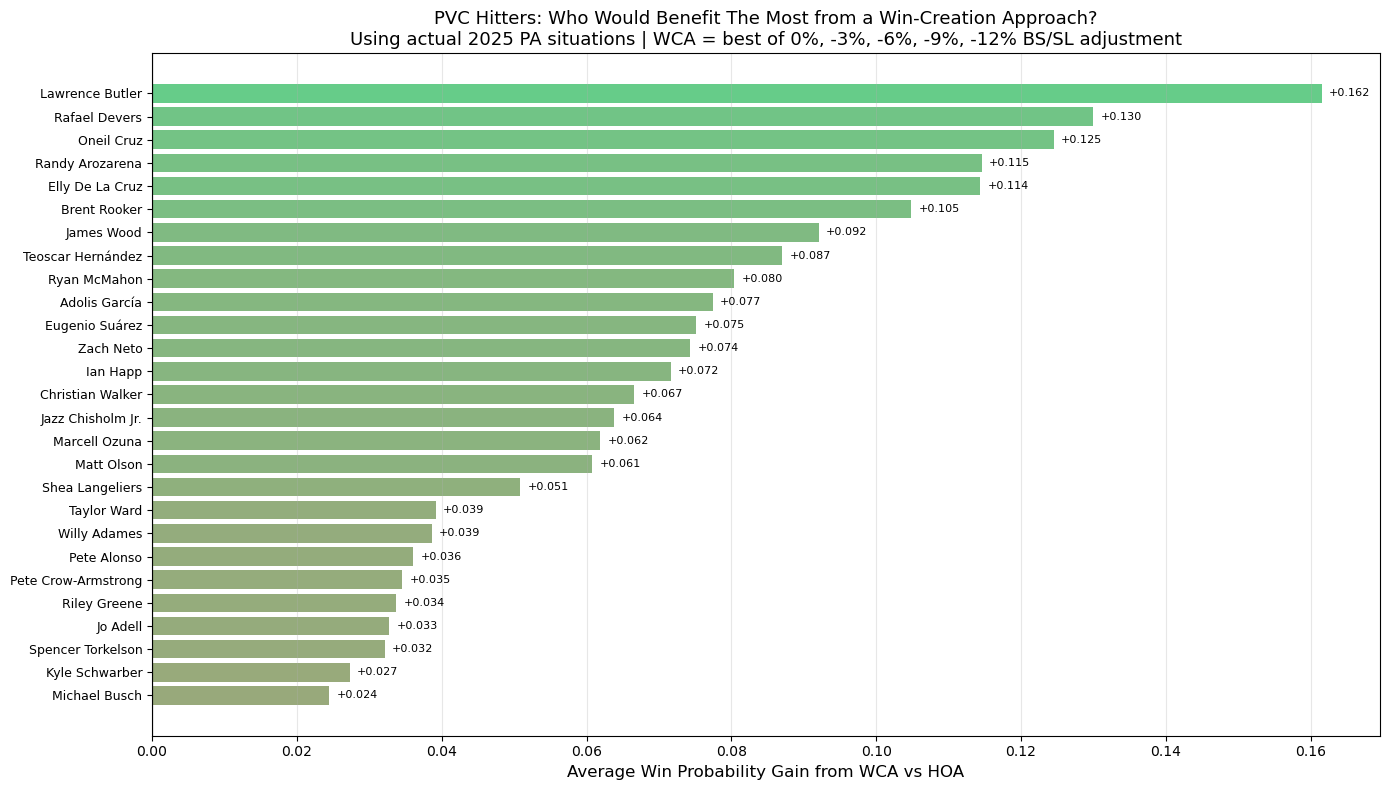


Summary:
  Mean WP gain across all PVC hitters: +0.0708%
  Max WP gain: +0.1615% (Lawrence Butler)
  Hitters with positive WP gain: 27 / 27


In [123]:
# PVC Hitters: WCA vs HOA Win Probability Analysis
# For each PVC hitter, use their actual 2025 PA situations to compute avg WP diff between:
# - WCA (Win-Contribution Approach): choose swing adjustment that maximizes WP for each situation
# - HOA (Hitter-Optimized Approach): baseline stats, no adjustment

from tqdm import tqdm

# Define the 27 PVC batters

PVC_BATTERS = {
    "Oneil Cruz",
    "James Wood",
    "Ryan McMahon",
    "Riley Greene",
    "Eugenio Suárez",
    "Elly De La Cruz",
    "Kyle Schwarber",
    "Jo Adell",
    "Teoscar Hernández",
    "Spencer Torkelson",
    "Lawrence Butler",
    "Randy Arozarena",
    "Adolis García",
    "Jazz Chisholm Jr.",
    "Christian Walker",
    "Michael Busch",
    "Willy Adames",
    "Taylor Ward",
    "Rafael Devers",
    "Brent Rooker",
    "Zach Neto",
    "Matt Olson",
    "Marcell Ozuna",
    "Ian Happ",
    "Pete Crow-Armstrong",
    "Pete Alonso",
    "Shea Langeliers"
}
print(f"PVC Hitters: {len(PVC_BATTERS)} players")

# Load 2025 PBP data
pbp_2025 = pd.read_parquet(DATA_DIR / "pbp_2025.parquet")

# Filter to plate appearances with valid outcomes (events that end PA)
PA_EVENTS = [
    'strikeout', 'strikeout_double_play', 'walk', 'hit_by_pitch', 'intent_walk',
    'field_out', 'force_out', 'grounded_into_double_play', 'double_play', 
    'fielders_choice', 'fielders_choice_out', 'sac_fly', 'sac_bunt', 'sac_fly_double_play',
    'single', 'double', 'triple', 'home_run'
]

# Filter PBP to PA-ending events
pbp_pas = pbp_2025[pbp_2025["events"].isin(PA_EVENTS)].copy()

# Filter to situations covered by simulations (from config.py):
# - Innings 7-9 (late game)
# - Score diff -4 to +2
SIM_INNINGS = [7, 8, 9]
SIM_SCORE_RANGE = (-4, 2)

pbp_pas = pbp_pas[pbp_pas["inning"].isin(SIM_INNINGS)].copy()
pbp_pas = pbp_pas[
    (pbp_pas["bat_score_diff"] >= SIM_SCORE_RANGE[0]) & 
    (pbp_pas["bat_score_diff"] <= SIM_SCORE_RANGE[1])
].copy()

print(f"Filtered to simulation situations: innings {SIM_INNINGS}, score diff {SIM_SCORE_RANGE[0]} to {SIM_SCORE_RANGE[1]}")
print(f"PAs matching simulation situations: {len(pbp_pas)}")

# Encode base state
def encode_base(row):
    state = 0
    if pd.notna(row["on_1b"]): state |= 1
    if pd.notna(row["on_2b"]): state |= 2
    if pd.notna(row["on_3b"]): state |= 4
    return state

pbp_pas["base_state"] = pbp_pas.apply(encode_base, axis=1)

# Define swing adjustment levels to test (% reduction in BS and SL)
ADJUSTMENT_LEVELS = [0.0, -0.03, -0.06, -0.09, -0.12]  # 0%, -3%, -6%, -9%, -12%

def compute_expected_wp_for_probs(outcome_probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff):
    """Compute expected WP after PA given outcome probabilities."""
    total_wp = 0.0
    for outcome_idx, prob in enumerate(outcome_probs):
        if prob < 1e-6:
            continue
        transitions = transition_tables.get((outcome_idx, pre_outs, pre_base_state), 
                                            [(pre_base_state, min(pre_outs+1, 3), 0, 1.0)])
        for post_base, post_outs, runs_scored, trans_prob in transitions:
            new_score_diff = score_diff + runs_scored
            if post_outs >= 3:
                if inning_topbot == "Bot" and inning >= 9:
                    if new_score_diff > 0:
                        wp_after = 1.0
                    elif new_score_diff < 0:
                        wp_after = 0.0
                    else:
                        wp_after = 1 - lookup_wp(0, 0, min(inning + 1, 9), "Top", -new_score_diff)
                elif inning_topbot == "Top":
                    wp_after = 1 - lookup_wp(0, 0, inning, "Bot", -new_score_diff)
                else:
                    wp_after = 1 - lookup_wp(0, 0, min(inning + 1, 9), "Top", -new_score_diff)
            else:
                if inning >= 9 and inning_topbot == "Bot" and score_diff <= 0 and new_score_diff > 0:
                    wp_after = 1.0
                else:
                    wp_after = lookup_wp(post_outs, post_base, inning, inning_topbot, new_score_diff)
            total_wp += prob * trans_prob * wp_after
    return total_wp

# Process each PVC hitter
results = []
min_pas = 50  # Minimum PAs to include hitter

for player_name in tqdm(PVC_BATTERS, desc="Processing PVC hitters"):
    # Get player stats
    try:
        player_stats = get_player_stats(player_name)
    except (ValueError, IndexError):
        print(f"  Skipping {player_name}: could not get stats")
        continue
    
    player_id = player_stats['mlbam_id']
    
    # Get player's PAs
    player_pas = pbp_pas[pbp_pas["batter"] == player_id]
    
    if len(player_pas) < min_pas:
        print(f"  Skipping {player_name}: only {len(player_pas)} PAs")
        continue
    
    # Get o_swing from batter stats
    player_row = batter_stats[(batter_stats["xMLBAMID"] == player_id) & 
                              (batter_stats["Season"] == 2025)]
    if len(player_row) == 0:
        print(f"  Skipping {player_name}: no 2025 batter stats")
        continue
    player_o_swing = player_row.iloc[0]["O-Swing_pct"]
    
    # Pre-compute adjusted stats for each level
    adjusted_stats = {}
    for adj_pct in ADJUSTMENT_LEVELS:
        if adj_pct == 0.0:
            adjusted_stats[adj_pct] = (player_stats['z_contact'], player_stats['xiso'])
        else:
            bs_change = player_stats['bat_speed'] * adj_pct
            sl_change = player_stats['swing_length'] * adj_pct
            upd = update_stats(
                player_stats['bat_speed'], player_stats['swing_length'],
                player_stats['z_contact'], player_stats['xiso'],
                bs_change, sl_change
            )
            adjusted_stats[adj_pct] = (upd['new_z_contact'], upd['new_xiso'])
    
    # Process each PA
    wp_diffs = []
    
    for _, pa in player_pas.iterrows():
        # Extract situation
        pre_outs = int(pa["outs_when_up"])
        pre_base_state = int(pa["base_state"])
        inning = int(pa["inning"])
        inning_topbot = pa["inning_topbot"]
        balls = int(pa["balls"]) if pd.notna(pa["balls"]) else 0
        strikes = int(pa["strikes"]) if pd.notna(pa["strikes"]) else 0
        
        # Get score diff (clamp to reasonable range)
        score_diff = int(pa["bat_score_diff"]) if pd.notna(pa["bat_score_diff"]) else 0
        score_diff = max(-5, min(5, score_diff))
        
        # Use average pitcher for simplicity
        xfip = scalers["xFIP"]["mean"]
        
        # Compute WP for each adjustment level
        wps_by_adj = {}
        for adj_pct in ADJUSTMENT_LEVELS:
            zc, xiso = adjusted_stats[adj_pct]
            probs = predict_probs_by_count(balls, strikes, player_o_swing, zc, xiso, xfip)
            wp = compute_expected_wp_for_probs(probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff)
            wps_by_adj[adj_pct] = wp
        
        # HOA = baseline (0% adjustment)
        hoa_wp = wps_by_adj[0.0]
        
        # WCA = whichever adjustment gives highest WP
        wca_wp = max(wps_by_adj.values())
        
        # WP diff (WCA - HOA)
        wp_diff = wca_wp - hoa_wp
        wp_diffs.append(wp_diff)
    
    # Compute average WP diff for this hitter
    avg_wp_diff = np.mean(wp_diffs) * 100  # Convert to percentage points
    
    results.append({
        'player_name': player_name,
        'player_id': player_id,
        'n_pas': len(player_pas),
        'avg_wp_diff_pp': avg_wp_diff,
        'bat_speed': player_stats['bat_speed'],
        'swing_length': player_stats['swing_length'],
        'z_contact': player_stats['z_contact'],
        'xiso': player_stats['xiso'],
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('avg_wp_diff_pp', ascending=False)

print(f"\nProcessed {len(results_df)} PVC hitters with >= {min_pas} PAs")
print(f"\nTop 10 PVC hitters with most WP gain from WCA:")
print(results_df.head(10)[['player_name', 'n_pas', 'avg_wp_diff_pp', 'z_contact', 'xiso']].to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Sort by WP diff
results_df_sorted = results_df.sort_values('avg_wp_diff_pp', ascending=True)

# Color scale: red (-0.2) to green (+0.2)
def wp_to_color(val):
    from matplotlib.colors import to_rgb
    val_clipped = max(-0.2, min(0.2, val))
    normalized = (val_clipped + 0.2) / 0.4  # 0 to 1
    red = to_rgb('#e74c3c')
    green = to_rgb('#2ecc71')
    return tuple(r + normalized * (g - r) for r, g in zip(red, green))

colors = [wp_to_color(x) for x in results_df_sorted['avg_wp_diff_pp']]

bars = ax.barh(range(len(results_df_sorted)), results_df_sorted['avg_wp_diff_pp'], color=colors, alpha=0.8)

ax.set_yticks(range(len(results_df_sorted)))
ax.set_yticklabels(results_df_sorted['player_name'], fontsize=9)
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Average Win Probability Gain from WCA vs HOA', fontsize=12)
ax.set_title('PVC Hitters: Who Would Benefit The Most from a Win-Creation Approach?\n'
             'Using actual 2025 PA situations | WCA = best of 0%, -3%, -6%, -9%, -12% BS/SL adjustment', 
             fontsize=13)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(results_df_sorted.iterrows()):
    val = row['avg_wp_diff_pp']
    ax.text(val + 0.001 if val >= 0 else val - 0.001, i, f"{val:+.3f}", 
            va='center', ha='left' if val >= 0 else 'right', fontsize=8)

plt.tight_layout()
plt.show()

# Summary stats
print(f"\nSummary:")
print(f"  Mean WP gain across all PVC hitters: {results_df['avg_wp_diff_pp'].mean():+.4f}%")
print(f"  Max WP gain: {results_df['avg_wp_diff_pp'].max():+.4f}% ({results_df.iloc[0]['player_name']})")
print(f"  Hitters with positive WP gain: {(results_df['avg_wp_diff_pp'] > 0).sum()} / {len(results_df)}")


Oneil Cruz (2025)
  BS: 78.6 mph, SL: 7.80 ft
  Z-Contact: 77.6%, xISO: 0.207
  O-Swing: 30.0%

Contact Approach (-12% BS, -12% SL):
  BS: 69.2 mph, SL: 6.86 ft
  Z-Contact: 89.3%, xISO: 0.062
  Fixed count: 0-0
  Fixed state: Runners on 2nd & 3rd, 2 out
  Average pitcher xFIP (league mean): 4.18

About to plot...


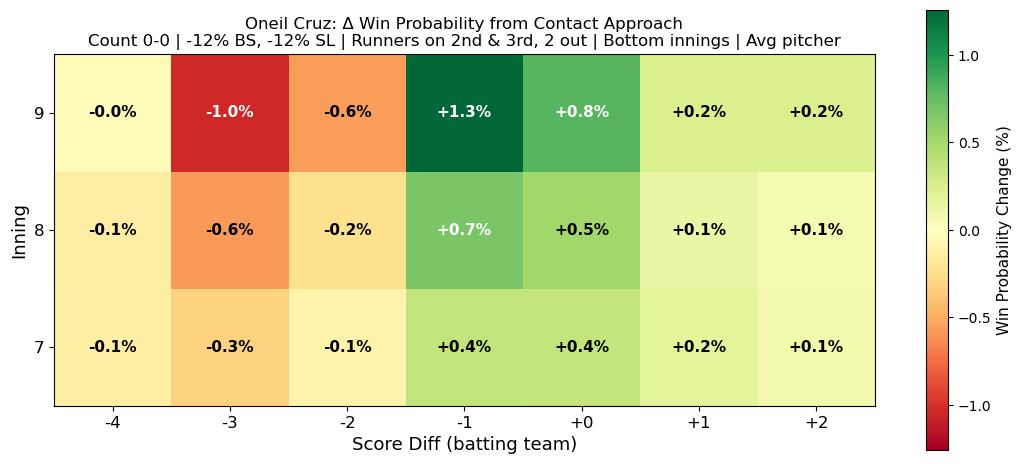

In [148]:
# Oneil Cruz: Win Probability Change by Inning / Score Diff with Contact Approach
# Heatmap of ΔWP (contact approach - baseline) for a fixed count and base/out state

import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SIM_DIR = Path("Simulations")

# Load transition tables
with open(SIM_DIR / "transition_tables.pkl", "rb") as f:
    transition_tables = pickle.load(f)

# Player / approach settings
PLAYER_QUERY = "ONeil Cruz"
bs_pct_change = -0.12
sl_pct_change = -0.12

# Fixed PA state (x/y vary below)
pre_outs = 2
pre_base_state = 6  # Runners on 2nd & 3rd
inning_topbot = "Bot"
balls, strikes = 0, 0  # Fixed count for this heatmap

# Heatmap axes
innings = [7, 8, 9]              # x-axis
score_diffs = list(range(-4, 3))  # y-axis (batting team score diff)

BASE_STATE_LABELS = {
    0: "Bases Empty",
    1: "Runner on 1st",
    2: "Runner on 2nd",
    3: "Runners on 1st & 2nd",
    4: "Runner on 3rd",
    5: "Runners on 1st & 3rd",
    6: "Runners on 2nd & 3rd",
    7: "Bases Loaded",
}

# Get player stats
player = get_player_stats(PLAYER_QUERY)
print(f"{player['player_name']} ({player['season']})")
print(f"  BS: {player['bat_speed']:.1f} mph, SL: {player['swing_length']:.2f} ft")
print(f"  Z-Contact: {player['z_contact']:.1%}, xISO: {player['xiso']:.3f}")

# Get O-Swing robustly (prefer ID match if available)
player_o_swing = None
player_id = player.get('mlbam_id', None)
if 'xMLBAMID' in batter_stats.columns and player_id is not None and 'Season' in batter_stats.columns:
    row = batter_stats[(batter_stats['xMLBAMID'] == player_id) & (batter_stats['Season'] == player['season'])]
    if len(row) and 'O-Swing_pct' in row.columns:
        player_o_swing = float(row.iloc[0]['O-Swing_pct'])
if player_o_swing is None and 'PlayerName' in batter_stats.columns and 'Season' in batter_stats.columns:
    row = batter_stats[(batter_stats['PlayerName'] == player['player_name']) & (batter_stats['Season'] == player['season'])]
    if len(row) and 'O-Swing_pct' in row.columns:
        player_o_swing = float(row.iloc[0]['O-Swing_pct'])
if player_o_swing is None:
    raise ValueError("Could not find O-Swing_pct for player in batter_stats")
print(f"  O-Swing: {player_o_swing:.1%}")

# Contact approach stats (-12% BS, -12% SL)
bs_change = player['bat_speed'] * bs_pct_change
sl_change = player['swing_length'] * sl_pct_change
upd = update_stats(
    player['bat_speed'], player['swing_length'],
    player['z_contact'], player['xiso'],
    bs_change, sl_change,
)
contact_zc = upd['new_z_contact']
contact_xiso = upd['new_xiso']

print(f"\nContact Approach ({bs_pct_change:+.0%} BS, {sl_pct_change:+.0%} SL):")
print(f"  BS: {player['bat_speed'] + bs_change:.1f} mph, SL: {player['swing_length'] + sl_change:.2f} ft")
print(f"  Z-Contact: {contact_zc:.1%}, xISO: {contact_xiso:.3f}")
print(f"  Fixed count: {balls}-{strikes}")
print(f"  Fixed state: {BASE_STATE_LABELS[pre_base_state]}, {pre_outs} out")

# Use league-average pitcher explicitly
scenario_xfip = scalers['xFIP']['mean']
print(f"  Average pitcher xFIP (league mean): {scenario_xfip:.2f}")


def compute_expected_wp(outcome_probs, pre_outs, pre_base_state, inning, inning_topbot, score_diff):
    """Compute expected WP after PA given outcome probabilities."""
    total_wp = 0.0

    for outcome_idx, prob in enumerate(outcome_probs):
        if prob < 1e-6:
            continue

        transitions = transition_tables.get(
            (outcome_idx, pre_outs, pre_base_state),
            [(pre_base_state, min(pre_outs + 1, 3), 0, 1.0)],
        )

        for post_base, post_outs, runs_scored, trans_prob in transitions:
            new_score_diff = score_diff + runs_scored

            # Bottom 9+ walk-off: batting team takes lead, game ends immediately
            if inning_topbot == 'Bot' and inning >= 9 and score_diff <= 0 and new_score_diff > 0:
                wp_after = 1.0
            elif post_outs >= 3:
                if inning_topbot == 'Bot' and inning >= 9:
                    if new_score_diff > 0:
                        wp_after = 1.0
                    elif new_score_diff < 0:
                        wp_after = 0.0
                    else:
                        wp_after = 1 - lookup_wp(0, 0, min(inning + 1, 9), 'Top', -new_score_diff)
                elif inning_topbot == 'Top':
                    wp_after = 1 - lookup_wp(0, 0, inning, 'Bot', -new_score_diff)
                else:
                    wp_after = 1 - lookup_wp(0, 0, min(inning + 1, 9), 'Top', -new_score_diff)
            else:
                wp_after = lookup_wp(post_outs, post_base, inning, inning_topbot, new_score_diff)

            total_wp += prob * trans_prob * wp_after

    return total_wp


# Outcome probabilities depend on count/player/pitcher, not inning/score diff
baseline_probs = predict_probs_by_count(
    balls, strikes, player_o_swing, player['z_contact'], player['xiso'], scenario_xfip
)
contact_probs = predict_probs_by_count(
    balls, strikes, player_o_swing, contact_zc, contact_xiso, scenario_xfip
)

# Build heatmap grid: rows = inning, cols = score diff
wp_diff_grid = np.full((len(innings), len(score_diffs)), np.nan)  # percentage points

for i, inn in enumerate(innings):
    for j, sd in enumerate(score_diffs):
        baseline_wp = compute_expected_wp(baseline_probs, pre_outs, pre_base_state, inn, inning_topbot, sd)
        contact_wp = compute_expected_wp(contact_probs, pre_outs, pre_base_state, inn, inning_topbot, sd)
        wp_diff_grid[i, j] = (contact_wp - baseline_wp) * 100  # percentage points

print("\nAbout to plot...")

# Plot heatmap
fig, ax = plt.subplots(figsize=(11, 4.8))

vmax = np.nanmax(np.abs(wp_diff_grid))
if not np.isfinite(vmax) or vmax == 0:
    vmax = 0.1

im = ax.imshow(
    wp_diff_grid,
    cmap='RdYlGn',
    vmin=-vmax,
    vmax=vmax,
    aspect='equal',
    origin='lower',
)

ax.set_xticks(range(len(score_diffs)))
ax.set_xticklabels([f"{x:+d}" for x in score_diffs], fontsize=12)
ax.set_yticks(range(len(innings)))
ax.set_yticklabels([str(y) for y in innings], fontsize=12)
ax.set_xlabel('Score Diff (batting team)', fontsize=13)
ax.set_ylabel('Inning', fontsize=13)

# Cell annotations
for i, inn in enumerate(innings):
    for j, sd in enumerate(score_diffs):
        val = wp_diff_grid[i, j]
        if np.isnan(val):
            continue
        color = 'white' if abs(val) > vmax * 0.5 else 'black'
        ax.text(j, i, f"{val:+.1f}%", ha='center', va='center', color=color, fontsize=11, fontweight='bold')

ax.set_title(
    f"{player['player_name']}: Δ Win Probability from Contact Approach\n"
    f"Count {balls}-{strikes} | -12% BS, -12% SL | {BASE_STATE_LABELS[pre_base_state]}, {pre_outs} out | Bottom innings | Avg pitcher",
    fontsize=12,
)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Win Probability Change (%)', fontsize=11)

plt.tight_layout()
plt.show()


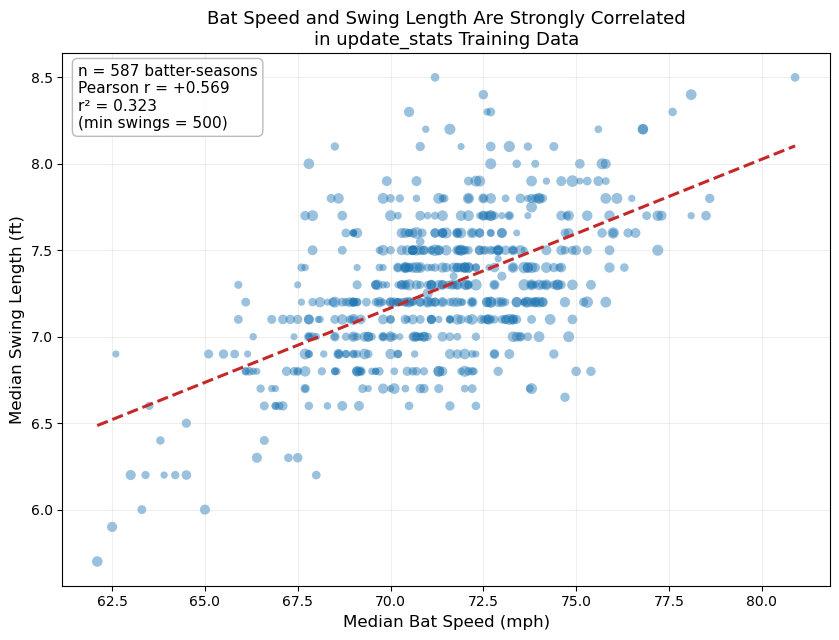

Batter-season correlation (median bat speed vs median swing length): r = +0.5685 (r² = 0.3232, n = 587)


In [157]:
# Bat Speed vs Swing Length Correlation (update_stats training data)
# Shows why a joint model (PLS2) is useful: the mechanics inputs are materially correlated.

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Ensure Bayes Outcomes module path is available when running this cell directly
repo_root = Path('.').resolve()
if str(repo_root / 'Bayes Outcomes') not in sys.path:
    sys.path.insert(0, str(repo_root / 'Bayes Outcomes'))

from update_stats import _build_training_data

# Uses the same training-data construction/filtering as update_stats.py
corr_df = _build_training_data().copy()

x = corr_df['median_bat_speed'].to_numpy(dtype=float)
y = corr_df['median_swing_length'].to_numpy(dtype=float)
r = float(np.corrcoef(x, y)[0, 1])
r2 = r ** 2
n = len(corr_df)

# Simple regression line for visual trend
m, b = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 200)
y_line = m * x_line + b

fig, ax = plt.subplots(figsize=(8.5, 6.5))

# Slightly size points by swing sample size if available
if 'swing_sample_n' in corr_df.columns:
    sizes = np.clip(corr_df['swing_sample_n'].to_numpy(dtype=float) / 20.0, 18, 90)
else:
    sizes = 28

ax.scatter(x, y, s=sizes, alpha=0.45, color='#1f77b4', edgecolors='none')
ax.plot(x_line, y_line, color='#C62828', lw=2.2, linestyle='--')

ax.set_xlabel('Median Bat Speed (mph)', fontsize=12)
ax.set_ylabel('Median Swing Length (ft)', fontsize=12)
ax.set_title('Bat Speed and Swing Length Are Strongly Correlated\nin update_stats Training Data', fontsize=13)
ax.grid(alpha=0.2)

annotation = f'n = {n} batter-seasons\nPearson r = {r:+.3f}\nr² = {r2:.3f}'
if 'swing_sample_n' in corr_df.columns:
    annotation += f"\n(min swings = {int(corr_df['swing_sample_n'].min())})"

ax.text(
    0.02, 0.98, annotation,
    transform=ax.transAxes,
    ha='left', va='top', fontsize=11,
    bbox=dict(boxstyle='round,pad=0.35', facecolor='white', edgecolor='0.7', alpha=0.9)
)

plt.tight_layout()
plt.show()

print(f'Batter-season correlation (median bat speed vs median swing length): r = {r:+.4f} (r² = {r2:.4f}, n = {n})')
